**Importing required libraries**

In [1]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#sickit_learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight, shuffle

#keras
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from keras.applications import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.image as mpimg

In [2]:
from google.colab import drive

# Mounting Google Drive to access images
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# List of all folder names in my images directory
foldernames = os.listdir('/content/drive/MyDrive/bigdataproject/resized_20k')
foldernames

['Bags',
 'Bottomwear',
 'Belts',
 'Watches',
 'Flip Flops',
 'Innerwear',
 'Shoes',
 'Sandal',
 'Topwear']

In [4]:
# Define the parent directory containing the image categories
parent_directory = "/content/drive/MyDrive/bigdataproject/resized_20k"

# Get the list of folder names (categories)
foldernames = os.listdir(parent_directory)

bags_dir = "/content/drive/MyDrive/bigdataproject/resized_20k/Bags"
belts_dir= "/content/drive/MyDrive/bigdataproject/resized_20k/Belts"
bottomwears_dir = "/content/drive/MyDrive/bigdataproject/resized_20k/Bottomwear"
flipflops_dir= "/content/drive/MyDrive/bigdataproject/resized_20k/Flip Flops"
innerwears_dir = "/content/drive/MyDrive/bigdataproject/resized_20k/Innerwear"
shoes_dir= "/content/drive/MyDrive/bigdataproject/resized_20k/Shoes"
topwears_dir = "/content/drive/MyDrive/bigdataproject/resized_20k/Topwear"
watches_dir= "/content/drive/MyDrive/bigdataproject/resized_20k/Watches"
sandals_dir = "/content/drive/MyDrive/bigdataproject/resized_20k/Sandal"


files = []
categories = []

# For each category folder, retrieve and store the file paths and their corresponding category indices
for category_index, folder in enumerate(foldernames):
    filenames = os.listdir(os.path.join(parent_directory, folder))

    # Append each file's path and its category index to the respective lists
    for filename in filenames:
        files.append(os.path.join(parent_directory, folder, filename))
        categories.append(category_index)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'filename': files,
    'category': categories
})


In [5]:
# Let us Display the first few rows of the DataFrame to verify its contents
df.head()

filename  category
0  /content/drive/MyDrive/bigdataproject/resized_...         0
1  /content/drive/MyDrive/bigdataproject/resized_...         0
2  /content/drive/MyDrive/bigdataproject/resized_...         0
3  /content/drive/MyDrive/bigdataproject/resized_...         0
4  /content/drive/MyDrive/bigdataproject/resized_...         0

In [6]:
#DataFrame has 19942 entries and 2 columns: 'filename' (containing strings) and 'category' (containing integers).
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  19942 non-null  object
 1   category  19942 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 311.7+ KB
None


In [7]:
#Categories Distribution
print(df['category'].value_counts())
total_count = df['category'].value_counts().sum()
print("Total count:", total_count)

category
8    4173
6    3524
0    3057
3    2542
1    2154
5    1803
7     963
4     915
2     811
Name: count, dtype: int64
Total count: 19942


**Random display of few samples**

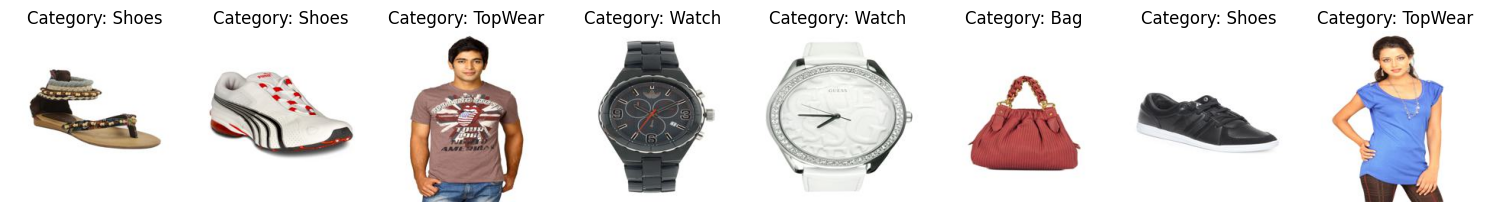

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dictionary mapping category numerical labels to their names
category_names = {
    0: 'Bag',
    1: 'Bottomwear',
    2: 'Belt',
    3: 'Watch',
    4: 'Flip Flops',
    5: 'InnerWear',
    6: 'Shoes',
    7: 'Sandal',
    8: 'TopWear',
}

# Randomly selecting few samples
samples = df.sample(n=8)

# Subplot layout
fig, axes = plt.subplots(ncols=len(samples), figsize=(15, 3))

# Displaying the images with their categories
for ax, (_, row) in zip(axes, samples.iterrows()):
    img = mpimg.imread(row['filename'])
    ax.imshow(img)
    category_name = category_names.get(row['category'], 'Unknown')
    ax.set_title(f"Category: {category_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()


**Preprocessing our Data**

In [10]:
#Splits the DataFrame into training and testing sets while preserving the proportion of categories.

from sklearn.model_selection import train_test_split

#Splitting
train_df, test_df = pd.DataFrame(), pd.DataFrame()
for cat in df['category'].unique():
    category_df = df[df['category'] == cat]
    train_cat, test_cat = train_test_split(category_df, test_size=0.2, random_state=42)
    train_df = pd.concat([train_df, train_cat])
    test_df = pd.concat([test_df, test_cat])

# Displays the number of samples in each category for the training set
print("Training set category distribution:")
print(train_df['category'].value_counts())

# Displays the number of samples in each category for the testing set
print("\nTesting set category distribution:")
print(test_df['category'].value_counts())

Training set category distribution:
category
8    3338
6    2819
0    2445
3    2033
1    1723
5    1442
7     770
4     732
2     648
Name: count, dtype: int64

Testing set category distribution:
category
8    835
6    705
0    612
3    509
1    431
5    361
7    193
4    183
2    163
Name: count, dtype: int64


In [ ]:
# Define a function to center and resize images
def centering_image(img):
    size = [256, 256]
    img_size = img.shape[:2]

    # Calculate the center coordinates
    # Center the image within the desired size
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img
    return resized

In [ ]:
# Initialize lists to store preprocessed images
images = []
test_images = []

# Define the directory paths for training and testing images
train_dirs = [bags_dir, belts_dir, bottomwears_dir, flipflops_dir, innerwears_dir, shoes_dir, topwears_dir, watches_dir, sandals_dir]

# Process training images
for train_dir in train_dirs:
    # Get a list of image file paths in the directory
    train_files = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]

    # Iterate over each image file
    with tqdm(total=len(train_files)) as pbar:
        for file_path in train_files:
            # Read image
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image while maintaining aspect ratio
            if img.shape[0] > img.shape[1]:
                tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
            else:
                tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

            # Center and resize image
            img = centering_image(cv2.resize(img, dsize=tile_size))


            # Crop to 224x224 pixels
            img = img[16:240, 16:240]

            # Append preprocessed image to the list
            images.append(img)
            pbar.update(1)

# Convert lists to NumPy arrays
images = np.array(images)
test_images = np.array(test_images)


100%|██████████| 963/963 [00:35<00:00, 26.95it/s] 


In [ ]:
from tensorflow.keras.utils import to_categorical

x_final_test=test_images
y_final_test = to_categorical(test_df['category'])

# Convert test images to float32 and normalize them
x_final_test = test_images.astype('float32')
x_final_test /= 255
y_final_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
train_df.head()

filename  category
2319  /content/drive/MyDrive/bigdataproject/resized_...         0
2029  /content/drive/MyDrive/bigdataproject/resized_...         0
1373  /content/drive/MyDrive/bigdataproject/resized_...         0
351   /content/drive/MyDrive/bigdataproject/resized_...         0
2915  /content/drive/MyDrive/bigdataproject/resized_...         0

In [ ]:
print(len(train_df))

15950


In [ ]:
# Function to load and preprocess an image
def preprocess_image(file_path):
    # Read the image
    img = cv2.imread(file_path)
    if img is None:
      if img.shape != (224, 176, 3):  # Skip if image file cannot be read
        print(f"Error reading image: {file_path}")
        return None
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image while maintaining aspect ratio
    if img.shape[0] > img.shape[1]:
        tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))
    img = cv2.resize(img, dsize=tile_size)

    # Center crop to 224x176 pixels
    img = img[:, 16:192]
    # Normalize pixel values to the range [0, 1]
    img = img.astype('float32') / 255
    return img

In [ ]:
# Load and preprocess images for x_train
x_train = []
y_train = []

for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        img = preprocess_image(row['filename'])
        if img is not None:
            # Modify the condition to check if image dimensions are within an acceptable range
            if img.shape[0] >= 224 and img.shape[1] >= 176 and img.shape[2] == 3:
              # Append the image to x_train
              x_train.append(img)
              y_train.append(row['category'])
            else:
              print(f"Ignoring image: {row['filename']} - Invalid shape: {img.shape}")

    except Exception as e:
        print(f"Error processing image: {row['filename']}, {e}")
# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



100%|██████████| 15950/15950 [01:09<00:00, 229.13it/s]


**Let's create Our Model**

ResNet50 serves as a pre-trained convolutional neural network for feature extraction in this project, providing a robust foundation for the custom classification layers.

In [ ]:
# It means I exclude the last all Dense layers
resnet_model = ResNet50(include_top=False,
                        weights="imagenet",
                        input_shape=(224,176,3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 176, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 182, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 88, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 88, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Freeze the trainable weights

resnet_model.trainable = False

Below defines a **sequential model** that includes an input layer, the pre-trained ResNet50 model for feature extraction, and a global max pooling layer to reduce the dimensionality of the extracted features for further processing.

In [ ]:
model = Sequential(layers=[
    resnet_model,
    GlobalMaxPooling2D()
])

from keras.layers import Input

# Define input shape
input_shape = (224, 176, 3)  # Update input shape to match the shape of the input data

# Define input layer with the specified shape
input_layer = Input(shape=input_shape)

# Use the input layer in your model definition
model = Sequential(layers=[
    input_layer,  # Add input layer to the beginning of your model
    resnet_model,
    GlobalMaxPooling2D()
])

**extract_important_features** function extracts important features from an image using a pre-trained model for further analysis or classification.

In [ ]:
def extract_important_features(img_path, model):
    img = image.load_img(path=img_path, target_size=(224,176))
    img_array = image.img_to_array(img=img)
    expanded_img_array = np.expand_dims(img, axis=0)
    preprocessed_img = preprocess_input(x=expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / np.linalg.norm(result)

    return normalized_result

In [ ]:
filenames = train_df['filename'].tolist()

In [ ]:
len(filenames)

15950

In [ ]:
img = cv2.imread('/content/drive/MyDrive/bigdataproject/resized_20k/Bags/20452.jpg')

# Check the shape of the image
print(img.shape)

(224, 224, 3)


In [ ]:
filenames[:2]

['/content/drive/MyDrive/bigdataproject/resized_20k/Bags/20452.jpg',
 '/content/drive/MyDrive/bigdataproject/resized_20k/Bags/14790.jpg']

In [ ]:
features_list = []

# Iterate over file paths and extract features
for file in tqdm(iterable=filenames):
    features_list.append(extract_important_features(img_path=file, model=model))


  0%|          | 0/15950 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 2/15950 [00:00<23:42, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 4/15950 [00:00<56:23,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 6/15950 [00:00<41:12,  6.45it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 8/15950 [00:01<34:25,  7.72it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 10/15950 [00:01<30:20,  8.75it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 12/15950 [00:01<28:31,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 14/15950 [00:01<26:43,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 16/15950 [00:01<25:39, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 18/15950 [00:02<25:14, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 20/15950 [00:02<25:01, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 22/15950 [00:02<25:37, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 24/15950 [00:02<25:24, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 26/15950 [00:02<25:24, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 28/15950 [00:02<25:12, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 30/15950 [00:03<25:57, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 32/15950 [00:03<25:31, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 34/15950 [00:03<25:17, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 36/15950 [00:03<25:04, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 38/15950 [00:03<25:18, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 40/15950 [00:04<25:52, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 42/15950 [00:04<26:07, 10.15it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 44/15950 [00:04<27:24,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 46/15950 [00:04<26:44,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 48/15950 [00:04<26:43,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 50/15950 [00:05<26:02, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 52/15950 [00:05<25:24, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 54/15950 [00:05<25:13, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 56/15950 [00:05<25:01, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 58/15950 [00:05<25:30, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 60/15950 [00:06<25:02, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 62/15950 [00:06<25:18, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 64/15950 [00:06<24:52, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 66/15950 [00:06<25:23, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 68/15950 [00:06<25:04, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 70/15950 [00:07<24:45, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 72/15950 [00:07<24:34, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 74/15950 [00:07<24:45, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 76/15950 [00:07<25:16, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 78/15950 [00:07<24:59, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 80/15950 [00:07<24:53, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 82/15950 [00:08<24:47, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 84/15950 [00:08<25:34, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 86/15950 [00:08<25:11, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 88/15950 [00:08<25:06, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 90/15950 [00:08<24:52, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 92/15950 [00:09<24:42, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 94/15950 [00:09<26:59,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 95/15950 [00:09<27:08,  9.73it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 97/15950 [00:09<26:39,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 99/15950 [00:09<26:03, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 101/15950 [00:10<26:08, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 103/15950 [00:10<26:31,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 105/15950 [00:10<26:07, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 107/15950 [00:10<26:10, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 109/15950 [00:10<25:43, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 111/15950 [00:11<25:54, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 113/15950 [00:11<25:35, 10.31it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 115/15950 [00:11<25:32, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 117/15950 [00:11<25:47, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 119/15950 [00:11<25:30, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 121/15950 [00:12<26:11, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 123/15950 [00:12<25:42, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 125/15950 [00:12<25:22, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 127/15950 [00:12<25:12, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 129/15950 [00:12<25:42, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 131/15950 [00:12<25:22, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 133/15950 [00:13<25:44, 10.24it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 135/15950 [00:13<25:38, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 137/15950 [00:13<25:32, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 139/15950 [00:13<25:54, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 141/15950 [00:13<25:29, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 143/15950 [00:14<25:11, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 145/15950 [00:14<25:22, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 147/15950 [00:14<25:57, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 149/15950 [00:14<25:35, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 151/15950 [00:14<26:01, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 153/15950 [00:15<26:14, 10.03it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 155/15950 [00:15<27:11,  9.68it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 156/15950 [00:15<28:11,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 158/15950 [00:15<27:10,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 159/15950 [00:15<27:06,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 160/15950 [00:15<27:23,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 161/15950 [00:15<27:17,  9.64it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 163/15950 [00:16<29:05,  9.04it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 164/15950 [00:16<29:56,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 165/15950 [00:16<30:14,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 166/15950 [00:16<30:03,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 167/15950 [00:16<29:50,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 168/15950 [00:16<29:44,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 170/15950 [00:16<27:47,  9.47it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 172/15950 [00:17<27:28,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 174/15950 [00:17<27:44,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 175/15950 [00:17<27:30,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 177/15950 [00:17<26:36,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 178/15950 [00:17<27:00,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 180/15950 [00:17<26:20,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 182/15950 [00:18<25:42, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 184/15950 [00:18<26:19,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 186/15950 [00:18<25:49, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 188/15950 [00:18<25:29, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 190/15950 [00:18<25:04, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 192/15950 [00:19<24:46, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 194/15950 [00:19<25:24, 10.34it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 196/15950 [00:19<25:27, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 198/15950 [00:19<25:03, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 200/15950 [00:19<24:44, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 202/15950 [00:20<25:14, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 204/15950 [00:20<24:48, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 206/15950 [00:20<24:34, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 208/15950 [00:20<24:27, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 210/15950 [00:20<24:13, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 212/15950 [00:21<24:37, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 214/15950 [00:21<24:26, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 216/15950 [00:21<24:22, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 218/15950 [00:21<24:07, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 220/15950 [00:21<24:43, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 222/15950 [00:21<24:40, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 224/15950 [00:22<24:29, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 226/15950 [00:22<24:21, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 228/15950 [00:22<24:13, 10.82it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 230/15950 [00:22<24:45, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 232/15950 [00:22<24:29, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 234/15950 [00:23<24:58, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 236/15950 [00:23<24:39, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 238/15950 [00:23<25:06, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 240/15950 [00:23<24:52, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 242/15950 [00:23<24:44, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 244/15950 [00:24<24:31, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 246/15950 [00:24<24:24, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 248/15950 [00:24<24:59, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 250/15950 [00:24<24:47, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 252/15950 [00:24<24:41, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 254/15950 [00:24<24:33, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 256/15950 [00:25<25:04, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 258/15950 [00:25<24:41, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 260/15950 [00:25<24:31, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 262/15950 [00:25<24:46, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 264/15950 [00:25<24:29, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 266/15950 [00:26<24:53, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 268/15950 [00:26<24:34, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 270/15950 [00:26<24:21, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 272/15950 [00:26<24:19, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 274/15950 [00:26<24:52, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 276/15950 [00:27<24:35, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 278/15950 [00:27<24:30, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 280/15950 [00:27<24:38, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 282/15950 [00:27<24:34, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 284/15950 [00:27<25:05, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 286/15950 [00:28<24:55, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 288/15950 [00:28<24:52, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 290/15950 [00:28<24:45, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 292/15950 [00:28<25:03, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 294/15950 [00:28<24:53, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 296/15950 [00:28<25:06, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 298/15950 [00:29<24:54, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 300/15950 [00:29<24:40, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 302/15950 [00:29<26:14,  9.94it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 304/15950 [00:29<25:58, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 306/15950 [00:29<25:32, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 308/15950 [00:30<25:11, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 310/15950 [00:30<25:17, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 312/15950 [00:30<25:00, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 314/15950 [00:30<24:47, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 316/15950 [00:30<24:25, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 318/15950 [00:31<24:14, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 320/15950 [00:31<24:43, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 322/15950 [00:31<24:47, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 324/15950 [00:31<24:39, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 326/15950 [00:31<24:26, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 328/15950 [00:32<24:49, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 330/15950 [00:32<24:27, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 332/15950 [00:32<24:27, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 334/15950 [00:32<24:13, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 336/15950 [00:32<23:55, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 338/15950 [00:32<24:53, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 340/15950 [00:33<24:45, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 342/15950 [00:33<24:41, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 344/15950 [00:33<24:26, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 346/15950 [00:33<24:19, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 348/15950 [00:33<25:01, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 350/15950 [00:34<24:54, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 352/15950 [00:34<24:27, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 354/15950 [00:34<24:04, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 356/15950 [00:34<24:27, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 358/15950 [00:34<24:05, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 360/15950 [00:35<24:20, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 362/15950 [00:35<23:54, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 364/15950 [00:35<24:04, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 366/15950 [00:35<24:44, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 368/15950 [00:35<24:18, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 370/15950 [00:35<24:24, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 372/15950 [00:36<25:00, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 374/15950 [00:36<25:07, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 376/15950 [00:36<24:45, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 378/15950 [00:36<24:24, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 380/15950 [00:36<24:08, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 382/15950 [00:37<24:19, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 384/15950 [00:37<24:34, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 386/15950 [00:37<24:33, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 388/15950 [00:37<24:39, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 390/15950 [00:37<24:32, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 392/15950 [00:38<24:49, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 394/15950 [00:38<24:22, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 396/15950 [00:38<24:02, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 398/15950 [00:38<24:06, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 400/15950 [00:38<23:44, 10.92it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 402/15950 [00:38<24:26, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 404/15950 [00:39<24:07, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 406/15950 [00:39<23:47, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 408/15950 [00:39<23:34, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 410/15950 [00:39<24:02, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 412/15950 [00:39<23:56, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 414/15950 [00:40<23:59, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 416/15950 [00:40<23:57, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 418/15950 [00:40<23:58, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 420/15950 [00:40<24:26, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 422/15950 [00:40<24:04, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 424/15950 [00:41<23:51, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 426/15950 [00:41<23:39, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 428/15950 [00:41<24:20, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 430/15950 [00:41<24:05, 10.74it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 432/15950 [00:41<24:38, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 434/15950 [00:41<24:17, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 436/15950 [00:42<24:15, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 438/15950 [00:42<24:33, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 440/15950 [00:42<24:05, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 442/15950 [00:42<23:45, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 444/15950 [00:42<23:47, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 446/15950 [00:43<24:28, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 448/15950 [00:43<24:39, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 450/15950 [00:43<24:16, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 452/15950 [00:43<24:17, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 454/15950 [00:43<24:28, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 456/15950 [00:44<24:40, 10.47it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 458/15950 [00:44<24:18, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 460/15950 [00:44<24:35, 10.50it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 462/15950 [00:44<24:30, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 464/15950 [00:44<23:50, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 466/15950 [00:44<24:02, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 468/15950 [00:45<23:40, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 470/15950 [00:45<23:28, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 472/15950 [00:45<23:07, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 474/15950 [00:45<23:35, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 476/15950 [00:45<23:18, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 478/15950 [00:46<23:13, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 480/15950 [00:46<23:04, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 482/15950 [00:46<22:49, 11.29it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 484/15950 [00:46<23:20, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 486/15950 [00:46<23:11, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 488/15950 [00:46<22:58, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 490/15950 [00:47<22:48, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 492/15950 [00:47<22:42, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 494/15950 [00:47<23:14, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 496/15950 [00:47<23:06, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 498/15950 [00:47<22:58, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 500/15950 [00:47<22:43, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 502/15950 [00:48<23:12, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 504/15950 [00:48<23:06, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 506/15950 [00:48<22:57, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 508/15950 [00:48<22:47, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 510/15950 [00:48<23:33, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 512/15950 [00:49<23:50, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 514/15950 [00:49<23:38, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 516/15950 [00:49<23:17, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 518/15950 [00:49<22:50, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 520/15950 [00:49<23:16, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 522/15950 [00:49<23:14, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 524/15950 [00:50<23:02, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 526/15950 [00:50<22:51, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 528/15950 [00:50<22:44, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 530/15950 [00:50<23:11, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 532/15950 [00:50<22:58, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 534/15950 [00:51<22:52, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 536/15950 [00:51<22:45, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 538/15950 [00:51<23:14, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 540/15950 [00:51<23:01, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 542/15950 [00:51<22:45, 11.29it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 544/15950 [00:51<22:36, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 546/15950 [00:52<22:23, 11.47it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 548/15950 [00:52<23:20, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 550/15950 [00:52<23:05, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 552/15950 [00:52<23:00, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 554/15950 [00:52<22:52, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 556/15950 [00:53<23:16, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 558/15950 [00:53<22:59, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 560/15950 [00:53<22:47, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 562/15950 [00:53<22:31, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 564/15950 [00:53<22:40, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 566/15950 [00:53<23:06, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 568/15950 [00:54<22:57, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 570/15950 [00:54<22:50, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 572/15950 [00:54<22:35, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 574/15950 [00:54<23:20, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 576/15950 [00:54<22:58, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 578/15950 [00:54<22:41, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 580/15950 [00:55<23:20, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 582/15950 [00:55<22:47, 11.24it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 584/15950 [00:55<23:07, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 586/15950 [00:55<22:47, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 588/15950 [00:55<22:36, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 590/15950 [00:56<22:27, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 592/15950 [00:56<22:47, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 594/15950 [00:56<22:28, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 596/15950 [00:56<22:22, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 598/15950 [00:56<22:15, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 600/15950 [00:56<22:06, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 602/15950 [00:57<22:39, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 604/15950 [00:57<22:26, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 606/15950 [00:57<22:20, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 608/15950 [00:57<22:13, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 610/15950 [00:57<22:03, 11.59it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 612/15950 [00:57<22:35, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 614/15950 [00:58<22:19, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 616/15950 [00:58<22:08, 11.54it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 618/15950 [00:58<22:16, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 620/15950 [00:58<22:35, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 622/15950 [00:58<22:17, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 624/15950 [00:59<22:12, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 626/15950 [00:59<22:01, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 628/15950 [00:59<21:49, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 630/15950 [00:59<22:17, 11.46it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 632/15950 [00:59<22:09, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 634/15950 [00:59<22:01, 11.59it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 636/15950 [01:00<21:56, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 638/15950 [01:00<21:49, 11.70it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 640/15950 [01:00<22:18, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 642/15950 [01:00<22:10, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 644/15950 [01:00<22:07, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 646/15950 [01:00<22:09, 11.51it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 648/15950 [01:01<22:44, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 650/15950 [01:01<22:34, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 652/15950 [01:01<22:25, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 654/15950 [01:01<22:19, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 656/15950 [01:01<22:09, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 658/15950 [01:01<22:35, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 660/15950 [01:02<22:21, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 662/15950 [01:02<22:11, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 664/15950 [01:02<21:59, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 666/15950 [01:02<22:05, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 668/15950 [01:02<22:29, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 670/15950 [01:03<22:30, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 672/15950 [01:03<22:23, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 674/15950 [01:03<22:18, 11.41it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 676/15950 [01:03<22:46, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 678/15950 [01:03<22:30, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 680/15950 [01:03<22:19, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 682/15950 [01:04<22:06, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 684/15950 [01:04<22:01, 11.55it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 686/15950 [01:04<22:19, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 688/15950 [01:04<22:48, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 690/15950 [01:04<22:42, 11.20it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 692/15950 [01:04<22:23, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 694/15950 [01:05<22:48, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 696/15950 [01:05<22:28, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 698/15950 [01:05<22:31, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 700/15950 [01:05<22:20, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 702/15950 [01:05<21:52, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 704/15950 [01:06<22:06, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 706/15950 [01:06<22:01, 11.53it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 708/15950 [01:06<22:12, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 710/15950 [01:06<21:51, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 712/15950 [01:06<22:06, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 714/15950 [01:06<22:19, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 716/15950 [01:07<23:03, 11.01it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 718/15950 [01:07<22:30, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 720/15950 [01:07<22:11, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 722/15950 [01:07<22:26, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 724/15950 [01:07<22:40, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 726/15950 [01:07<22:22, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 728/15950 [01:08<22:00, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 730/15950 [01:08<21:39, 11.72it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 732/15950 [01:08<22:05, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 734/15950 [01:08<22:00, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 736/15950 [01:08<22:19, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 738/15950 [01:09<22:06, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 740/15950 [01:09<21:43, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 742/15950 [01:09<21:52, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 744/15950 [01:09<21:34, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 746/15950 [01:09<21:24, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 748/15950 [01:09<21:34, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 750/15950 [01:10<21:50, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 752/15950 [01:10<21:47, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 754/15950 [01:10<21:35, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 756/15950 [01:10<21:24, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 758/15950 [01:10<21:08, 11.98it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 760/15950 [01:10<21:29, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 762/15950 [01:11<21:23, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 764/15950 [01:11<21:05, 12.00it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 766/15950 [01:11<20:54, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 768/15950 [01:11<20:52, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 770/15950 [01:11<21:14, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 772/15950 [01:11<21:00, 12.04it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 774/15950 [01:12<20:59, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 776/15950 [01:12<20:51, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 778/15950 [01:12<21:17, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 780/15950 [01:12<21:14, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 782/15950 [01:12<20:58, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 784/15950 [01:12<22:00, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 786/15950 [01:13<21:41, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 788/15950 [01:13<21:38, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 790/15950 [01:13<21:19, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 792/15950 [01:13<21:06, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 794/15950 [01:13<20:57, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 796/15950 [01:13<20:42, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 798/15950 [01:14<21:10, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 800/15950 [01:14<20:55, 12.06it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 802/15950 [01:14<20:53, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 804/15950 [01:14<20:54, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 806/15950 [01:14<21:14, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 808/15950 [01:14<21:00, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 810/15950 [01:15<20:56, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 812/15950 [01:15<20:55, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 814/15950 [01:15<20:47, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 816/15950 [01:15<21:15, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 818/15950 [01:15<21:07, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 820/15950 [01:15<20:59, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 822/15950 [01:16<20:50, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 824/15950 [01:16<20:44, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 826/15950 [01:16<21:08, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 828/15950 [01:16<21:00, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 830/15950 [01:16<20:55, 12.05it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 832/15950 [01:16<20:50, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 834/15950 [01:17<20:47, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 836/15950 [01:17<21:28, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 838/15950 [01:17<21:11, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 840/15950 [01:17<21:07, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 842/15950 [01:17<20:57, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 844/15950 [01:17<21:25, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 846/15950 [01:18<21:21, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 848/15950 [01:18<21:12, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 850/15950 [01:18<21:17, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 852/15950 [01:18<20:57, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 854/15950 [01:18<21:23, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 856/15950 [01:18<21:05, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 858/15950 [01:19<20:52, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 860/15950 [01:19<20:49, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 862/15950 [01:19<21:08, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 864/15950 [01:19<21:10, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 866/15950 [01:19<21:00, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 868/15950 [01:19<20:43, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 870/15950 [01:20<21:02, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 872/15950 [01:20<21:13, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 874/15950 [01:20<20:53, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 876/15950 [01:20<20:50, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 878/15950 [01:20<20:45, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 880/15950 [01:20<20:33, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 882/15950 [01:21<21:02, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 884/15950 [01:21<20:47, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 886/15950 [01:21<20:34, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 888/15950 [01:21<20:27, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 890/15950 [01:21<20:46, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 892/15950 [01:21<20:37, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 894/15950 [01:22<20:28, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 896/15950 [01:22<20:26, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 898/15950 [01:22<20:26, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 900/15950 [01:22<20:48, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 902/15950 [01:22<20:44, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 904/15950 [01:22<20:46, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 906/15950 [01:23<20:47, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 908/15950 [01:23<21:00, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 910/15950 [01:23<20:51, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 912/15950 [01:23<20:41, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 914/15950 [01:23<20:41, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 916/15950 [01:23<20:31, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 918/15950 [01:24<20:46, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 920/15950 [01:24<20:37, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 922/15950 [01:24<21:25, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 924/15950 [01:24<20:59, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 926/15950 [01:24<21:20, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 928/15950 [01:24<21:11, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 930/15950 [01:25<20:53, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 932/15950 [01:25<20:41, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 934/15950 [01:25<20:28, 12.22it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 936/15950 [01:25<20:50, 12.00it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 938/15950 [01:25<20:44, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 940/15950 [01:25<20:36, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 942/15950 [01:26<20:25, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 944/15950 [01:26<20:31, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 946/15950 [01:26<20:50, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 948/15950 [01:26<20:33, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 950/15950 [01:26<20:21, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 952/15950 [01:26<20:14, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 954/15950 [01:27<20:32, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 956/15950 [01:27<20:22, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 958/15950 [01:27<20:13, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 960/15950 [01:27<20:10, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 962/15950 [01:27<20:01, 12.48it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 964/15950 [01:27<20:27, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 966/15950 [01:27<20:18, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 968/15950 [01:28<20:22, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 970/15950 [01:28<20:14, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 972/15950 [01:28<20:28, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 974/15950 [01:28<20:20, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 976/15950 [01:28<20:15, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 978/15950 [01:28<20:11, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 980/15950 [01:29<20:06, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 982/15950 [01:29<20:38, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 984/15950 [01:29<20:23, 12.23it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 986/15950 [01:29<20:30, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 988/15950 [01:29<20:35, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 990/15950 [01:29<21:56, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 992/15950 [01:30<21:56, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 994/15950 [01:30<21:33, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 996/15950 [01:30<21:08, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 998/15950 [01:30<20:52, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1000/15950 [01:30<21:03, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1002/15950 [01:30<20:47, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1004/15950 [01:31<20:53, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1006/15950 [01:31<21:03, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1008/15950 [01:31<20:47, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1010/15950 [01:31<21:04, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1012/15950 [01:31<20:49, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1014/15950 [01:31<20:44, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1016/15950 [01:32<20:24, 12.19it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1018/15950 [01:32<21:06, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1020/15950 [01:32<20:45, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1022/15950 [01:32<20:27, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1024/15950 [01:32<20:16, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1026/15950 [01:32<20:06, 12.37it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1028/15950 [01:33<20:29, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1030/15950 [01:33<20:20, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1032/15950 [01:33<20:12, 12.31it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1034/15950 [01:33<20:02, 12.40it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1036/15950 [01:33<20:15, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1038/15950 [01:33<20:07, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1040/15950 [01:34<20:07, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1042/15950 [01:34<20:05, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1044/15950 [01:34<20:27, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1046/15950 [01:34<20:31, 12.11it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1048/15950 [01:34<20:25, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1050/15950 [01:34<20:18, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1052/15950 [01:35<20:07, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1054/15950 [01:35<20:09, 12.31it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1056/15950 [01:35<20:46, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1058/15950 [01:35<21:29, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1060/15950 [01:35<20:55, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1062/15950 [01:35<20:31, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1064/15950 [01:36<20:38, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1066/15950 [01:36<20:19, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1068/15950 [01:36<20:35, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1070/15950 [01:36<20:20, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1072/15950 [01:36<20:09, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1074/15950 [01:36<20:22, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1076/15950 [01:37<20:18, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1078/15950 [01:37<20:09, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1080/15950 [01:37<20:22, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1082/15950 [01:37<20:22, 12.16it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1084/15950 [01:38<38:04,  6.51it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1086/15950 [01:38<33:16,  7.44it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1088/15950 [01:38<29:58,  8.26it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1090/15950 [01:38<27:33,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1092/15950 [01:38<26:15,  9.43it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1094/15950 [01:39<24:55,  9.93it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1096/15950 [01:39<24:02, 10.30it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1098/15950 [01:39<23:19, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1100/15950 [01:39<22:50, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1102/15950 [01:39<22:58, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1104/15950 [01:40<22:47, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1106/15950 [01:40<22:29, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1108/15950 [01:40<22:12, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1110/15950 [01:40<22:34, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1112/15950 [01:40<22:16, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1114/15950 [01:40<22:13, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1116/15950 [01:41<22:11, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1118/15950 [01:41<22:37, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1120/15950 [01:41<22:20, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1122/15950 [01:41<22:14, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1124/15950 [01:41<22:05, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1126/15950 [01:42<22:58, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1128/15950 [01:42<23:25, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1130/15950 [01:42<23:05, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1132/15950 [01:42<22:59, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1134/15950 [01:42<22:46, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1136/15950 [01:42<22:40, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1138/15950 [01:43<23:09, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1140/15950 [01:43<22:39, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1142/15950 [01:43<22:24, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1144/15950 [01:43<22:24, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1146/15950 [01:43<22:55, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1148/15950 [01:44<22:42, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1150/15950 [01:44<22:30, 10.96it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 1152/15950 [01:44<22:26, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1154/15950 [01:44<22:26, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1156/15950 [01:44<22:44, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1158/15950 [01:44<22:25, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1160/15950 [01:45<22:14, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1162/15950 [01:45<22:01, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1164/15950 [01:45<22:32, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1166/15950 [01:45<22:26, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1168/15950 [01:45<22:17, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1170/15950 [01:46<22:07, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1172/15950 [01:46<22:05, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1174/15950 [01:46<22:35, 10.90it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 1176/15950 [01:46<22:35, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1178/15950 [01:46<22:29, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1180/15950 [01:46<22:23, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1182/15950 [01:47<22:15, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1184/15950 [01:47<22:44, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1186/15950 [01:47<22:27, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1188/15950 [01:47<22:15, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1190/15950 [01:47<22:08, 11.11it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1192/15950 [01:48<22:36, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1194/15950 [01:48<23:30, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1196/15950 [01:48<23:08, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1198/15950 [01:48<22:54, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1200/15950 [01:48<22:32, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1202/15950 [01:48<22:55, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1204/15950 [01:49<22:35, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1206/15950 [01:49<22:37, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1208/15950 [01:49<22:38, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1210/15950 [01:49<23:06, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1212/15950 [01:49<22:31, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1214/15950 [01:50<22:26, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1216/15950 [01:50<22:10, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1218/15950 [01:50<21:56, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1220/15950 [01:50<22:16, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1222/15950 [01:50<22:05, 11.12it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1224/15950 [01:50<21:58, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1226/15950 [01:51<22:06, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1228/15950 [01:51<22:44, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1230/15950 [01:51<22:47, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1232/15950 [01:51<22:38, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 1234/15950 [01:51<22:50, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1236/15950 [01:52<22:45, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1238/15950 [01:52<23:27, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1240/15950 [01:52<23:16, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1242/15950 [01:52<23:08, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1244/15950 [01:52<22:58, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1246/15950 [01:53<23:33, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1248/15950 [01:53<23:07, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1250/15950 [01:53<22:56, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1252/15950 [01:53<22:50, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1254/15950 [01:53<22:50, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1256/15950 [01:53<23:20, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1258/15950 [01:54<23:12, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1260/15950 [01:54<23:05, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1262/15950 [01:54<23:02, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1264/15950 [01:54<23:44, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1266/15950 [01:54<23:31, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1268/15950 [01:55<23:08, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1270/15950 [01:55<23:10, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1272/15950 [01:55<23:03, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1274/15950 [01:55<23:34, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1276/15950 [01:55<23:18, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1278/15950 [01:56<23:23, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1280/15950 [01:56<23:21, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 1282/15950 [01:56<23:51, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1284/15950 [01:56<23:37, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1286/15950 [01:56<23:35, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1288/15950 [01:57<23:13, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1290/15950 [01:57<23:05, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1292/15950 [01:57<23:25, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1294/15950 [01:57<23:11, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1296/15950 [01:57<23:07, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1298/15950 [01:57<23:00, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1300/15950 [01:58<23:28, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1302/15950 [01:58<23:14, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1304/15950 [01:58<23:07, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1306/15950 [01:58<22:57, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1308/15950 [01:58<23:08, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1310/15950 [01:59<23:23, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1312/15950 [01:59<23:11, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1314/15950 [01:59<22:55, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1316/15950 [01:59<22:45, 10.72it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 1318/15950 [01:59<23:36, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1320/15950 [02:00<23:11, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1322/15950 [02:00<22:55, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1324/15950 [02:00<22:45, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1326/15950 [02:00<22:42, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1328/15950 [02:00<23:13, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1330/15950 [02:01<23:07, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1332/15950 [02:01<22:58, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1334/15950 [02:01<22:52, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1336/15950 [02:01<23:14, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1338/15950 [02:01<22:57, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 1340/15950 [02:01<23:16, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1342/15950 [02:02<22:59, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1344/15950 [02:02<22:48, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1346/15950 [02:02<23:13, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1348/15950 [02:02<22:52, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1350/15950 [02:02<22:36, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1352/15950 [02:03<22:46, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1354/15950 [02:03<23:14, 10.47it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1356/15950 [02:03<22:49, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1358/15950 [02:03<22:40, 10.72it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1360/15950 [02:03<22:38, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1362/15950 [02:04<22:56, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1364/15950 [02:04<23:15, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1366/15950 [02:04<22:52, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1368/15950 [02:04<22:42, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1370/15950 [02:04<22:39, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1372/15950 [02:04<23:09, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1374/15950 [02:05<23:11, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1376/15950 [02:05<22:56, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 1378/15950 [02:05<22:44, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1380/15950 [02:05<22:34, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 1382/15950 [02:05<22:54, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1384/15950 [02:06<22:50, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1386/15950 [02:06<22:38, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1388/15950 [02:06<22:37, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 1390/15950 [02:06<22:57, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 1392/15950 [02:06<22:51, 10.62it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 1394/15950 [02:07<22:55, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1396/15950 [02:07<22:46, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1398/15950 [02:07<22:17, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1400/15950 [02:07<22:56, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1402/15950 [02:07<23:44, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1404/15950 [02:08<23:28, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1406/15950 [02:08<23:10, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1408/15950 [02:08<23:23, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1410/15950 [02:08<23:11, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1412/15950 [02:08<22:59, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1414/15950 [02:08<22:48, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1416/15950 [02:09<22:41, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1418/15950 [02:09<23:19, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1420/15950 [02:09<23:06, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1422/15950 [02:09<22:42, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1424/15950 [02:09<22:29, 10.77it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1426/15950 [02:10<22:46, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1428/15950 [02:10<22:48, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1430/15950 [02:10<22:39, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1432/15950 [02:10<22:20, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1434/15950 [02:10<22:10, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1436/15950 [02:11<22:29, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1438/15950 [02:11<22:16, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1440/15950 [02:11<22:19, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1442/15950 [02:11<22:17, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1444/15950 [02:11<22:50, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1446/15950 [02:11<22:49, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1448/15950 [02:12<22:24, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1450/15950 [02:12<22:14, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1452/15950 [02:12<21:59, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1454/15950 [02:12<22:27, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1456/15950 [02:12<22:16, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1458/15950 [02:13<22:09, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1460/15950 [02:13<22:05, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1462/15950 [02:13<21:47, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1464/15950 [02:13<22:07, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1466/15950 [02:13<22:08, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1468/15950 [02:13<21:57, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1470/15950 [02:14<22:05, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1472/15950 [02:14<22:51, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1474/15950 [02:14<22:36, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1476/15950 [02:14<22:35, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1478/15950 [02:14<22:22, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1480/15950 [02:15<21:57, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1482/15950 [02:15<22:28, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1484/15950 [02:15<22:08, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1486/15950 [02:15<21:58, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1488/15950 [02:15<21:49, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1490/15950 [02:15<22:14, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1492/15950 [02:16<22:06, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1494/15950 [02:16<21:53, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1496/15950 [02:16<21:45, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1498/15950 [02:16<21:38, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1500/15950 [02:16<22:08, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1502/15950 [02:17<21:54, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1504/15950 [02:17<21:42, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1506/15950 [02:17<21:38, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1508/15950 [02:17<21:56, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1510/15950 [02:17<21:47, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1512/15950 [02:17<21:45, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1514/15950 [02:18<21:42, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1516/15950 [02:18<21:38, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1518/15950 [02:18<21:55, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1520/15950 [02:18<21:48, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1522/15950 [02:18<21:32, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1524/15950 [02:19<21:31, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1526/15950 [02:19<22:06, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1528/15950 [02:19<22:00, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1530/15950 [02:19<21:52, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1532/15950 [02:19<21:49, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1534/15950 [02:19<21:45, 11.04it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1536/15950 [02:20<22:21, 10.74it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 1538/15950 [02:20<23:26, 10.25it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1540/15950 [02:20<22:54, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1542/15950 [02:20<22:20, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1544/15950 [02:20<22:32, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1546/15950 [02:21<22:09, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1548/15950 [02:21<22:04, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1550/15950 [02:21<21:56, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1552/15950 [02:21<21:40, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1554/15950 [02:21<22:17, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1556/15950 [02:22<21:59, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1558/15950 [02:22<21:47, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1560/15950 [02:22<21:23, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1562/15950 [02:22<21:46, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1564/15950 [02:22<21:45, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1566/15950 [02:22<21:49, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1568/15950 [02:23<21:34, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1570/15950 [02:23<21:17, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1572/15950 [02:23<21:44, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1574/15950 [02:23<21:30, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1576/15950 [02:23<21:12, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1578/15950 [02:23<21:07, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1580/15950 [02:24<21:29, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1582/15950 [02:24<21:36, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1584/15950 [02:24<21:30, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1586/15950 [02:24<21:18, 11.24it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1588/15950 [02:24<21:13, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 1590/15950 [02:25<21:36, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 1592/15950 [02:25<21:32, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 1594/15950 [02:25<21:19, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1596/15950 [02:25<21:32, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1598/15950 [02:25<21:41, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1600/15950 [02:25<21:44, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1602/15950 [02:26<21:31, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1604/15950 [02:26<21:18, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1606/15950 [02:26<21:16, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1608/15950 [02:26<21:43, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1610/15950 [02:26<21:25, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1612/15950 [02:27<21:14, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1614/15950 [02:27<21:02, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1616/15950 [02:27<21:13, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1618/15950 [02:27<21:39, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1620/15950 [02:27<21:28, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1622/15950 [02:27<21:25, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1624/15950 [02:28<21:16, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1626/15950 [02:28<21:38, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1628/15950 [02:28<21:18, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1630/15950 [02:28<21:14, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1632/15950 [02:28<21:02, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1634/15950 [02:28<20:52, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1636/15950 [02:29<21:21, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1638/15950 [02:29<21:17, 11.20it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 1640/15950 [02:29<21:03, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 1642/15950 [02:29<21:12, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1644/15950 [02:29<21:22, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1646/15950 [02:30<21:14, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1648/15950 [02:30<20:58, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1650/15950 [02:30<20:54, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1652/15950 [02:30<20:44, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1654/15950 [02:30<21:22, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1656/15950 [02:30<21:09, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1658/15950 [02:31<21:09, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 1660/15950 [02:31<21:01, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1662/15950 [02:31<21:13, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1664/15950 [02:31<21:27, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1666/15950 [02:31<20:55, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1668/15950 [02:32<20:49, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 1670/15950 [02:32<20:47, 11.45it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 1672/15950 [02:32<21:14, 11.20it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 1674/15950 [02:32<21:10, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1676/15950 [02:32<22:15, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1678/15950 [02:32<21:53, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1680/15950 [02:33<22:05, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1682/15950 [02:33<21:43, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1684/15950 [02:33<21:27, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1686/15950 [02:33<21:15, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1688/15950 [02:33<21:08, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1690/15950 [02:34<21:35, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1692/15950 [02:34<21:30, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1694/15950 [02:34<21:24, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1696/15950 [02:34<21:00, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1698/15950 [02:34<21:02, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1700/15950 [02:34<21:16, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1702/15950 [02:35<21:11, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1704/15950 [02:35<20:51, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1706/15950 [02:35<20:46, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1708/15950 [02:35<20:58, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1710/15950 [02:35<20:46, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1712/15950 [02:35<20:49, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1714/15950 [02:36<20:45, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1716/15950 [02:36<20:37, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1718/15950 [02:36<20:58, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1720/15950 [02:36<20:46, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1722/15950 [02:36<20:57, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1724/15950 [02:37<20:39, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1726/15950 [02:37<20:32, 11.54it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1728/15950 [02:37<21:05, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1730/15950 [02:37<20:53, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1732/15950 [02:37<20:50, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1734/15950 [02:37<20:45, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1736/15950 [02:38<21:03, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1738/15950 [02:38<20:49, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1740/15950 [02:38<20:33, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1742/15950 [02:38<20:42, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1744/15950 [02:38<21:29, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1746/15950 [02:38<21:45, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1748/15950 [02:39<21:21, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1750/15950 [02:39<20:58, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1752/15950 [02:39<20:52, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1754/15950 [02:39<20:29, 11.55it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 1756/15950 [02:39<20:57, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1758/15950 [02:40<20:45, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1760/15950 [02:40<20:36, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1762/15950 [02:40<20:17, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1764/15950 [02:40<20:36, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1766/15950 [02:40<20:23, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1768/15950 [02:40<20:19, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1770/15950 [02:41<20:18, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1772/15950 [02:41<20:04, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1774/15950 [02:41<20:37, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1776/15950 [02:41<20:26, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1778/15950 [02:41<20:15, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1780/15950 [02:41<20:14, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1782/15950 [02:42<20:31, 11.51it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1784/15950 [02:42<20:18, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1786/15950 [02:42<20:09, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1788/15950 [02:42<19:55, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1790/15950 [02:42<19:46, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1792/15950 [02:42<20:11, 11.69it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1794/15950 [02:43<20:01, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1796/15950 [02:43<20:09, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1798/15950 [02:43<19:57, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1800/15950 [02:43<19:50, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1802/15950 [02:43<20:12, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 1804/15950 [02:43<20:03, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1806/15950 [02:44<20:00, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1808/15950 [02:44<19:49, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 1810/15950 [02:44<20:07, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1812/15950 [02:44<20:13, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1814/15950 [02:44<21:11, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1816/15950 [02:44<20:44, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1818/15950 [02:45<20:19, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1820/15950 [02:45<20:48, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1822/15950 [02:45<20:50, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1824/15950 [02:45<20:41, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1826/15950 [02:45<20:45, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 1828/15950 [02:46<21:14, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1830/15950 [02:46<20:55, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1832/15950 [02:46<20:52, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1834/15950 [02:46<20:34, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1836/15950 [02:46<20:20, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1838/15950 [02:46<20:39, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1840/15950 [02:47<20:26, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1842/15950 [02:47<20:17, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1844/15950 [02:47<20:10, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1846/15950 [02:47<20:31, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1848/15950 [02:47<20:15, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1850/15950 [02:47<20:07, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1852/15950 [02:48<20:13, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1854/15950 [02:48<20:18, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1856/15950 [02:48<20:35, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1858/15950 [02:48<20:17, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1860/15950 [02:48<20:11, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1862/15950 [02:48<19:58, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1864/15950 [02:49<19:46, 11.87it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1866/15950 [02:49<20:09, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1868/15950 [02:49<20:04, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1870/15950 [02:49<20:07, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1872/15950 [02:49<19:56, 11.77it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1874/15950 [02:50<20:10, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1876/15950 [02:50<19:56, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1878/15950 [02:50<19:54, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1880/15950 [02:50<19:46, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1882/15950 [02:50<20:39, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1884/15950 [02:50<20:43, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1886/15950 [02:51<20:21, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1888/15950 [02:51<20:01, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1890/15950 [02:51<19:42, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1892/15950 [02:51<19:33, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1894/15950 [02:51<19:48, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1896/15950 [02:51<19:27, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1898/15950 [02:52<19:23, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1900/15950 [02:52<19:25, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1902/15950 [02:52<19:11, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1904/15950 [02:52<19:34, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1906/15950 [02:52<19:23, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1908/15950 [02:52<19:23, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1910/15950 [02:53<19:13, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1912/15950 [02:53<19:59, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1914/15950 [02:53<19:42, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1916/15950 [02:53<19:31, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1918/15950 [02:53<19:21, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1920/15950 [02:53<19:10, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1922/15950 [02:54<19:38, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1924/15950 [02:54<20:00, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1926/15950 [02:54<19:37, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1928/15950 [02:54<19:20, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1930/15950 [02:54<19:37, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1932/15950 [02:54<19:34, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1934/15950 [02:55<19:23, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1936/15950 [02:55<19:12, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1938/15950 [02:55<19:02, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1940/15950 [02:55<19:23, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1942/15950 [02:55<19:28, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1944/15950 [02:55<19:27, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1946/15950 [02:56<19:30, 11.97it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1948/15950 [02:56<19:41, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1950/15950 [02:56<20:54, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1952/15950 [02:56<20:30, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1954/15950 [02:56<20:08, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1956/15950 [02:56<19:40, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1958/15950 [02:57<19:48, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1960/15950 [02:57<19:51, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1962/15950 [02:57<19:38, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1964/15950 [02:57<19:22, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1966/15950 [02:57<19:15, 12.10it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1968/15950 [02:57<19:32, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1970/15950 [02:58<19:39, 11.86it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1972/15950 [02:58<19:51, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1974/15950 [02:58<19:33, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1976/15950 [02:58<19:39, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1978/15950 [02:58<19:58, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1980/15950 [02:58<20:14, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1982/15950 [02:59<19:57, 11.66it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 1984/15950 [02:59<20:36, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1986/15950 [02:59<20:51, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1988/15950 [02:59<20:21, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1990/15950 [02:59<20:00, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1992/15950 [02:59<19:36, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1994/15950 [03:00<19:15, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1996/15950 [03:00<19:34, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1998/15950 [03:00<19:20, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2000/15950 [03:00<19:17, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2002/15950 [03:00<19:10, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2004/15950 [03:00<18:57, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2006/15950 [03:01<19:18, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2008/15950 [03:01<19:14, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2010/15950 [03:01<19:03, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2012/15950 [03:01<18:54, 12.28it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2014/15950 [03:01<19:20, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2016/15950 [03:01<19:19, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2018/15950 [03:02<19:07, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2020/15950 [03:02<19:42, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2022/15950 [03:02<19:16, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2024/15950 [03:02<19:30, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2026/15950 [03:02<19:26, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2028/15950 [03:02<19:12, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2030/15950 [03:03<18:58, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2032/15950 [03:03<19:12, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2034/15950 [03:03<19:16, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2036/15950 [03:03<19:10, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2038/15950 [03:03<19:00, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2040/15950 [03:03<19:06, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2042/15950 [03:04<19:19, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2044/15950 [03:04<19:07, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2046/15950 [03:04<19:14, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2048/15950 [03:04<19:00, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2050/15950 [03:04<18:53, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2052/15950 [03:04<19:11, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2054/15950 [03:05<19:04, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2056/15950 [03:05<18:57, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2058/15950 [03:05<18:45, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2060/15950 [03:05<18:53, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2062/15950 [03:05<18:45, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2064/15950 [03:05<18:41, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2066/15950 [03:06<18:54, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2068/15950 [03:06<18:43, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2070/15950 [03:06<19:06, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2072/15950 [03:06<19:00, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2074/15950 [03:06<18:53, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2076/15950 [03:06<18:46, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2078/15950 [03:07<18:42, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2080/15950 [03:07<18:58, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2082/15950 [03:07<18:52, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2084/15950 [03:07<18:51, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2086/15950 [03:07<18:44, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2088/15950 [03:07<19:08, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2090/15950 [03:08<19:01, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2092/15950 [03:08<18:54, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2094/15950 [03:08<18:45, 12.32it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2096/15950 [03:08<18:39, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2098/15950 [03:08<19:03, 12.11it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2100/15950 [03:08<18:47, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2102/15950 [03:09<18:49, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2104/15950 [03:09<18:38, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2106/15950 [03:09<18:32, 12.44it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2108/15950 [03:09<19:11, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2110/15950 [03:09<19:08, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2112/15950 [03:09<19:10, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2114/15950 [03:10<19:00, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2116/15950 [03:10<19:20, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2118/15950 [03:10<19:22, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2120/15950 [03:10<19:08, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2122/15950 [03:10<19:11, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2124/15950 [03:10<18:55, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2126/15950 [03:11<19:06, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2128/15950 [03:11<18:58, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2130/15950 [03:11<19:01, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2132/15950 [03:11<18:52, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2134/15950 [03:11<18:56, 12.16it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2136/15950 [03:11<19:31, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2138/15950 [03:12<19:26, 11.84it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2140/15950 [03:12<19:09, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2142/15950 [03:12<19:00, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2144/15950 [03:12<19:06, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2146/15950 [03:12<18:56, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2148/15950 [03:12<18:46, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2150/15950 [03:12<18:59, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2152/15950 [03:13<18:44, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2154/15950 [03:13<18:56, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2156/15950 [03:13<19:05, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 2158/15950 [03:13<19:02, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2160/15950 [03:13<19:09, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 2162/15950 [03:13<18:51, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2164/15950 [03:14<19:04, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2166/15950 [03:14<19:02, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2168/15950 [03:14<18:59, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 2170/15950 [03:14<18:59, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2172/15950 [03:14<19:10, 11.97it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 2174/15950 [03:15<35:59,  6.38it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 2176/15950 [03:15<31:34,  7.27it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 2178/15950 [03:15<28:25,  8.08it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2180/15950 [03:16<26:21,  8.71it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2182/15950 [03:16<25:11,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 2184/15950 [03:16<23:50,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2186/15950 [03:16<23:12,  9.88it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2188/15950 [03:16<22:41, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2190/15950 [03:16<22:53, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 2192/15950 [03:17<22:39, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2194/15950 [03:17<22:16, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2196/15950 [03:17<22:02, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2198/15950 [03:17<21:42, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2200/15950 [03:17<22:01, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2202/15950 [03:18<21:51, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2204/15950 [03:18<21:36, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2206/15950 [03:18<21:26, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2208/15950 [03:18<21:57, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2210/15950 [03:18<21:50, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2212/15950 [03:19<21:39, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2214/15950 [03:19<21:31, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2216/15950 [03:19<21:29, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2218/15950 [03:19<21:50, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2220/15950 [03:19<21:39, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2222/15950 [03:20<21:27, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2224/15950 [03:20<22:08, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2226/15950 [03:20<22:16, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2228/15950 [03:20<21:56, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 2230/15950 [03:20<21:40, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2232/15950 [03:20<21:28, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2234/15950 [03:21<21:22, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2236/15950 [03:21<21:51, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2238/15950 [03:21<21:40, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2240/15950 [03:21<21:24, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2242/15950 [03:21<21:33, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2244/15950 [03:22<22:04, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2246/15950 [03:22<21:49, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2248/15950 [03:22<21:37, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2250/15950 [03:22<21:22, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 2252/15950 [03:22<21:45, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2254/15950 [03:23<22:01, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2256/15950 [03:23<21:47, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2258/15950 [03:23<21:49, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 2260/15950 [03:23<21:48, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2262/15950 [03:23<22:11, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2264/15950 [03:24<21:57, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2266/15950 [03:24<22:41, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2268/15950 [03:24<22:15, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2270/15950 [03:24<21:56, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2272/15950 [03:24<22:11, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2274/15950 [03:25<22:10, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2276/15950 [03:25<21:45, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2278/15950 [03:25<21:27, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2280/15950 [03:25<21:56, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2282/15950 [03:25<21:32, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 2284/15950 [03:25<21:49, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2286/15950 [03:26<21:30, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2288/15950 [03:26<21:21, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2290/15950 [03:26<21:42, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2292/15950 [03:26<22:24, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 2294/15950 [03:26<22:37, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2296/15950 [03:27<22:04, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2298/15950 [03:27<22:20, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 2300/15950 [03:27<22:02, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2302/15950 [03:27<21:44, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2304/15950 [03:27<21:36, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2306/15950 [03:28<21:47, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2308/15950 [03:28<22:03, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 2310/15950 [03:28<21:44, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2312/15950 [03:28<21:20, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2314/15950 [03:28<20:51, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2316/15950 [03:29<21:00, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2318/15950 [03:29<20:43, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2320/15950 [03:29<20:20, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2322/15950 [03:29<20:18, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2324/15950 [03:29<20:10, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2326/15950 [03:29<20:38, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2328/15950 [03:30<20:27, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2330/15950 [03:30<20:21, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2332/15950 [03:30<20:20, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2334/15950 [03:30<20:12, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2336/15950 [03:30<20:37, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2338/15950 [03:30<20:30, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2340/15950 [03:31<20:15, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2342/15950 [03:31<20:03, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2344/15950 [03:31<20:22, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2346/15950 [03:31<20:10, 11.24it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2348/15950 [03:31<20:00, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2350/15950 [03:32<19:55, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2352/15950 [03:32<19:54, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2354/15950 [03:32<20:40, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2356/15950 [03:32<20:25, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2358/15950 [03:32<20:20, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2360/15950 [03:32<21:11, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2362/15950 [03:33<21:11, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2364/15950 [03:33<20:51, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2366/15950 [03:33<20:33, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2368/15950 [03:33<20:21, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2370/15950 [03:33<20:11, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 2372/15950 [03:34<20:47, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2374/15950 [03:34<20:32, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2376/15950 [03:34<20:25, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2378/15950 [03:34<20:18, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2380/15950 [03:34<20:19, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2382/15950 [03:34<20:46, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 2384/15950 [03:35<20:43, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2386/15950 [03:35<20:33, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 2388/15950 [03:35<20:24, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2390/15950 [03:35<20:45, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 2392/15950 [03:35<20:44, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2394/15950 [03:36<20:47, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 2396/15950 [03:36<20:48, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2398/15950 [03:36<20:35, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2400/15950 [03:36<21:18, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2402/15950 [03:36<21:17, 10.61it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 2404/15950 [03:36<20:53, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2406/15950 [03:37<20:42, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2408/15950 [03:37<20:54, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2410/15950 [03:37<20:52, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2412/15950 [03:37<21:00, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2414/15950 [03:37<20:40, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2416/15950 [03:38<20:43, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2418/15950 [03:38<21:05, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2420/15950 [03:38<20:59, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2422/15950 [03:38<20:39, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2424/15950 [03:38<20:35, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2426/15950 [03:39<20:46, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2428/15950 [03:39<20:26, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2430/15950 [03:39<20:38, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 2432/15950 [03:39<20:22, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2434/15950 [03:39<20:18, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2436/15950 [03:39<20:33, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2438/15950 [03:40<20:18, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2440/15950 [03:40<20:15, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2442/15950 [03:40<20:04, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2444/15950 [03:40<20:31, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 2446/15950 [03:40<20:15, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2448/15950 [03:40<20:24, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2450/15950 [03:41<20:35, 10.93it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2452/15950 [03:41<20:35, 10.93it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2454/15950 [03:41<21:09, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2456/15950 [03:41<21:12, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 2458/15950 [03:41<21:13, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2460/15950 [03:42<21:04, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2462/15950 [03:42<21:32, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 2464/15950 [03:42<21:12, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2466/15950 [03:42<21:10, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2468/15950 [03:42<21:07, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 2470/15950 [03:43<20:54, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 2472/15950 [03:43<21:10, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2474/15950 [03:43<21:08, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 2476/15950 [03:43<21:01, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2478/15950 [03:43<20:52, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2480/15950 [03:44<21:26, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 2482/15950 [03:44<21:24, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 2484/15950 [03:44<21:23, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2486/15950 [03:44<21:00, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2488/15950 [03:44<20:54, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 2490/15950 [03:44<21:29, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2492/15950 [03:45<21:18, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2494/15950 [03:45<21:08, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2496/15950 [03:45<21:17, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2498/15950 [03:45<21:31, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2500/15950 [03:45<21:27, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2502/15950 [03:46<21:08, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2504/15950 [03:46<20:51, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2506/15950 [03:46<20:38, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2508/15950 [03:46<21:04, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 2510/15950 [03:46<21:00, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2512/15950 [03:47<21:00, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2514/15950 [03:47<21:03, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 2516/15950 [03:47<21:26, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2518/15950 [03:47<21:38, 10.35it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2520/15950 [03:47<21:29, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2522/15950 [03:47<21:03, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2524/15950 [03:48<20:41, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2526/15950 [03:48<21:07, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2528/15950 [03:48<21:06, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2530/15950 [03:48<21:17, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2532/15950 [03:48<20:58, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2534/15950 [03:49<21:22, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2536/15950 [03:49<21:12, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2538/15950 [03:49<20:57, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2540/15950 [03:49<20:45, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2542/15950 [03:49<20:31, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2544/15950 [03:50<21:17, 10.49it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 2546/15950 [03:50<20:55, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2548/15950 [03:50<20:53, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2550/15950 [03:50<20:59, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2552/15950 [03:50<21:33, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2554/15950 [03:50<21:10, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2556/15950 [03:51<20:53, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2558/15950 [03:51<20:33, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2560/15950 [03:51<20:40, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2562/15950 [03:51<21:03, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2564/15950 [03:51<21:41, 10.28it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2566/15950 [03:52<21:24, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 2568/15950 [03:52<21:06, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2570/15950 [03:52<21:20, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2572/15950 [03:52<20:57, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2574/15950 [03:52<20:38, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2576/15950 [03:53<20:37, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2578/15950 [03:53<20:23, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2580/15950 [03:53<20:41, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2582/15950 [03:53<20:42, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2584/15950 [03:53<20:31, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2586/15950 [03:53<20:16, 10.99it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 2588/15950 [03:54<20:42, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 2590/15950 [03:54<20:30, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2592/15950 [03:54<20:27, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 2594/15950 [03:54<20:55, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2596/15950 [03:54<20:37, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2598/15950 [03:55<20:53, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 2600/15950 [03:55<20:42, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 2602/15950 [03:55<20:21, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2604/15950 [03:55<20:47, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2606/15950 [03:55<20:53, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2608/15950 [03:56<20:39, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2610/15950 [03:56<20:28, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2612/15950 [03:56<20:26, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 2614/15950 [03:56<20:17, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2616/15950 [03:56<20:57, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2618/15950 [03:56<20:33, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2620/15950 [03:57<20:22, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2622/15950 [03:57<20:13, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 2624/15950 [03:57<20:21, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 2626/15950 [03:57<20:34, 10.80it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 2628/15950 [03:57<20:23, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 2630/15950 [03:58<20:11, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2632/15950 [03:58<20:50, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2634/15950 [03:58<20:52, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2636/15950 [03:58<20:47, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2638/15950 [03:58<20:25, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2640/15950 [03:58<20:01, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2642/15950 [03:59<20:16, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2644/15950 [03:59<20:13, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2646/15950 [03:59<20:00, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2648/15950 [03:59<20:04, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2650/15950 [03:59<20:00, 11.08it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 2652/15950 [04:00<20:38, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2654/15950 [04:00<20:19, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2656/15950 [04:00<20:20, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2658/15950 [04:00<20:07, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2660/15950 [04:00<20:36, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2662/15950 [04:00<20:30, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2664/15950 [04:01<20:33, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2666/15950 [04:01<20:12, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2668/15950 [04:01<20:07, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2670/15950 [04:01<20:19, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2672/15950 [04:01<20:09, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2674/15950 [04:02<20:13, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2676/15950 [04:02<19:58, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2678/15950 [04:02<20:07, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2680/15950 [04:02<19:56, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2682/15950 [04:02<19:43, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2684/15950 [04:02<19:34, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2686/15950 [04:03<19:27, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2688/15950 [04:03<20:00, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2690/15950 [04:03<19:49, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2692/15950 [04:03<19:36, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2694/15950 [04:03<19:23, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2696/15950 [04:04<19:19, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2698/15950 [04:04<19:47, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2700/15950 [04:04<20:29, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2702/15950 [04:04<20:16, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2704/15950 [04:04<19:54, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2706/15950 [04:04<20:13, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2708/15950 [04:05<19:57, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2710/15950 [04:05<19:39, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2712/15950 [04:05<19:38, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2714/15950 [04:05<19:34, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2716/15950 [04:05<19:48, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2718/15950 [04:06<19:39, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2720/15950 [04:06<19:28, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2722/15950 [04:06<19:13, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2724/15950 [04:06<19:40, 11.20it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2726/15950 [04:06<19:35, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2728/15950 [04:06<19:26, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2730/15950 [04:07<19:16, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2732/15950 [04:07<19:09, 11.50it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2734/15950 [04:07<19:37, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2736/15950 [04:07<19:40, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2738/15950 [04:07<19:37, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2740/15950 [04:07<19:56, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2742/15950 [04:08<19:31, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2744/15950 [04:08<19:48, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2746/15950 [04:08<19:40, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2748/15950 [04:08<19:31, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2750/15950 [04:08<19:33, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2752/15950 [04:09<20:07, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2754/15950 [04:09<19:47, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2756/15950 [04:09<19:44, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2758/15950 [04:09<19:34, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2760/15950 [04:09<19:34, 11.23it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2762/15950 [04:09<20:13, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2764/15950 [04:10<19:59, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2766/15950 [04:10<19:40, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2768/15950 [04:10<19:36, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2770/15950 [04:10<20:08, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 2772/15950 [04:10<20:27, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2774/15950 [04:11<20:32, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2776/15950 [04:11<20:19, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2778/15950 [04:11<20:00, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2780/15950 [04:11<20:16, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2782/15950 [04:11<19:55, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2784/15950 [04:11<19:43, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2786/15950 [04:12<19:28, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2788/15950 [04:12<19:46, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 2790/15950 [04:12<19:34, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2792/15950 [04:12<19:21, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2794/15950 [04:12<19:12, 11.41it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2796/15950 [04:13<19:10, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2798/15950 [04:13<19:36, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2800/15950 [04:13<19:23, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2802/15950 [04:13<19:12, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2804/15950 [04:13<19:10, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2806/15950 [04:13<19:34, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2808/15950 [04:14<19:30, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2810/15950 [04:14<19:11, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2812/15950 [04:14<19:10, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2814/15950 [04:14<18:55, 11.57it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2816/15950 [04:14<19:10, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2818/15950 [04:14<19:26, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2820/15950 [04:15<19:11, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2822/15950 [04:15<19:02, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2824/15950 [04:15<18:51, 11.60it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2826/15950 [04:15<19:10, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2828/15950 [04:15<18:54, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2830/15950 [04:15<18:58, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2832/15950 [04:16<19:17, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2834/15950 [04:16<19:43, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2836/15950 [04:16<19:21, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2838/15950 [04:16<19:13, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2840/15950 [04:16<18:57, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2842/15950 [04:17<18:50, 11.60it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2844/15950 [04:17<19:14, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2846/15950 [04:17<19:09, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2848/15950 [04:17<19:02, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2850/15950 [04:17<18:47, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2852/15950 [04:17<18:56, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2854/15950 [04:18<19:04, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2856/15950 [04:18<19:00, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2858/15950 [04:18<19:08, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2860/15950 [04:18<18:56, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2862/15950 [04:18<19:00, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2864/15950 [04:18<18:49, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2866/15950 [04:19<18:38, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2868/15950 [04:19<18:47, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2870/15950 [04:19<18:48, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2872/15950 [04:19<19:06, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2874/15950 [04:19<18:54, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2876/15950 [04:19<18:33, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2878/15950 [04:20<18:22, 11.85it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2880/15950 [04:20<19:05, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2882/15950 [04:20<19:11, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2884/15950 [04:20<18:49, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2886/15950 [04:20<18:29, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2888/15950 [04:21<18:14, 11.94it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2890/15950 [04:21<18:33, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2892/15950 [04:21<18:39, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2894/15950 [04:21<18:26, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2896/15950 [04:21<18:14, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2898/15950 [04:21<18:22, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2900/15950 [04:22<18:38, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2902/15950 [04:22<18:43, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2904/15950 [04:22<18:51, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2906/15950 [04:22<19:20, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2908/15950 [04:22<19:16, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2910/15950 [04:22<18:54, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2912/15950 [04:23<18:35, 11.69it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2914/15950 [04:23<18:47, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2916/15950 [04:23<18:42, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2918/15950 [04:23<18:47, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2920/15950 [04:23<18:25, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2922/15950 [04:23<18:18, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2924/15950 [04:24<18:13, 11.92it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 2926/15950 [04:24<18:56, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2928/15950 [04:24<18:46, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2930/15950 [04:24<18:56, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2932/15950 [04:24<18:36, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2934/15950 [04:24<18:22, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2936/15950 [04:25<18:40, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2938/15950 [04:25<18:47, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2940/15950 [04:25<18:36, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2942/15950 [04:25<18:30, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2944/15950 [04:25<18:27, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2946/15950 [04:26<18:38, 11.62it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2948/15950 [04:26<19:04, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2950/15950 [04:26<18:49, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2952/15950 [04:26<18:25, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2954/15950 [04:26<18:31, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2956/15950 [04:26<18:19, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 2958/15950 [04:27<18:23, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2960/15950 [04:27<18:13, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2962/15950 [04:27<18:14, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2964/15950 [04:27<18:20, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 2966/15950 [04:27<18:05, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2968/15950 [04:27<18:00, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2970/15950 [04:28<17:54, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2972/15950 [04:28<17:48, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2974/15950 [04:28<19:12, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2976/15950 [04:28<18:39, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2978/15950 [04:28<18:36, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2980/15950 [04:28<18:30, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2982/15950 [04:29<18:34, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2984/15950 [04:29<18:17, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2986/15950 [04:29<18:18, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2988/15950 [04:29<18:13, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2990/15950 [04:29<18:12, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 2992/15950 [04:29<18:23, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 2994/15950 [04:30<18:06, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 2996/15950 [04:30<17:52, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 2998/15950 [04:30<18:11, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3000/15950 [04:30<17:55, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3002/15950 [04:30<18:12, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3004/15950 [04:30<17:58, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3006/15950 [04:31<17:51, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3008/15950 [04:31<17:45, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3010/15950 [04:31<17:55, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3012/15950 [04:31<17:46, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3014/15950 [04:31<17:42, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3016/15950 [04:31<17:42, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3018/15950 [04:32<17:34, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3020/15950 [04:32<17:51, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3022/15950 [04:32<18:05, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3024/15950 [04:32<17:48, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3026/15950 [04:32<17:43, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3028/15950 [04:32<17:40, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3030/15950 [04:33<18:04, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3032/15950 [04:33<17:49, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3034/15950 [04:33<17:44, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3036/15950 [04:33<17:47, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3038/15950 [04:33<18:06, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3040/15950 [04:33<17:54, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3042/15950 [04:34<18:56, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3044/15950 [04:34<18:24, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3046/15950 [04:34<17:58, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3048/15950 [04:34<18:04, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3050/15950 [04:34<18:06, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3052/15950 [04:34<18:01, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3054/15950 [04:35<17:43, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3056/15950 [04:35<17:55, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3058/15950 [04:35<17:48, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 3060/15950 [04:35<18:02, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3062/15950 [04:35<17:47, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3064/15950 [04:35<17:41, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3066/15950 [04:36<17:50, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3068/15950 [04:36<17:45, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 3070/15950 [04:36<17:40, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3072/15950 [04:36<17:40, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3074/15950 [04:36<17:36, 12.19it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 3076/15950 [04:36<17:59, 11.93it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 3078/15950 [04:37<17:57, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3080/15950 [04:37<17:50, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3082/15950 [04:37<17:44, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3084/15950 [04:37<17:54, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3086/15950 [04:37<17:45, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3088/15950 [04:37<18:00, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3090/15950 [04:38<17:53, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3092/15950 [04:38<17:44, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3094/15950 [04:38<17:56, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3096/15950 [04:38<17:57, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3098/15950 [04:38<17:50, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3100/15950 [04:38<17:50, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 3102/15950 [04:39<17:36, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3104/15950 [04:39<17:52, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3106/15950 [04:39<17:40, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3108/15950 [04:39<17:30, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3110/15950 [04:39<17:34, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3112/15950 [04:39<17:42, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3114/15950 [04:40<17:38, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3116/15950 [04:40<17:32, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3118/15950 [04:40<17:26, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3120/15950 [04:40<17:20, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3122/15950 [04:40<17:50, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3124/15950 [04:40<17:38, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3126/15950 [04:41<17:34, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3128/15950 [04:41<17:27, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3130/15950 [04:41<17:38, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3132/15950 [04:41<17:45, 12.03it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 3134/15950 [04:41<17:40, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3136/15950 [04:41<17:27, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3138/15950 [04:42<17:22, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3140/15950 [04:42<17:39, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3142/15950 [04:42<17:31, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3144/15950 [04:42<17:22, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3146/15950 [04:42<17:10, 12.42it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3148/15950 [04:42<17:00, 12.55it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3150/15950 [04:42<17:32, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3152/15950 [04:43<17:24, 12.25it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3154/15950 [04:43<17:16, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3156/15950 [04:43<17:14, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3158/15950 [04:43<17:23, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3160/15950 [04:43<17:08, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3162/15950 [04:43<17:01, 12.52it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3164/15950 [04:44<17:04, 12.48it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3166/15950 [04:44<17:01, 12.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3168/15950 [04:44<17:18, 12.31it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3170/15950 [04:44<17:14, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3172/15950 [04:44<17:12, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3174/15950 [04:44<17:11, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3176/15950 [04:45<17:11, 12.39it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3178/15950 [04:45<17:37, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3180/15950 [04:45<17:35, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3182/15950 [04:45<17:38, 12.06it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 3184/15950 [04:45<17:21, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 3186/15950 [04:45<17:35, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 3188/15950 [04:46<17:27, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3190/15950 [04:46<17:19, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3192/15950 [04:46<17:17, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3194/15950 [04:46<17:13, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3196/15950 [04:46<17:28, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3198/15950 [04:46<17:38, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3200/15950 [04:47<17:39, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3202/15950 [04:47<17:22, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3204/15950 [04:47<17:10, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3206/15950 [04:47<17:17, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3208/15950 [04:47<17:11, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3210/15950 [04:47<16:58, 12.51it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3212/15950 [04:48<16:52, 12.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3214/15950 [04:48<17:10, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3216/15950 [04:48<17:09, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3218/15950 [04:48<17:21, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3220/15950 [04:48<17:07, 12.39it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 3222/15950 [04:48<17:27, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 3224/15950 [04:49<17:52, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3226/15950 [04:49<17:37, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3228/15950 [04:49<17:25, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3230/15950 [04:49<17:33, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3232/15950 [04:49<17:20, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3234/15950 [04:49<17:25, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3236/15950 [04:50<17:13, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 3238/15950 [04:50<17:15, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 3240/15950 [04:50<17:09, 12.35it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 3242/15950 [04:50<17:34, 12.06it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 3244/15950 [04:51<33:26,  6.33it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3246/15950 [04:51<30:06,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3248/15950 [04:51<26:56,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 3250/15950 [04:51<24:47,  8.54it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 3252/15950 [04:51<23:58,  8.83it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3254/15950 [04:52<22:37,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3256/15950 [04:52<21:50,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3258/15950 [04:52<20:59, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 3260/15950 [04:52<21:18,  9.93it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3262/15950 [04:52<20:35, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 3264/15950 [04:53<20:49, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3266/15950 [04:53<20:26, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 3268/15950 [04:53<20:04, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3270/15950 [04:53<20:16, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3272/15950 [04:53<20:18, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3274/15950 [04:54<20:25, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3276/15950 [04:54<20:09, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3278/15950 [04:54<20:20, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3280/15950 [04:54<19:57, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3282/15950 [04:54<19:52, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3284/15950 [04:54<19:44, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3286/15950 [04:55<19:43, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3288/15950 [04:55<20:14, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3290/15950 [04:55<20:14, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3292/15950 [04:55<20:11, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3294/15950 [04:55<19:59, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3296/15950 [04:56<20:39, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3298/15950 [04:56<20:24, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3300/15950 [04:56<20:18, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3302/15950 [04:56<20:01, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3304/15950 [04:56<19:48, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3306/15950 [04:57<20:06, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3308/15950 [04:57<20:10, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3310/15950 [04:57<19:52, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 3312/15950 [04:57<19:43, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3314/15950 [04:57<20:59, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3316/15950 [04:58<20:34, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3318/15950 [04:58<20:05, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3320/15950 [04:58<20:09, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3322/15950 [04:58<20:06, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3324/15950 [04:58<20:24, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3326/15950 [04:59<20:04, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3328/15950 [04:59<19:43, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3330/15950 [04:59<19:37, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3332/15950 [04:59<20:03, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3334/15950 [04:59<19:48, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3336/15950 [04:59<19:46, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3338/15950 [05:00<19:35, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3340/15950 [05:00<19:28, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3342/15950 [05:00<19:49, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3344/15950 [05:00<19:34, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3346/15950 [05:00<19:40, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3348/15950 [05:01<19:31, 10.76it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3350/15950 [05:01<20:21, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3352/15950 [05:01<20:17, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3354/15950 [05:01<19:54, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3356/15950 [05:01<19:52, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3358/15950 [05:02<19:44, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3360/15950 [05:02<20:09, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 3362/15950 [05:02<20:00, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3364/15950 [05:02<19:49, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 3366/15950 [05:02<20:00, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3368/15950 [05:03<20:26, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3370/15950 [05:03<20:06, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3372/15950 [05:03<20:16, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3374/15950 [05:03<20:02, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3376/15950 [05:03<19:48, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 3378/15950 [05:03<20:05, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3380/15950 [05:04<19:58, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3382/15950 [05:04<20:04, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3384/15950 [05:04<20:00, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3386/15950 [05:04<20:18, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 3388/15950 [05:04<19:59, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3390/15950 [05:05<19:55, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3392/15950 [05:05<19:58, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 3394/15950 [05:05<19:36, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3396/15950 [05:05<19:56, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3398/15950 [05:05<19:41, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3400/15950 [05:06<19:35, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3402/15950 [05:06<19:28, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3404/15950 [05:06<19:49, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3406/15950 [05:06<19:34, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3408/15950 [05:06<19:30, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3410/15950 [05:06<19:30, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3412/15950 [05:07<19:28, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3414/15950 [05:07<19:50, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3416/15950 [05:07<19:51, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3418/15950 [05:07<19:50, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3420/15950 [05:07<19:52, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3422/15950 [05:08<20:27, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 3424/15950 [05:08<20:05, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 3426/15950 [05:08<19:45, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██▏       | 3428/15950 [05:08<19:34, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3430/15950 [05:08<19:23, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3432/15950 [05:09<19:42, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3434/15950 [05:09<19:50, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3436/15950 [05:09<19:37, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 3438/15950 [05:09<19:46, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3440/15950 [05:09<20:03, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3442/15950 [05:10<20:03, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3444/15950 [05:10<19:54, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 3446/15950 [05:10<19:50, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3448/15950 [05:10<19:51, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3450/15950 [05:10<20:02, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3452/15950 [05:10<19:56, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3454/15950 [05:11<20:26, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3456/15950 [05:11<19:59, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3458/15950 [05:11<20:10, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3460/15950 [05:11<20:03, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3462/15950 [05:11<19:47, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3464/15950 [05:12<19:54, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3466/15950 [05:12<19:42, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3468/15950 [05:12<19:57, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3470/15950 [05:12<19:42, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3472/15950 [05:12<19:39, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3474/15950 [05:13<19:26, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3476/15950 [05:13<19:44, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3478/15950 [05:13<19:24, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3480/15950 [05:13<19:38, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3482/15950 [05:13<19:24, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3484/15950 [05:14<19:19, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3486/15950 [05:14<19:50, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3488/15950 [05:14<19:38, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3490/15950 [05:14<19:37, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3492/15950 [05:14<19:52, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3494/15950 [05:14<20:22, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3496/15950 [05:15<20:01, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3498/15950 [05:15<19:57, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3500/15950 [05:15<19:59, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3502/15950 [05:15<19:57, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3504/15950 [05:15<20:13, 10.25it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3506/15950 [05:16<19:53, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3508/15950 [05:16<19:34, 10.59it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 3510/15950 [05:16<19:45, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3512/15950 [05:16<20:00, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3514/15950 [05:16<19:44, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3516/15950 [05:17<19:40, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 3518/15950 [05:17<19:29, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3520/15950 [05:17<19:16, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3522/15950 [05:17<19:32, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3524/15950 [05:17<19:11, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3526/15950 [05:17<18:52, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3528/15950 [05:18<19:00, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 3530/15950 [05:18<19:02, 10.87it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 3532/15950 [05:18<18:57, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3534/15950 [05:18<18:38, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3536/15950 [05:18<18:36, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3538/15950 [05:19<18:27, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 3540/15950 [05:19<18:34, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3542/15950 [05:19<18:21, 11.26it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 3544/15950 [05:19<18:33, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3546/15950 [05:19<18:41, 11.06it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 3548/15950 [05:19<18:21, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3550/15950 [05:20<18:38, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3552/15950 [05:20<18:27, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3554/15950 [05:20<18:20, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 3556/15950 [05:20<18:02, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3558/15950 [05:20<18:14, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3560/15950 [05:21<18:08, 11.38it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3562/15950 [05:21<18:01, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 3564/15950 [05:21<17:56, 11.51it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 3566/15950 [05:21<17:46, 11.61it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3568/15950 [05:21<18:42, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 3570/15950 [05:21<18:43, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3572/15950 [05:22<18:52, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3574/15950 [05:22<18:38, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3576/15950 [05:22<19:11, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3578/15950 [05:22<19:08, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3580/15950 [05:22<18:56, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3582/15950 [05:23<18:33, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3584/15950 [05:23<18:18, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 3586/15950 [05:23<18:37, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 3588/15950 [05:23<18:22, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3590/15950 [05:23<18:12, 11.32it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3592/15950 [05:23<18:59, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3594/15950 [05:24<19:06, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3596/15950 [05:24<18:43, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3598/15950 [05:24<18:19, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3600/15950 [05:24<18:06, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3602/15950 [05:24<17:57, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3604/15950 [05:24<18:31, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3606/15950 [05:25<18:26, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3608/15950 [05:25<18:11, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3610/15950 [05:25<18:05, 11.37it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3612/15950 [05:25<18:25, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3614/15950 [05:25<18:51, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3616/15950 [05:26<18:47, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3618/15950 [05:26<18:45, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3620/15950 [05:26<18:33, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 3622/15950 [05:26<18:52, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3624/15950 [05:26<18:43, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3626/15950 [05:26<18:31, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3628/15950 [05:27<18:24, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3630/15950 [05:27<18:19, 11.20it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3632/15950 [05:27<18:47, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3634/15950 [05:27<18:34, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3636/15950 [05:27<18:25, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3638/15950 [05:28<18:31, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3640/15950 [05:28<18:34, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3642/15950 [05:28<18:19, 11.20it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3644/15950 [05:28<18:04, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3646/15950 [05:28<17:44, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3648/15950 [05:28<17:29, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3650/15950 [05:29<18:07, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3652/15950 [05:29<17:47, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3654/15950 [05:29<17:43, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3656/15950 [05:29<17:38, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3658/15950 [05:29<17:26, 11.74it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3660/15950 [05:30<18:47, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3662/15950 [05:30<18:26, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3664/15950 [05:30<18:15, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3666/15950 [05:30<18:11, 11.25it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 3668/15950 [05:30<18:44, 10.92it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 3670/15950 [05:30<18:45, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3672/15950 [05:31<18:38, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 3674/15950 [05:31<18:40, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3676/15950 [05:31<18:32, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3678/15950 [05:31<18:51, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3680/15950 [05:31<18:50, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3682/15950 [05:32<18:42, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3684/15950 [05:32<18:37, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3686/15950 [05:32<18:56, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3688/15950 [05:32<18:45, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3690/15950 [05:32<18:34, 11.00it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 3692/15950 [05:32<18:41, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3694/15950 [05:33<18:27, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3696/15950 [05:33<18:44, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3698/15950 [05:33<18:29, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3700/15950 [05:33<18:28, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3702/15950 [05:33<18:18, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3704/15950 [05:34<18:53, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3706/15950 [05:34<18:57, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3708/15950 [05:34<18:50, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3710/15950 [05:34<18:47, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3712/15950 [05:34<18:55, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3714/15950 [05:34<19:21, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3716/15950 [05:35<18:54, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3718/15950 [05:35<18:45, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3720/15950 [05:35<18:38, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3722/15950 [05:35<18:47, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3724/15950 [05:35<18:27, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3726/15950 [05:36<18:23, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3728/15950 [05:36<18:09, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3730/15950 [05:36<18:53, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3732/15950 [05:36<19:04, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3734/15950 [05:36<18:44, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3736/15950 [05:36<18:41, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3738/15950 [05:37<18:25, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 3740/15950 [05:37<18:07, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3742/15950 [05:37<18:27, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 3744/15950 [05:37<18:22, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 3746/15950 [05:37<18:11, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 3748/15950 [05:38<18:10, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 3750/15950 [05:38<18:36, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 3752/15950 [05:38<18:45, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3754/15950 [05:38<18:39, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 3756/15950 [05:38<18:32, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 3758/15950 [05:38<18:27, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 3760/15950 [05:39<19:10, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3762/15950 [05:39<18:52, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 3764/15950 [05:39<18:37, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3766/15950 [05:39<18:21, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 3768/15950 [05:39<18:42, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 3770/15950 [05:40<18:40, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3772/15950 [05:40<19:00, 10.68it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 3774/15950 [05:40<18:53, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3776/15950 [05:40<18:49, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3778/15950 [05:40<18:50, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 3780/15950 [05:40<18:45, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3782/15950 [05:41<18:25, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 3784/15950 [05:41<18:05, 11.20it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 3786/15950 [05:41<18:15, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 3788/15950 [05:41<18:02, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3790/15950 [05:41<17:52, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3792/15950 [05:42<17:42, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3794/15950 [05:42<17:36, 11.51it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3796/15950 [05:42<18:03, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3798/15950 [05:42<17:54, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3800/15950 [05:42<18:25, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3802/15950 [05:42<18:17, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 3804/15950 [05:43<18:05, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3806/15950 [05:43<18:20, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3808/15950 [05:43<18:16, 11.08it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3810/15950 [05:43<18:11, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3812/15950 [05:43<18:06, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3814/15950 [05:44<18:18, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3816/15950 [05:44<18:18, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3818/15950 [05:44<18:14, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3820/15950 [05:44<18:01, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3822/15950 [05:44<17:46, 11.38it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3824/15950 [05:44<18:23, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3826/15950 [05:45<18:10, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3828/15950 [05:45<18:34, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3830/15950 [05:45<18:09, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3832/15950 [05:45<17:48, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3834/15950 [05:45<18:05, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3836/15950 [05:45<17:55, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3838/15950 [05:46<17:40, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3840/15950 [05:46<17:26, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3842/15950 [05:46<17:59, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3844/15950 [05:46<17:51, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3846/15950 [05:46<17:57, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3848/15950 [05:47<17:46, 11.35it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 3850/15950 [05:47<17:55, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3852/15950 [05:47<18:14, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3854/15950 [05:47<17:55, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3856/15950 [05:47<17:40, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3858/15950 [05:47<17:34, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3860/15950 [05:48<17:46, 11.34it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3862/15950 [05:48<18:28, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3864/15950 [05:48<18:03, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3866/15950 [05:48<17:53, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3868/15950 [05:48<17:39, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3870/15950 [05:49<17:59, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3872/15950 [05:49<17:52, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3874/15950 [05:49<18:01, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3876/15950 [05:49<17:45, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 3878/15950 [05:49<17:42, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3880/15950 [05:49<18:11, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 3882/15950 [05:50<17:58, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3884/15950 [05:50<17:45, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3886/15950 [05:50<18:05, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3888/15950 [05:50<18:09, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3890/15950 [05:50<18:01, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3892/15950 [05:50<17:49, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3894/15950 [05:51<17:42, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3896/15950 [05:51<17:33, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3898/15950 [05:51<18:12, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3900/15950 [05:51<18:06, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3902/15950 [05:51<17:49, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3904/15950 [05:52<17:51, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 3906/15950 [05:52<17:43, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3908/15950 [05:52<17:53, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3910/15950 [05:52<18:09, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 3912/15950 [05:52<17:54, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3914/15950 [05:52<17:53, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 3916/15950 [05:53<17:57, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 3918/15950 [05:53<17:45, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3920/15950 [05:53<17:38, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3922/15950 [05:53<17:24, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3924/15950 [05:53<17:01, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3926/15950 [05:53<17:16, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3928/15950 [05:54<17:05, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3930/15950 [05:54<17:09, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3932/15950 [05:54<17:04, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3934/15950 [05:54<17:05, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3936/15950 [05:54<17:20, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3938/15950 [05:55<17:57, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3940/15950 [05:55<17:46, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3942/15950 [05:55<17:23, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3944/15950 [05:55<17:31, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3946/15950 [05:55<17:22, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3948/15950 [05:55<17:05, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3950/15950 [05:56<17:00, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3952/15950 [05:56<17:01, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3954/15950 [05:56<17:15, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3956/15950 [05:56<17:03, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3958/15950 [05:56<16:47, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3960/15950 [05:56<16:41, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3962/15950 [05:57<16:34, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3964/15950 [05:57<17:00, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3966/15950 [05:57<16:55, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 3968/15950 [05:57<16:42, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3970/15950 [05:57<16:30, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3972/15950 [05:57<16:54, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3974/15950 [05:58<16:44, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3976/15950 [05:58<16:42, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3978/15950 [05:58<16:39, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 3980/15950 [05:58<16:37, 12.00it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 3982/15950 [05:58<16:57, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 3984/15950 [05:58<16:55, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3986/15950 [05:59<17:02, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3988/15950 [05:59<17:10, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 3990/15950 [05:59<17:03, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 3992/15950 [05:59<17:15, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3994/15950 [05:59<17:02, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3996/15950 [05:59<16:53, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 3998/15950 [06:00<16:59, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4000/15950 [06:00<17:05, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4002/15950 [06:00<16:59, 11.72it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4004/15950 [06:00<17:24, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4006/15950 [06:00<17:52, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4008/15950 [06:00<17:42, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4010/15950 [06:01<18:14, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4012/15950 [06:01<17:40, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4014/15950 [06:01<17:26, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4016/15950 [06:01<17:23, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4018/15950 [06:01<17:04, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4020/15950 [06:02<17:14, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4022/15950 [06:02<16:55, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4024/15950 [06:02<16:41, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4026/15950 [06:02<16:33, 12.00it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4028/15950 [06:02<16:57, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4030/15950 [06:02<16:46, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4032/15950 [06:03<17:06, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4034/15950 [06:03<16:56, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4036/15950 [06:03<16:44, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4038/15950 [06:03<17:01, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4040/15950 [06:03<17:09, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4042/15950 [06:03<16:58, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4044/15950 [06:04<16:42, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4046/15950 [06:04<16:30, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4048/15950 [06:04<16:56, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4050/15950 [06:04<16:46, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 4052/15950 [06:04<16:48, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4054/15950 [06:04<17:01, 11.64it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 4056/15950 [06:05<17:37, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4058/15950 [06:05<17:17, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4060/15950 [06:05<17:01, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4062/15950 [06:05<16:43, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 4064/15950 [06:05<16:31, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 4066/15950 [06:05<16:43, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4068/15950 [06:06<16:48, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4070/15950 [06:06<16:35, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4072/15950 [06:06<16:23, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4074/15950 [06:06<17:21, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4076/15950 [06:06<17:24, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4078/15950 [06:06<17:00, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4080/15950 [06:07<17:00, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4082/15950 [06:07<16:40, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4084/15950 [06:07<16:49, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4086/15950 [06:07<16:26, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4088/15950 [06:07<16:33, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4090/15950 [06:07<16:44, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 4092/15950 [06:08<16:30, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4094/15950 [06:08<16:45, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4096/15950 [06:08<16:36, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4098/15950 [06:08<16:25, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4100/15950 [06:08<16:28, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4102/15950 [06:08<16:15, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4104/15950 [06:09<16:32, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4106/15950 [06:09<16:17, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4108/15950 [06:09<16:08, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4110/15950 [06:09<16:00, 12.33it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 4112/15950 [06:09<16:28, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4114/15950 [06:09<16:26, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4116/15950 [06:10<16:17, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4118/15950 [06:10<16:25, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 4120/15950 [06:10<16:14, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4122/15950 [06:10<16:32, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4124/15950 [06:10<16:29, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4126/15950 [06:10<16:27, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4128/15950 [06:11<16:19, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4130/15950 [06:11<16:22, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4132/15950 [06:11<16:48, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4134/15950 [06:11<16:44, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 4136/15950 [06:11<16:47, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4138/15950 [06:11<16:44, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4140/15950 [06:12<16:29, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4142/15950 [06:12<16:51, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 4144/15950 [06:12<16:43, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4146/15950 [06:12<16:31, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4148/15950 [06:12<16:34, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4150/15950 [06:13<16:50, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4152/15950 [06:13<16:40, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4154/15950 [06:13<16:35, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4156/15950 [06:13<16:28, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4158/15950 [06:13<16:27, 11.95it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 4160/15950 [06:13<16:53, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4162/15950 [06:14<16:58, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4164/15950 [06:14<16:48, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4166/15950 [06:14<16:40, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4168/15950 [06:14<16:37, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4170/15950 [06:14<16:52, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4172/15950 [06:14<16:41, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4174/15950 [06:15<16:53, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 4176/15950 [06:15<16:32, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4178/15950 [06:15<16:51, 11.64it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 4180/15950 [06:15<16:59, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 4182/15950 [06:15<16:34, 11.83it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 4184/15950 [06:15<16:39, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 4186/15950 [06:16<16:43, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4188/15950 [06:16<16:45, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4190/15950 [06:16<16:22, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 4192/15950 [06:16<16:12, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4194/15950 [06:16<16:10, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4196/15950 [06:16<16:20, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4198/15950 [06:17<16:36, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4200/15950 [06:17<16:40, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4202/15950 [06:17<16:28, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4204/15950 [06:17<16:14, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4206/15950 [06:17<16:24, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4208/15950 [06:17<16:52, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 4210/15950 [06:18<16:42, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4212/15950 [06:18<16:36, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4214/15950 [06:18<16:36, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4216/15950 [06:18<16:51, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4218/15950 [06:18<16:48, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4220/15950 [06:18<16:42, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4222/15950 [06:19<16:22, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 4224/15950 [06:19<16:24, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 4226/15950 [06:19<16:08, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4228/15950 [06:19<16:00, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4230/15950 [06:19<15:54, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4232/15950 [06:19<15:45, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4234/15950 [06:20<16:04, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4236/15950 [06:20<15:54, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4238/15950 [06:20<15:55, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4240/15950 [06:20<15:48, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4242/15950 [06:20<15:58, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4244/15950 [06:20<15:51, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4246/15950 [06:21<15:49, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4248/15950 [06:21<15:54, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4250/15950 [06:21<15:44, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4252/15950 [06:21<16:22, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4254/15950 [06:21<16:22, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4256/15950 [06:21<16:10, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4258/15950 [06:22<15:58, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4260/15950 [06:22<16:20, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4262/15950 [06:22<16:06, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4264/15950 [06:22<15:59, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4266/15950 [06:22<15:51, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4268/15950 [06:22<15:47, 12.33it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4270/15950 [06:23<16:17, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4272/15950 [06:23<16:11, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4274/15950 [06:23<16:03, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4276/15950 [06:23<15:55, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4278/15950 [06:23<15:44, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4280/15950 [06:23<16:03, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4282/15950 [06:24<16:37, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4284/15950 [06:24<16:17, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4286/15950 [06:24<16:17, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4288/15950 [06:24<16:18, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4290/15950 [06:24<16:11, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4292/15950 [06:24<16:02, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4294/15950 [06:25<15:56, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4296/15950 [06:25<15:49, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4298/15950 [06:25<15:58, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4300/15950 [06:25<15:58, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4302/15950 [06:25<16:09, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4304/15950 [06:25<15:59, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4306/15950 [06:26<16:02, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4308/15950 [06:26<16:21, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4310/15950 [06:26<16:04, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4312/15950 [06:26<15:48, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4314/15950 [06:26<15:30, 12.51it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 4316/15950 [06:26<15:40, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 4318/15950 [06:27<15:41, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4320/15950 [06:27<15:33, 12.46it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4322/15950 [06:27<15:55, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 4324/15950 [06:27<15:39, 12.37it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4326/15950 [06:28<29:44,  6.51it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4328/15950 [06:28<26:16,  7.37it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4330/15950 [06:28<23:43,  8.16it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4332/15950 [06:28<22:06,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4334/15950 [06:28<21:25,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4336/15950 [06:29<20:23,  9.50it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 4338/15950 [06:29<20:04,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 4340/15950 [06:29<19:31,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4342/15950 [06:29<19:05, 10.13it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4344/15950 [06:29<19:17, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4346/15950 [06:30<19:00, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4348/15950 [06:30<18:37, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4350/15950 [06:30<18:28, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4352/15950 [06:30<18:47, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4354/15950 [06:30<18:25, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4356/15950 [06:31<18:19, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4358/15950 [06:31<18:22, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 4360/15950 [06:31<18:25, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4362/15950 [06:31<18:38, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4364/15950 [06:31<18:26, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4366/15950 [06:31<18:16, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4368/15950 [06:32<18:10, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4370/15950 [06:32<18:31, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4372/15950 [06:32<18:20, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4374/15950 [06:32<18:08, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 4376/15950 [06:32<18:20, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4378/15950 [06:33<18:11, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 4380/15950 [06:33<18:29, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4382/15950 [06:33<18:24, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 4384/15950 [06:33<18:09, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 4386/15950 [06:33<17:59, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4388/15950 [06:34<18:27, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4390/15950 [06:34<18:16, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4392/15950 [06:34<18:18, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4394/15950 [06:34<18:00, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 4396/15950 [06:34<17:52, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4398/15950 [06:34<18:20, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4400/15950 [06:35<18:08, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4402/15950 [06:35<17:57, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4404/15950 [06:35<18:00, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4406/15950 [06:35<18:44, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4408/15950 [06:35<18:29, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4410/15950 [06:36<18:21, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4412/15950 [06:36<18:09, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4414/15950 [06:36<18:02, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4416/15950 [06:36<18:18, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4418/15950 [06:36<18:03, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4420/15950 [06:37<18:02, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4422/15950 [06:37<17:55, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4424/15950 [06:37<18:21, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4426/15950 [06:37<18:09, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4428/15950 [06:37<17:56, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4430/15950 [06:38<18:02, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4432/15950 [06:38<17:56, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4434/15950 [06:38<18:12, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 4436/15950 [06:38<18:02, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4438/15950 [06:38<18:03, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4440/15950 [06:38<17:56, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4442/15950 [06:39<18:16, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4444/15950 [06:39<18:08, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4446/15950 [06:39<18:12, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4448/15950 [06:39<17:55, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4450/15950 [06:39<17:47, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 4452/15950 [06:40<18:18, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4454/15950 [06:40<18:29, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4456/15950 [06:40<18:17, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4458/15950 [06:40<18:27, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4460/15950 [06:40<18:51, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4462/15950 [06:41<18:35, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4464/15950 [06:41<18:19, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4466/15950 [06:41<18:04, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4468/15950 [06:41<18:11, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4470/15950 [06:41<18:33, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4472/15950 [06:42<18:19, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4474/15950 [06:42<18:26, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4476/15950 [06:42<18:27, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4478/15950 [06:42<18:54, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4480/15950 [06:42<18:27, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4482/15950 [06:42<18:11, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4484/15950 [06:43<18:06, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4486/15950 [06:43<18:32, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4488/15950 [06:43<18:37, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4490/15950 [06:43<18:21, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4492/15950 [06:43<18:05, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4494/15950 [06:44<18:15, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4496/15950 [06:44<18:31, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 4498/15950 [06:44<18:05, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4500/15950 [06:44<18:28, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4502/15950 [06:44<18:16, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4504/15950 [06:45<18:02, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4506/15950 [06:45<18:23, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4508/15950 [06:45<18:14, 10.45it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 4510/15950 [06:45<18:11, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4512/15950 [06:45<18:05, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4514/15950 [06:46<18:27, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4516/15950 [06:46<18:13, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4518/15950 [06:46<18:05, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4520/15950 [06:46<17:59, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 4522/15950 [06:46<18:16, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4524/15950 [06:47<18:36, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4526/15950 [06:47<18:19, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4528/15950 [06:47<18:02, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4530/15950 [06:47<17:51, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4532/15950 [06:47<18:27, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4534/15950 [06:47<18:08, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4536/15950 [06:48<18:06, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4538/15950 [06:48<17:51, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 4540/15950 [06:48<17:46, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 4542/15950 [06:48<18:11, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 4544/15950 [06:48<17:50, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4546/15950 [06:49<17:52, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4548/15950 [06:49<17:54, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4550/15950 [06:49<18:20, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4552/15950 [06:49<18:06, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4554/15950 [06:49<18:46, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 4556/15950 [06:50<18:16, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4558/15950 [06:50<18:03, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4560/15950 [06:50<18:25, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4562/15950 [06:50<18:09, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4564/15950 [06:50<18:01, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4566/15950 [06:50<17:52, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4568/15950 [06:51<18:25, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4570/15950 [06:51<18:00, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4572/15950 [06:51<17:41, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4574/15950 [06:51<17:36, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4576/15950 [06:51<17:52, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4578/15950 [06:52<18:09, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 4580/15950 [06:52<17:57, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 4582/15950 [06:52<17:49, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 4584/15950 [06:52<18:09, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4586/15950 [06:52<18:19, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4588/15950 [06:53<18:01, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 4590/15950 [06:53<18:07, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 4592/15950 [06:53<18:18, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4594/15950 [06:53<18:18, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4596/15950 [06:53<18:24, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4598/15950 [06:54<18:21, 10.30it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4600/15950 [06:54<18:07, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4602/15950 [06:54<17:56, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4604/15950 [06:54<18:17, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4606/15950 [06:54<18:08, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4608/15950 [06:55<18:02, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4610/15950 [06:55<17:50, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4612/15950 [06:55<18:02, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4614/15950 [06:55<18:08, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4616/15950 [06:55<17:52, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4618/15950 [06:55<17:53, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4620/15950 [06:56<17:54, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4622/15950 [06:56<18:22, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4624/15950 [06:56<18:10, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4626/15950 [06:56<18:09, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4628/15950 [06:56<18:13, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 4630/15950 [06:57<17:49, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4632/15950 [06:57<18:06, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4634/15950 [06:57<18:12, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4636/15950 [06:57<17:57, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4638/15950 [06:57<17:41, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4640/15950 [06:58<18:08, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4642/15950 [06:58<17:51, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4644/15950 [06:58<17:56, 10.50it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 4646/15950 [06:58<17:44, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4648/15950 [06:58<17:38, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4650/15950 [06:59<17:55, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4652/15950 [06:59<17:41, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4654/15950 [06:59<17:29, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4656/15950 [06:59<17:46, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4658/15950 [06:59<17:58, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4660/15950 [06:59<17:46, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4662/15950 [07:00<17:36, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4664/15950 [07:00<17:23, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4666/15950 [07:00<17:22, 10.82it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4668/15950 [07:00<17:58, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4670/15950 [07:00<18:11, 10.33it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 4672/15950 [07:01<17:46, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4674/15950 [07:01<18:06, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4676/15950 [07:01<18:23, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 4678/15950 [07:01<18:05, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4680/15950 [07:01<17:47, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4682/15950 [07:02<17:39, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4684/15950 [07:02<17:48, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4686/15950 [07:02<18:13, 10.30it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4688/15950 [07:02<17:53, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4690/15950 [07:02<17:36, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 4692/15950 [07:02<17:31, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4694/15950 [07:03<17:51, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4696/15950 [07:03<17:39, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 4698/15950 [07:03<17:23, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4700/15950 [07:03<17:19, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4702/15950 [07:03<17:11, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 4704/15950 [07:04<17:43, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4706/15950 [07:04<17:29, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4708/15950 [07:04<17:18, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4710/15950 [07:04<17:14, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 4712/15950 [07:04<17:22, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 4714/15950 [07:05<17:19, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 4716/15950 [07:05<17:24, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4718/15950 [07:05<17:19, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4720/15950 [07:05<17:07, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4722/15950 [07:05<17:43, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4724/15950 [07:05<17:32, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 4726/15950 [07:06<17:36, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 4728/15950 [07:06<17:28, 10.70it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4730/15950 [07:06<17:38, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 4732/15950 [07:06<17:23, 10.75it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4734/15950 [07:06<17:01, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4736/15950 [07:07<16:59, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4738/15950 [07:07<16:40, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4740/15950 [07:07<16:49, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 4742/15950 [07:07<17:10, 10.88it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4744/15950 [07:07<16:39, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4746/15950 [07:07<16:17, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4748/15950 [07:08<16:30, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4750/15950 [07:08<16:27, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4752/15950 [07:08<16:17, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 4754/15950 [07:08<16:10, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4756/15950 [07:08<16:04, 11.60it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4758/15950 [07:09<16:22, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4760/15950 [07:09<16:22, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4762/15950 [07:09<16:25, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4764/15950 [07:09<16:10, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4766/15950 [07:09<15:55, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4768/15950 [07:09<16:10, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4770/15950 [07:10<16:02, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4772/15950 [07:10<15:53, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4774/15950 [07:10<16:21, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4776/15950 [07:10<16:31, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4778/15950 [07:10<16:43, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4780/15950 [07:10<16:23, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 4782/15950 [07:11<16:13, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 4784/15950 [07:11<16:06, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4786/15950 [07:11<16:35, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4788/15950 [07:11<16:12, 11.48it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4790/15950 [07:11<16:07, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4792/15950 [07:11<15:55, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4794/15950 [07:12<16:06, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4796/15950 [07:12<16:15, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4798/15950 [07:12<16:23, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4800/15950 [07:12<16:18, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4802/15950 [07:12<16:04, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 4804/15950 [07:13<16:24, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4806/15950 [07:13<16:19, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 4808/15950 [07:13<16:24, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4810/15950 [07:13<16:15, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4812/15950 [07:13<16:32, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4814/15950 [07:13<16:12, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4816/15950 [07:14<16:09, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4818/15950 [07:14<16:11, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 4820/15950 [07:14<16:29, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4822/15950 [07:14<16:45, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4824/15950 [07:14<16:27, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4826/15950 [07:14<16:30, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4828/15950 [07:15<16:48, 11.03it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 4830/15950 [07:15<17:15, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4832/15950 [07:15<16:47, 11.03it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4834/15950 [07:15<16:20, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4836/15950 [07:15<16:11, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4838/15950 [07:16<16:01, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4840/15950 [07:16<16:08, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4842/15950 [07:16<16:01, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4844/15950 [07:16<16:32, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4846/15950 [07:16<16:33, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4848/15950 [07:16<16:20, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4850/15950 [07:17<16:44, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4852/15950 [07:17<16:20, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 4854/15950 [07:17<16:22, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4856/15950 [07:17<16:12, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4858/15950 [07:17<16:44, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 4860/15950 [07:17<16:19, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 4862/15950 [07:18<16:15, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 4864/15950 [07:18<15:57, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 4866/15950 [07:18<15:44, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4868/15950 [07:18<16:06, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4870/15950 [07:18<16:14, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4872/15950 [07:19<16:11, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4874/15950 [07:19<16:15, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4876/15950 [07:19<16:27, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4878/15950 [07:19<16:39, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 4880/15950 [07:19<16:22, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4882/15950 [07:19<16:34, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4884/15950 [07:20<16:26, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 4886/15950 [07:20<17:06, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4888/15950 [07:20<16:56, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4890/15950 [07:20<16:41, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4892/15950 [07:20<16:23, 11.24it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4894/15950 [07:21<16:53, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4896/15950 [07:21<16:34, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4898/15950 [07:21<17:09, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4900/15950 [07:21<16:54, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4902/15950 [07:21<16:37, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4904/15950 [07:21<16:50, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4906/15950 [07:22<16:36, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4908/15950 [07:22<16:46, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4910/15950 [07:22<16:29, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4912/15950 [07:22<16:35, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4914/15950 [07:22<16:19, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4916/15950 [07:23<16:13, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4918/15950 [07:23<16:11, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4920/15950 [07:23<16:08, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4922/15950 [07:23<16:47, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4924/15950 [07:23<16:50, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4926/15950 [07:23<16:33, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4928/15950 [07:24<16:29, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4930/15950 [07:24<16:14, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4932/15950 [07:24<16:39, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4934/15950 [07:24<16:23, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4936/15950 [07:24<16:11, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4938/15950 [07:24<15:58, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4940/15950 [07:25<16:14, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4942/15950 [07:25<16:15, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4944/15950 [07:25<16:28, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4946/15950 [07:25<16:25, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4948/15950 [07:25<16:08, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4950/15950 [07:26<16:23, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4952/15950 [07:26<16:11, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4954/15950 [07:26<16:08, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4956/15950 [07:26<16:00, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4958/15950 [07:26<16:13, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4960/15950 [07:26<16:28, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4962/15950 [07:27<16:16, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4964/15950 [07:27<16:00, 11.44it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 4966/15950 [07:27<16:01, 11.42it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 4968/15950 [07:27<17:09, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4970/15950 [07:27<16:47, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4972/15950 [07:28<16:43, 10.94it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4974/15950 [07:28<16:24, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 4976/15950 [07:28<16:40, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4978/15950 [07:28<16:39, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 4980/15950 [07:28<16:25, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4982/15950 [07:28<16:09, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 4984/15950 [07:29<15:58, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 4986/15950 [07:29<16:00, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 4988/15950 [07:29<16:11, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 4990/15950 [07:29<16:06, 11.33it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 4992/15950 [07:29<16:19, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 4994/15950 [07:29<16:08, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 4996/15950 [07:30<16:14, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 4998/15950 [07:30<16:10, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 5000/15950 [07:30<16:05, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5002/15950 [07:30<16:01, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 5004/15950 [07:30<16:22, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5006/15950 [07:31<16:20, 11.17it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 5008/15950 [07:31<16:08, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5010/15950 [07:31<16:13, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 5012/15950 [07:31<16:02, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 5014/15950 [07:31<16:23, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5016/15950 [07:31<16:14, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 5018/15950 [07:32<16:00, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 5020/15950 [07:32<15:46, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 5022/15950 [07:32<15:33, 11.71it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5024/15950 [07:32<15:50, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 5026/15950 [07:32<15:45, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5028/15950 [07:32<15:33, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5030/15950 [07:33<15:24, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5032/15950 [07:33<15:19, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5034/15950 [07:33<15:32, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5036/15950 [07:33<16:09, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5038/15950 [07:33<15:51, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5040/15950 [07:33<15:41, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 5042/15950 [07:34<15:52, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5044/15950 [07:34<15:36, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5046/15950 [07:34<15:23, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5048/15950 [07:34<15:13, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5050/15950 [07:34<15:06, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5052/15950 [07:35<15:39, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5054/15950 [07:35<15:29, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5056/15950 [07:35<15:27, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5058/15950 [07:35<15:17, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5060/15950 [07:35<15:29, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5062/15950 [07:35<15:22, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5064/15950 [07:36<15:34, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5066/15950 [07:36<15:26, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5068/15950 [07:36<15:10, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5070/15950 [07:36<15:42, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5072/15950 [07:36<15:40, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5074/15950 [07:36<15:27, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5076/15950 [07:37<15:15, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5078/15950 [07:37<15:07, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5080/15950 [07:37<15:33, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5082/15950 [07:37<15:32, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5084/15950 [07:37<15:35, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5086/15950 [07:37<15:48, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5088/15950 [07:38<15:56, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5090/15950 [07:38<15:41, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5092/15950 [07:38<15:34, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5094/15950 [07:38<15:23, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5096/15950 [07:38<15:15, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5098/15950 [07:38<16:04, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5100/15950 [07:39<16:02, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5102/15950 [07:39<15:42, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5104/15950 [07:39<15:40, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5106/15950 [07:39<15:43, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5108/15950 [07:39<15:34, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5110/15950 [07:39<15:43, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5112/15950 [07:40<15:21, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5114/15950 [07:40<15:11, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5116/15950 [07:40<15:21, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5118/15950 [07:40<15:10, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5120/15950 [07:40<15:00, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5122/15950 [07:40<15:08, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5124/15950 [07:41<15:01, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5126/15950 [07:41<15:22, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5128/15950 [07:41<15:10, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5130/15950 [07:41<15:01, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5132/15950 [07:41<14:52, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5134/15950 [07:42<15:38, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5136/15950 [07:42<15:32, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5138/15950 [07:42<15:34, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 5140/15950 [07:42<15:30, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5142/15950 [07:42<15:14, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5144/15950 [07:42<15:28, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5146/15950 [07:43<15:41, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5148/15950 [07:43<15:24, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5150/15950 [07:43<15:17, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5152/15950 [07:43<15:03, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5154/15950 [07:43<15:34, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 5156/15950 [07:43<15:25, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5158/15950 [07:44<15:42, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5160/15950 [07:44<15:58, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5162/15950 [07:44<15:53, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5164/15950 [07:44<15:35, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 5166/15950 [07:44<15:14, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5168/15950 [07:44<15:01, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 5170/15950 [07:45<14:51, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5172/15950 [07:45<15:36, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 5174/15950 [07:45<15:28, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5176/15950 [07:45<15:13, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5178/15950 [07:45<15:01, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 5180/15950 [07:45<15:14, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 5182/15950 [07:46<15:06, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5184/15950 [07:46<14:56, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5186/15950 [07:46<14:48, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5188/15950 [07:46<14:41, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5190/15950 [07:46<14:57, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5192/15950 [07:46<14:52, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 5194/15950 [07:47<14:47, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5196/15950 [07:47<14:40, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5198/15950 [07:47<14:34, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5200/15950 [07:47<14:47, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5202/15950 [07:47<14:44, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5204/15950 [07:47<14:36, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5206/15950 [07:48<14:34, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5208/15950 [07:48<14:41, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5210/15950 [07:48<14:58, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5212/15950 [07:48<14:46, 12.11it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 5214/15950 [07:48<14:51, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5216/15950 [07:48<14:46, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5218/15950 [07:49<15:02, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5220/15950 [07:49<14:52, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5222/15950 [07:49<15:00, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5224/15950 [07:49<14:49, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5226/15950 [07:49<14:47, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 5228/15950 [07:49<15:11, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5230/15950 [07:50<14:58, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5232/15950 [07:50<14:52, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5234/15950 [07:50<14:43, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5236/15950 [07:50<14:56, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5238/15950 [07:50<15:07, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5240/15950 [07:50<14:55, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5242/15950 [07:51<15:31, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5244/15950 [07:51<15:17, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5246/15950 [07:51<15:26, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5248/15950 [07:51<15:06, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5250/15950 [07:51<14:54, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5252/15950 [07:51<14:42, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5254/15950 [07:52<15:01, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5256/15950 [07:52<14:57, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5258/15950 [07:52<14:44, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5260/15950 [07:52<14:41, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5262/15950 [07:52<14:38, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5264/15950 [07:52<14:47, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5266/15950 [07:53<14:38, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5268/15950 [07:53<14:38, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5270/15950 [07:53<14:42, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5272/15950 [07:53<15:03, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5274/15950 [07:53<14:49, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5276/15950 [07:53<14:40, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5278/15950 [07:54<14:50, 11.98it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 5280/15950 [07:54<15:08, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 5282/15950 [07:54<15:06, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 5284/15950 [07:54<15:13, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5286/15950 [07:54<15:03, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5288/15950 [07:54<15:01, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5290/15950 [07:55<14:46, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5292/15950 [07:55<15:04, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5294/15950 [07:55<15:05, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5296/15950 [07:55<15:17, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5298/15950 [07:55<14:56, 11.88it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 5300/15950 [07:55<15:20, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5302/15950 [07:56<15:12, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5304/15950 [07:56<15:04, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5306/15950 [07:56<15:03, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5308/15950 [07:56<15:07, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5310/15950 [07:56<16:05, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5312/15950 [07:57<15:32, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5314/15950 [07:57<15:13, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5316/15950 [07:57<15:06, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5318/15950 [07:57<15:03, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5320/15950 [07:57<14:47, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5322/15950 [07:57<14:39, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5324/15950 [07:58<14:39, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5326/15950 [07:58<14:33, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5328/15950 [07:58<14:44, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5330/15950 [07:58<14:42, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5332/15950 [07:58<14:35, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 5334/15950 [07:58<14:25, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5336/15950 [07:58<14:22, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5338/15950 [07:59<14:51, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 5340/15950 [07:59<14:44, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 5342/15950 [07:59<14:45, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5344/15950 [07:59<14:48, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5346/15950 [07:59<14:48, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5348/15950 [08:00<14:36, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5350/15950 [08:00<14:32, 12.15it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5352/15950 [08:00<14:31, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5354/15950 [08:00<14:32, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5356/15950 [08:00<14:40, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5358/15950 [08:00<14:37, 12.06it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5360/15950 [08:00<14:37, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5362/15950 [08:01<14:30, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5364/15950 [08:01<14:24, 12.24it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 5366/15950 [08:01<14:51, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5368/15950 [08:01<14:39, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5370/15950 [08:01<14:34, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5372/15950 [08:01<14:23, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5374/15950 [08:02<14:30, 12.15it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5376/15950 [08:02<14:25, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5378/15950 [08:02<14:23, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 5380/15950 [08:02<14:38, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 5382/15950 [08:02<14:37, 12.04it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5384/15950 [08:03<26:54,  6.54it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5386/15950 [08:03<23:43,  7.42it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5387/15950 [08:03<22:39,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5389/15950 [08:03<20:28,  8.60it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5391/15950 [08:04<19:20,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5393/15950 [08:04<18:49,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5395/15950 [08:04<18:15,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5397/15950 [08:04<17:37,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5399/15950 [08:04<17:11, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5401/15950 [08:05<16:57, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5403/15950 [08:05<17:07, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5405/15950 [08:05<17:01, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5407/15950 [08:05<16:46, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5409/15950 [08:05<16:32, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5411/15950 [08:06<16:50, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5413/15950 [08:06<16:42, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5415/15950 [08:06<16:34, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5417/15950 [08:06<16:35, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5419/15950 [08:06<16:43, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5421/15950 [08:06<17:07, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5423/15950 [08:07<16:47, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 5425/15950 [08:07<16:42, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5427/15950 [08:07<16:41, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5429/15950 [08:07<17:24, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5431/15950 [08:07<17:03, 10.28it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 5433/15950 [08:08<17:00, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5435/15950 [08:08<16:44, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5437/15950 [08:08<17:08, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5439/15950 [08:08<16:51, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5441/15950 [08:08<16:41, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5443/15950 [08:09<16:38, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5445/15950 [08:09<16:32, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5447/15950 [08:09<16:48, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5449/15950 [08:09<17:27, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5451/15950 [08:09<17:09, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5453/15950 [08:10<16:55, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5455/15950 [08:10<17:34,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5457/15950 [08:10<17:14, 10.15it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 5459/15950 [08:10<17:11, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5461/15950 [08:10<16:49, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5463/15950 [08:11<16:38, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5465/15950 [08:11<17:07, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 5467/15950 [08:11<16:59, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5469/15950 [08:11<16:40, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5471/15950 [08:11<16:58, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5473/15950 [08:12<17:07, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5475/15950 [08:12<16:45, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5477/15950 [08:12<16:38, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5479/15950 [08:12<16:29, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5481/15950 [08:12<16:33, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5483/15950 [08:12<16:50, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5485/15950 [08:13<16:37, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5487/15950 [08:13<16:32, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5489/15950 [08:13<16:35, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 5491/15950 [08:13<16:51, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5493/15950 [08:13<16:33, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5495/15950 [08:14<16:43, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5497/15950 [08:14<16:28, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 5499/15950 [08:14<16:27, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 5501/15950 [08:14<17:04, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5503/15950 [08:14<16:55, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5505/15950 [08:15<16:43, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 5507/15950 [08:15<16:53, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5509/15950 [08:15<16:57, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 5511/15950 [08:15<17:04, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5513/15950 [08:15<16:51, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5515/15950 [08:16<16:45, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5517/15950 [08:16<16:42, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5519/15950 [08:16<17:02, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 5521/15950 [08:16<16:51, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5523/15950 [08:16<17:10, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5525/15950 [08:17<16:57, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5527/15950 [08:17<17:28,  9.94it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 5529/15950 [08:17<17:09, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5531/15950 [08:17<16:53, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5533/15950 [08:17<16:42, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5535/15950 [08:17<16:30, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5537/15950 [08:18<16:44, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5539/15950 [08:18<16:27, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5541/15950 [08:18<16:15, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5543/15950 [08:18<16:13, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5545/15950 [08:18<16:35, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5547/15950 [08:19<16:23, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 5549/15950 [08:19<16:20, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5551/15950 [08:19<16:19, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5553/15950 [08:19<16:15, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5555/15950 [08:19<16:54, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 5557/15950 [08:20<16:50, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 5559/15950 [08:20<16:32, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5561/15950 [08:20<16:21, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5563/15950 [08:20<16:41, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5565/15950 [08:20<16:47, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5567/15950 [08:21<16:42, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5569/15950 [08:21<16:45, 10.33it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 5571/15950 [08:21<16:52, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5573/15950 [08:21<17:01, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5575/15950 [08:21<17:07, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5577/15950 [08:22<16:54, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 5579/15950 [08:22<16:42, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 5581/15950 [08:22<17:03, 10.13it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5583/15950 [08:22<16:42, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5585/15950 [08:22<17:08, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 5587/15950 [08:23<16:55, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5589/15950 [08:23<16:47, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5591/15950 [08:23<16:59, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 5593/15950 [08:23<16:35, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5595/15950 [08:23<16:24, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 5597/15950 [08:23<16:21, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5599/15950 [08:24<16:36, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5601/15950 [08:24<16:21, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5603/15950 [08:24<16:35, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5605/15950 [08:24<16:21, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5607/15950 [08:24<15:59, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5609/15950 [08:25<16:21, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5611/15950 [08:25<16:11, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 5613/15950 [08:25<16:16, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5615/15950 [08:25<16:07, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5617/15950 [08:25<16:31, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5619/15950 [08:26<16:20, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5621/15950 [08:26<16:10, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5623/15950 [08:26<16:06, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5625/15950 [08:26<16:02, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5627/15950 [08:26<16:22, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5629/15950 [08:26<16:12, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 5631/15950 [08:27<16:08, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 5633/15950 [08:27<16:13, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5635/15950 [08:27<16:27, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5637/15950 [08:27<16:18, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5639/15950 [08:27<16:14, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 5641/15950 [08:28<16:14, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 5643/15950 [08:28<16:14, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5645/15950 [08:28<16:34, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5647/15950 [08:28<16:24, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5649/15950 [08:28<16:17, 10.53it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 5651/15950 [08:29<16:15, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5653/15950 [08:29<17:15,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5655/15950 [08:29<16:43, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 5657/15950 [08:29<16:25, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5659/15950 [08:29<16:17, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 5661/15950 [08:30<16:14, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5663/15950 [08:30<16:43, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 5665/15950 [08:30<16:45, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5667/15950 [08:30<16:32, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5669/15950 [08:30<16:22, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5671/15950 [08:31<16:47, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 5673/15950 [08:31<16:31, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5675/15950 [08:31<16:17, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5677/15950 [08:31<16:20, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5679/15950 [08:31<16:17, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5681/15950 [08:31<16:43, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 5683/15950 [08:32<16:38, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5685/15950 [08:32<16:29, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5687/15950 [08:32<16:17, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 5689/15950 [08:32<16:44, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 5691/15950 [08:32<16:32, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5693/15950 [08:33<16:24, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 5695/15950 [08:33<16:22, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5697/15950 [08:33<16:12, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5699/15950 [08:33<16:57, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 5701/15950 [08:33<16:42, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5703/15950 [08:34<16:23, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5705/15950 [08:34<16:13, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5707/15950 [08:34<16:21, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 5709/15950 [08:34<16:14, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5711/15950 [08:34<16:06, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5713/15950 [08:35<15:59, 10.66it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 5715/15950 [08:35<16:00, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5717/15950 [08:35<16:26, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5719/15950 [08:35<16:17, 10.47it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5721/15950 [08:35<16:01, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5723/15950 [08:35<15:53, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5725/15950 [08:36<16:02, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5727/15950 [08:36<16:13, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5729/15950 [08:36<16:10, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5731/15950 [08:36<15:55, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5733/15950 [08:36<15:57, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5735/15950 [08:37<16:21, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5737/15950 [08:37<16:10, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5739/15950 [08:37<16:16, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5741/15950 [08:37<16:03, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5743/15950 [08:37<16:17, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5745/15950 [08:38<16:04, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5747/15950 [08:38<15:56, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5749/15950 [08:38<16:04, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5751/15950 [08:38<15:48, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5753/15950 [08:38<16:05, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5755/15950 [08:39<15:53, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 5757/15950 [08:39<15:57, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5759/15950 [08:39<16:01, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5761/15950 [08:39<16:24, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5763/15950 [08:39<16:25, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5765/15950 [08:39<16:10, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 5767/15950 [08:40<15:54, 10.67it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 5769/15950 [08:40<15:58, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5771/15950 [08:40<16:17, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5773/15950 [08:40<16:06, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5775/15950 [08:40<15:54, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5777/15950 [08:41<15:40, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 5779/15950 [08:41<15:55, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 5781/15950 [08:41<16:04, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 5783/15950 [08:41<16:14, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5785/15950 [08:41<15:55, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 5787/15950 [08:42<15:54, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 5789/15950 [08:42<16:12, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5791/15950 [08:42<16:34, 10.21it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5793/15950 [08:42<16:06, 10.51it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 5795/15950 [08:42<15:46, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5797/15950 [08:42<15:54, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 5799/15950 [08:43<15:41, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 5801/15950 [08:43<15:33, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 5803/15950 [08:43<15:21, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5805/15950 [08:43<15:15, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5807/15950 [08:43<15:43, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 5809/15950 [08:44<15:43, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5811/15950 [08:44<15:41, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 5813/15950 [08:44<15:39, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 5815/15950 [08:44<16:01, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5817/15950 [08:44<16:02, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 5819/15950 [08:45<15:42, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 5821/15950 [08:45<15:32, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 5823/15950 [08:45<15:24, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 5825/15950 [08:45<15:46, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 5827/15950 [08:45<15:46, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5829/15950 [08:45<15:32, 10.85it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 5831/15950 [08:46<15:40, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5833/15950 [08:46<15:52, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5835/15950 [08:46<15:43, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5837/15950 [08:46<15:28, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5839/15950 [08:46<15:25, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5841/15950 [08:47<15:14, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5843/15950 [08:47<15:36, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5845/15950 [08:47<15:23, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5847/15950 [08:47<15:20, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5849/15950 [08:47<15:12, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5851/15950 [08:47<15:25, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5853/15950 [08:48<15:14, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5855/15950 [08:48<15:05, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5857/15950 [08:48<15:11, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5859/15950 [08:48<15:34, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5861/15950 [08:48<15:44, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5863/15950 [08:49<15:31, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5865/15950 [08:49<15:26, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5867/15950 [08:49<15:26, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 5869/15950 [08:49<15:38, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5871/15950 [08:49<15:27, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5873/15950 [08:49<15:21, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5875/15950 [08:50<15:22, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5877/15950 [08:50<15:12, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5879/15950 [08:50<15:27, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5881/15950 [08:50<15:23, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5883/15950 [08:50<15:14, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5885/15950 [08:51<15:00, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5887/15950 [08:51<15:15, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5889/15950 [08:51<15:10, 11.05it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 5891/15950 [08:51<15:18, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5893/15950 [08:51<15:11, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5895/15950 [08:51<15:13, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5897/15950 [08:52<15:21, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5899/15950 [08:52<15:12, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5901/15950 [08:52<15:18, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5903/15950 [08:52<15:24, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5905/15950 [08:52<15:33, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5907/15950 [08:53<15:32, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5909/15950 [08:53<15:23, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5911/15950 [08:53<15:14, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5913/15950 [08:53<15:10, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5915/15950 [08:53<15:22, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5917/15950 [08:54<15:15, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5919/15950 [08:54<15:13, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5921/15950 [08:54<15:00, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5923/15950 [08:54<15:23, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5925/15950 [08:54<15:19, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5927/15950 [08:54<15:18, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5929/15950 [08:55<15:35, 10.71it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5931/15950 [08:55<15:14, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5933/15950 [08:55<15:34, 10.72it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5935/15950 [08:55<15:16, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5937/15950 [08:55<15:10, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5939/15950 [08:56<15:10, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5941/15950 [08:56<15:14, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5943/15950 [08:56<15:05, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5945/15950 [08:56<14:45, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5947/15950 [08:56<14:33, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5949/15950 [08:56<14:28, 11.52it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 5951/15950 [08:57<14:36, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5953/15950 [08:57<14:30, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5955/15950 [08:57<14:19, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 5957/15950 [08:57<14:26, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5959/15950 [08:57<14:14, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5961/15950 [08:57<14:45, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5963/15950 [08:58<14:53, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5965/15950 [08:58<14:45, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 5967/15950 [08:58<14:33, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5969/15950 [08:58<14:43, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5971/15950 [08:58<14:22, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 5973/15950 [08:58<14:12, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 5975/15950 [08:59<13:52, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 5977/15950 [08:59<13:39, 12.17it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5979/15950 [08:59<13:54, 11.95it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 5981/15950 [08:59<13:54, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 5983/15950 [08:59<13:46, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5985/15950 [08:59<13:42, 12.11it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 5987/15950 [09:00<13:41, 12.12it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 5989/15950 [09:00<14:21, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5991/15950 [09:00<14:24, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5993/15950 [09:00<14:11, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5995/15950 [09:00<14:03, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5997/15950 [09:01<15:18, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 5999/15950 [09:01<14:49, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6001/15950 [09:01<14:26, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6003/15950 [09:01<14:14, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6005/15950 [09:01<13:57, 11.88it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6007/15950 [09:01<14:13, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6009/15950 [09:02<14:17, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6011/15950 [09:02<14:07, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6013/15950 [09:02<14:09, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6015/15950 [09:02<14:16, 11.60it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6017/15950 [09:02<14:21, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6019/15950 [09:02<14:36, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6021/15950 [09:03<14:16, 11.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6023/15950 [09:03<14:03, 11.77it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6025/15950 [09:03<14:15, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6027/15950 [09:03<14:03, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6029/15950 [09:03<13:52, 11.92it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6031/15950 [09:03<14:18, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6033/15950 [09:04<14:03, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6035/15950 [09:04<14:14, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6037/15950 [09:04<14:02, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6039/15950 [09:04<14:10, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6041/15950 [09:04<13:58, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6043/15950 [09:04<14:24, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6045/15950 [09:05<14:12, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6047/15950 [09:05<14:02, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6049/15950 [09:05<14:13, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6051/15950 [09:05<14:10, 11.64it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6053/15950 [09:05<14:16, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6055/15950 [09:06<14:22, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6057/15950 [09:06<14:29, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6059/15950 [09:06<14:11, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6061/15950 [09:06<14:31, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6063/15950 [09:06<14:21, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6065/15950 [09:06<14:10, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6067/15950 [09:07<14:13, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6069/15950 [09:07<13:57, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6071/15950 [09:07<14:16, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6073/15950 [09:07<14:12, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6075/15950 [09:07<13:52, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6077/15950 [09:07<13:54, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6079/15950 [09:08<14:28, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6081/15950 [09:08<14:17, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6083/15950 [09:08<14:18, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6085/15950 [09:08<14:00, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6087/15950 [09:08<13:56, 11.79it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6089/15950 [09:08<14:16, 11.52it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6091/15950 [09:09<14:42, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6093/15950 [09:09<14:31, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6095/15950 [09:09<14:32, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6097/15950 [09:09<14:26, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6099/15950 [09:09<14:39, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6101/15950 [09:10<14:48, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6103/15950 [09:10<14:31, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6105/15950 [09:10<14:27, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 6107/15950 [09:10<14:37, 11.21it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 6109/15950 [09:10<14:56, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6111/15950 [09:10<14:39, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6113/15950 [09:11<14:30, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6115/15950 [09:11<14:11, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6117/15950 [09:11<14:20, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6119/15950 [09:11<14:18, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6121/15950 [09:11<14:14, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6123/15950 [09:11<14:01, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6125/15950 [09:12<14:16, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 6127/15950 [09:12<14:22, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6129/15950 [09:12<14:17, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6131/15950 [09:12<14:02, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6133/15950 [09:12<14:05, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6135/15950 [09:13<14:52, 11.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 6137/15950 [09:13<14:30, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 6139/15950 [09:13<14:07, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6141/15950 [09:13<13:57, 11.71it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 6143/15950 [09:13<14:04, 11.61it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 6145/15950 [09:13<14:03, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 6147/15950 [09:14<13:56, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6149/15950 [09:14<13:45, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6151/15950 [09:14<13:55, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 6153/15950 [09:14<14:32, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 6155/15950 [09:14<14:16, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 6157/15950 [09:14<14:06, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6159/15950 [09:15<13:51, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6161/15950 [09:15<13:56, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 6163/15950 [09:15<14:05, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6165/15950 [09:15<14:13, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6167/15950 [09:15<14:01, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 6169/15950 [09:15<14:06, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 6171/15950 [09:16<13:53, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 6173/15950 [09:16<14:16, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6175/15950 [09:16<14:15, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6177/15950 [09:16<14:04, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 6179/15950 [09:16<13:51, 11.75it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 6181/15950 [09:16<14:03, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6183/15950 [09:17<13:53, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6185/15950 [09:17<13:49, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6187/15950 [09:17<13:54, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6189/15950 [09:17<13:43, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6191/15950 [09:17<13:54, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6193/15950 [09:17<13:47, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6195/15950 [09:18<13:41, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6197/15950 [09:18<13:35, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6199/15950 [09:18<13:33, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6201/15950 [09:18<13:48, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6203/15950 [09:18<14:10, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6205/15950 [09:19<14:06, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6207/15950 [09:19<13:50, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6209/15950 [09:19<14:05, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6211/15950 [09:19<13:51, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6213/15950 [09:19<13:40, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6215/15950 [09:19<13:34, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6217/15950 [09:20<13:37, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6219/15950 [09:20<13:44, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6221/15950 [09:20<14:06, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6223/15950 [09:20<13:50, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 6225/15950 [09:20<13:35, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6227/15950 [09:20<13:47, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6229/15950 [09:21<13:56, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6231/15950 [09:21<14:03, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6233/15950 [09:21<13:54, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6235/15950 [09:21<13:43, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6237/15950 [09:21<13:49, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 6239/15950 [09:21<13:48, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6241/15950 [09:22<13:42, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 6243/15950 [09:22<13:54, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 6245/15950 [09:22<13:41, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6247/15950 [09:22<13:48, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6249/15950 [09:22<13:36, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6251/15950 [09:22<13:40, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6253/15950 [09:23<13:32, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6255/15950 [09:23<14:10, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 6257/15950 [09:23<14:08, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6259/15950 [09:23<14:04, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6261/15950 [09:23<13:44, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6263/15950 [09:23<13:46, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6265/15950 [09:24<13:46, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6267/15950 [09:24<13:31, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6269/15950 [09:24<13:36, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 6271/15950 [09:24<14:04, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6273/15950 [09:24<13:39, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6275/15950 [09:24<13:45, 11.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6277/15950 [09:25<13:38, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6279/15950 [09:25<13:38, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6281/15950 [09:25<13:48, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6283/15950 [09:25<13:53, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6285/15950 [09:25<13:40, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6287/15950 [09:25<13:28, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6289/15950 [09:26<13:39, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6291/15950 [09:26<13:41, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6293/15950 [09:26<13:41, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 6295/15950 [09:26<13:28, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 6297/15950 [09:26<13:25, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 6299/15950 [09:26<13:20, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6301/15950 [09:27<13:12, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6303/15950 [09:27<13:35, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6305/15950 [09:27<13:23, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6307/15950 [09:27<13:20, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6309/15950 [09:27<13:13, 12.15it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 6311/15950 [09:27<13:39, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6313/15950 [09:28<13:26, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6315/15950 [09:28<13:20, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6317/15950 [09:28<13:14, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6319/15950 [09:28<13:09, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6321/15950 [09:28<13:22, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 6323/15950 [09:28<13:40, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6325/15950 [09:29<13:31, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6327/15950 [09:29<13:19, 12.04it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 6329/15950 [09:29<13:30, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6331/15950 [09:29<13:20, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 6333/15950 [09:29<13:27, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6335/15950 [09:29<13:18, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6337/15950 [09:30<13:27, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6339/15950 [09:30<13:45, 11.64it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 6341/15950 [09:30<13:51, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 6343/15950 [09:30<13:38, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 6345/15950 [09:30<13:24, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 6347/15950 [09:31<13:22, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6349/15950 [09:31<13:41, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6351/15950 [09:31<13:23, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 6353/15950 [09:31<13:35, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6355/15950 [09:31<13:24, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6357/15950 [09:31<13:36, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6359/15950 [09:32<13:23, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6361/15950 [09:32<13:26, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6363/15950 [09:32<13:22, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6365/15950 [09:32<13:10, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6367/15950 [09:32<13:15, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6369/15950 [09:32<13:05, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6371/15950 [09:33<13:01, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 6373/15950 [09:33<13:00, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6375/15950 [09:33<13:12, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 6377/15950 [09:33<13:18, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 6379/15950 [09:33<14:06, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6381/15950 [09:33<14:05, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6383/15950 [09:34<13:43, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6385/15950 [09:34<13:35, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 6387/15950 [09:34<13:48, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6389/15950 [09:34<13:45, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 6391/15950 [09:34<13:27, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6393/15950 [09:34<13:39, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6395/15950 [09:35<13:41, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6397/15950 [09:35<13:33, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6399/15950 [09:35<13:21, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 6401/15950 [09:35<13:12, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6403/15950 [09:35<13:26, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6405/15950 [09:35<13:51, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6407/15950 [09:36<13:32, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6409/15950 [09:36<14:00, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6411/15950 [09:36<13:38, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6413/15950 [09:36<13:38, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6415/15950 [09:36<13:47, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6417/15950 [09:36<13:33, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 6419/15950 [09:37<13:15, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 6421/15950 [09:37<13:03, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6423/15950 [09:37<13:13, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6425/15950 [09:37<13:19, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6427/15950 [09:37<13:20, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6429/15950 [09:37<13:08, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 6431/15950 [09:38<12:53, 12.31it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6433/15950 [09:38<13:11, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6435/15950 [09:38<13:04, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 6437/15950 [09:38<12:59, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 6439/15950 [09:38<13:12, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 6441/15950 [09:38<13:29, 11.74it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 6443/15950 [09:39<24:56,  6.35it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 6445/15950 [09:39<21:57,  7.21it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 6447/15950 [09:39<19:53,  7.96it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 6449/15950 [09:40<18:23,  8.61it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 6451/15950 [09:40<17:54,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 6453/15950 [09:40<17:07,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 6455/15950 [09:40<16:28,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 6457/15950 [09:40<16:02,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 6459/15950 [09:41<15:55,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6461/15950 [09:41<15:54,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6463/15950 [09:41<15:38, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6465/15950 [09:41<15:31, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6467/15950 [09:41<15:36, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6469/15950 [09:42<15:49,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6471/15950 [09:42<15:47, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6473/15950 [09:42<15:30, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6475/15950 [09:42<15:25, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 6477/15950 [09:42<15:40, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6479/15950 [09:43<15:46, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6481/15950 [09:43<15:26, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6483/15950 [09:43<15:28, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6485/15950 [09:43<15:09, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6487/15950 [09:43<15:40, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6489/15950 [09:44<15:45, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6491/15950 [09:44<15:38, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6493/15950 [09:44<15:39, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6495/15950 [09:44<15:22, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6497/15950 [09:44<15:29, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6499/15950 [09:45<15:10, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6501/15950 [09:45<14:57, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6503/15950 [09:45<14:53, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6505/15950 [09:45<15:04, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6507/15950 [09:45<14:54, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6509/15950 [09:46<15:01, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6511/15950 [09:46<14:55, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6513/15950 [09:46<14:54, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6515/15950 [09:46<15:14, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6517/15950 [09:46<15:06, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 6519/15950 [09:46<15:07, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6521/15950 [09:47<15:15, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6523/15950 [09:47<15:38, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6525/15950 [09:47<15:37, 10.06it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6527/15950 [09:47<15:16, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6529/15950 [09:47<15:28, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6531/15950 [09:48<15:15, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6533/15950 [09:48<15:27, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6535/15950 [09:48<15:22, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6537/15950 [09:48<15:09, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6539/15950 [09:48<15:00, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6541/15950 [09:49<15:16, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6543/15950 [09:49<14:59, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6545/15950 [09:49<14:46, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6547/15950 [09:49<15:16, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6549/15950 [09:49<15:12, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 6551/15950 [09:50<15:20, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6553/15950 [09:50<15:04, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6555/15950 [09:50<14:54, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6557/15950 [09:50<14:45, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6559/15950 [09:50<14:54, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6561/15950 [09:51<14:59, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6563/15950 [09:51<14:53, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 6565/15950 [09:51<14:54, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6567/15950 [09:51<15:03, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6569/15950 [09:51<15:13, 10.27it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 6571/15950 [09:52<15:10, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 6573/15950 [09:52<14:57, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6575/15950 [09:52<15:02, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6577/15950 [09:52<15:14, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 6579/15950 [09:52<14:57, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6581/15950 [09:52<14:49, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6583/15950 [09:53<14:41, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6585/15950 [09:53<14:41, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6587/15950 [09:53<15:07, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6589/15950 [09:53<15:17, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6591/15950 [09:53<15:03, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 6593/15950 [09:54<14:52, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6595/15950 [09:54<15:11, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6597/15950 [09:54<14:57, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6599/15950 [09:54<14:50, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6601/15950 [09:54<14:43, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6603/15950 [09:55<14:39, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6605/15950 [09:55<14:48, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6607/15950 [09:55<14:46, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6609/15950 [09:55<14:38, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6611/15950 [09:55<14:32, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 6613/15950 [09:56<14:59, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 6615/15950 [09:56<15:42,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6617/15950 [09:56<15:19, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 6619/15950 [09:56<15:04, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6621/15950 [09:56<15:22, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6623/15950 [09:57<15:25, 10.08it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6625/15950 [09:57<15:03, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6627/15950 [09:57<14:47, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6629/15950 [09:57<14:51, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6631/15950 [09:57<15:03, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6633/15950 [09:57<14:53, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6635/15950 [09:58<14:42, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 6637/15950 [09:58<14:38, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6639/15950 [09:58<14:53, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6641/15950 [09:58<15:21, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6643/15950 [09:58<15:07, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6645/15950 [09:59<14:57, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6647/15950 [09:59<15:13, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6649/15950 [09:59<15:17, 10.14it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6651/15950 [09:59<15:02, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6653/15950 [09:59<15:01, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6655/15950 [10:00<14:54, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6657/15950 [10:00<15:04, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6659/15950 [10:00<15:30,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6661/15950 [10:00<15:17, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6663/15950 [10:00<14:59, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6665/15950 [10:01<14:46, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6667/15950 [10:01<14:55, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6669/15950 [10:01<14:49, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6671/15950 [10:01<14:40, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6673/15950 [10:01<14:30, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6675/15950 [10:02<14:25, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6677/15950 [10:02<14:43, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6679/15950 [10:02<15:01, 10.28it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6681/15950 [10:02<14:45, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6683/15950 [10:02<15:08, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6685/15950 [10:03<15:21, 10.05it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6687/15950 [10:03<15:05, 10.23it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6689/15950 [10:03<14:58, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6691/15950 [10:03<14:41, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6693/15950 [10:03<14:32, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6695/15950 [10:03<15:02, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6697/15950 [10:04<14:50, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6699/15950 [10:04<14:36, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6701/15950 [10:04<14:33, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6703/15950 [10:04<14:47, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6705/15950 [10:04<14:38, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6707/15950 [10:05<14:32, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6709/15950 [10:05<14:24, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6711/15950 [10:05<14:35, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6713/15950 [10:05<14:56, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6715/15950 [10:05<14:40, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6717/15950 [10:06<14:39, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6719/15950 [10:06<14:38, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6721/15950 [10:06<15:06, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6723/15950 [10:06<14:54, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6725/15950 [10:06<14:42, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6727/15950 [10:07<14:53, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6729/15950 [10:07<14:43, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6731/15950 [10:07<14:53, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6733/15950 [10:07<14:39, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6735/15950 [10:07<14:27, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6737/15950 [10:07<14:27, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6739/15950 [10:08<14:43, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6741/15950 [10:08<14:33, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6743/15950 [10:08<14:29, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6745/15950 [10:08<14:22, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6747/15950 [10:08<14:15, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6749/15950 [10:09<14:47, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6751/15950 [10:09<15:09, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6753/15950 [10:09<14:47, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6755/15950 [10:09<14:31, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6757/15950 [10:09<14:35, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6759/15950 [10:10<14:31, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6761/15950 [10:10<14:46, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6763/15950 [10:10<14:38, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6765/15950 [10:10<14:22, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6767/15950 [10:10<14:53, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 6769/15950 [10:11<14:43, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 6771/15950 [10:11<14:30, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 6773/15950 [10:11<14:17, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6775/15950 [10:11<14:45, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 6777/15950 [10:11<14:57, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6779/15950 [10:12<14:55, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6781/15950 [10:12<14:48, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6783/15950 [10:12<14:33, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6785/15950 [10:12<15:02, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 6787/15950 [10:12<15:12, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6789/15950 [10:12<14:57, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6791/15950 [10:13<14:41, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6793/15950 [10:13<14:53, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6795/15950 [10:13<14:49, 10.29it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6797/15950 [10:13<14:32, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6799/15950 [10:13<14:21, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6801/15950 [10:14<14:12, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6803/15950 [10:14<14:26, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6805/15950 [10:14<14:14, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6807/15950 [10:14<14:22, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6809/15950 [10:14<14:15, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6811/15950 [10:15<14:48, 10.28it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6813/15950 [10:15<14:33, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6815/15950 [10:15<14:17, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6817/15950 [10:15<14:09, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6819/15950 [10:15<14:38, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6821/15950 [10:16<14:59, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6823/15950 [10:16<14:46, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6825/15950 [10:16<14:32, 10.46it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 6827/15950 [10:16<14:31, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6829/15950 [10:16<14:45, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6831/15950 [10:17<14:50, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6833/15950 [10:17<14:53, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6835/15950 [10:17<14:37, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6837/15950 [10:17<14:21, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6839/15950 [10:17<14:31, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6841/15950 [10:17<14:32, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6843/15950 [10:18<14:30, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6845/15950 [10:18<14:24, 10.54it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6847/15950 [10:18<14:31, 10.45it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 6849/15950 [10:18<14:47, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6851/15950 [10:18<14:43, 10.30it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6853/15950 [10:19<14:49, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6855/15950 [10:19<14:28, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6857/15950 [10:19<14:32, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 6859/15950 [10:19<14:24, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6861/15950 [10:19<14:12, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6863/15950 [10:20<13:59, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6865/15950 [10:20<14:23, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6867/15950 [10:20<14:12, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6869/15950 [10:20<14:04, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6871/15950 [10:20<14:03, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6873/15950 [10:20<13:57, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6875/15950 [10:21<14:12, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6877/15950 [10:21<14:15, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6879/15950 [10:21<13:58, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6881/15950 [10:21<13:48, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6883/15950 [10:21<14:04, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6885/15950 [10:22<14:08, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6887/15950 [10:22<14:09, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6889/15950 [10:22<14:04, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6891/15950 [10:22<13:55, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6893/15950 [10:22<14:09, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6895/15950 [10:23<13:58, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6897/15950 [10:23<14:02, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6899/15950 [10:23<14:06, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6901/15950 [10:23<14:07, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6903/15950 [10:23<14:06, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 6905/15950 [10:23<14:22, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6907/15950 [10:24<14:10, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6909/15950 [10:24<13:59, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6911/15950 [10:24<14:10, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 6913/15950 [10:24<14:07, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6915/15950 [10:24<14:11, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6917/15950 [10:25<14:02, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6919/15950 [10:25<14:04, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6921/15950 [10:25<14:13, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 6923/15950 [10:25<14:12, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6925/15950 [10:25<14:05, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6927/15950 [10:26<13:53, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 6929/15950 [10:26<14:08, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6931/15950 [10:26<14:13, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6933/15950 [10:26<13:59, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6935/15950 [10:26<13:47, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6937/15950 [10:26<14:15, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6939/15950 [10:27<14:05, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 6941/15950 [10:27<14:12, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 6943/15950 [10:27<14:07, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 6945/15950 [10:27<13:51, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6947/15950 [10:27<14:07, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6949/15950 [10:28<13:57, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6951/15950 [10:28<13:43, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6953/15950 [10:28<13:38, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6955/15950 [10:28<14:24, 10.40it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6957/15950 [10:28<14:07, 10.61it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6959/15950 [10:29<14:09, 10.58it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6961/15950 [10:29<13:47, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6963/15950 [10:29<13:35, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 6965/15950 [10:29<14:06, 10.61it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6967/15950 [10:29<13:48, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 6969/15950 [10:29<13:56, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6971/15950 [10:30<13:44, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6973/15950 [10:30<14:01, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 6975/15950 [10:30<13:45, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 6977/15950 [10:30<13:35, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 6979/15950 [10:30<13:19, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 6981/15950 [10:31<13:19, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 6983/15950 [10:31<13:47, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 6985/15950 [10:31<13:53, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 6987/15950 [10:31<13:41, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 6989/15950 [10:31<13:33, 11.01it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 6991/15950 [10:31<13:37, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 6993/15950 [10:32<13:46, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 6995/15950 [10:32<13:38, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 6997/15950 [10:32<13:42, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 6999/15950 [10:32<13:58, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7001/15950 [10:32<14:08, 10.54it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7003/15950 [10:33<14:02, 10.62it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7005/15950 [10:33<13:53, 10.73it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7007/15950 [10:33<13:34, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7009/15950 [10:33<13:20, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7011/15950 [10:33<13:26, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7013/15950 [10:33<13:26, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7015/15950 [10:34<13:36, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7017/15950 [10:34<13:43, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7019/15950 [10:34<13:43, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7021/15950 [10:34<13:34, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7023/15950 [10:34<13:38, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7025/15950 [10:35<14:13, 10.45it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7027/15950 [10:35<13:47, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7029/15950 [10:35<13:58, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 7031/15950 [10:35<13:51, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7033/15950 [10:35<13:34, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7035/15950 [10:36<13:28, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 7037/15950 [10:36<14:03, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7039/15950 [10:36<13:58, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7041/15950 [10:36<13:40, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7043/15950 [10:36<13:29, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7045/15950 [10:36<13:21, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7047/15950 [10:37<13:34, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7049/15950 [10:37<13:29, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 7051/15950 [10:37<13:37, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7053/15950 [10:37<13:46, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 7055/15950 [10:37<13:52, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 7057/15950 [10:38<13:40, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7059/15950 [10:38<13:22, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7061/15950 [10:38<13:21, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7063/15950 [10:38<13:07, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7065/15950 [10:38<13:16, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7067/15950 [10:38<13:09, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 7069/15950 [10:39<13:09, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7071/15950 [10:39<12:56, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7073/15950 [10:39<12:50, 11.52it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7075/15950 [10:39<13:10, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7077/15950 [10:39<13:01, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7079/15950 [10:39<13:03, 11.33it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7081/15950 [10:40<13:01, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7083/15950 [10:40<13:12, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7085/15950 [10:40<13:07, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7087/15950 [10:40<13:19, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7089/15950 [10:40<13:28, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7091/15950 [10:41<13:09, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 7093/15950 [10:41<13:17, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 7095/15950 [10:41<13:19, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 7097/15950 [10:41<13:09, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7099/15950 [10:41<12:58, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 7101/15950 [10:41<12:50, 11.49it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 7103/15950 [10:42<13:17, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 7105/15950 [10:42<13:00, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7107/15950 [10:42<12:55, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7109/15950 [10:42<12:45, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7111/15950 [10:42<12:57, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7113/15950 [10:43<13:08, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7115/15950 [10:43<12:57, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7117/15950 [10:43<12:52, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7119/15950 [10:43<12:48, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7121/15950 [10:43<12:58, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7123/15950 [10:43<12:52, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7125/15950 [10:44<12:50, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7127/15950 [10:44<12:39, 11.61it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7129/15950 [10:44<12:51, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7131/15950 [10:44<12:50, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 7133/15950 [10:44<12:53, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7135/15950 [10:44<12:52, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7137/15950 [10:45<12:57, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7139/15950 [10:45<13:03, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7141/15950 [10:45<12:59, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 7143/15950 [10:45<12:52, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7145/15950 [10:45<12:36, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7147/15950 [10:45<12:43, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7149/15950 [10:46<12:26, 11.80it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 7151/15950 [10:46<12:23, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 7153/15950 [10:46<12:13, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7155/15950 [10:46<12:07, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7157/15950 [10:46<12:32, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 7159/15950 [10:46<12:19, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7161/15950 [10:47<12:37, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7163/15950 [10:47<12:23, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7165/15950 [10:47<12:22, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7167/15950 [10:47<12:07, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7169/15950 [10:47<11:55, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7171/15950 [10:47<11:49, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 7173/15950 [10:48<11:47, 12.40it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 7175/15950 [10:48<12:04, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 7177/15950 [10:48<11:58, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7179/15950 [10:48<11:51, 12.33it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7181/15950 [10:48<11:44, 12.44it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 7183/15950 [10:48<12:13, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7185/15950 [10:49<12:06, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7187/15950 [10:49<12:11, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7189/15950 [10:49<12:03, 12.10it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7191/15950 [10:49<12:02, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7193/15950 [10:49<12:12, 11.96it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 7195/15950 [10:49<12:10, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7197/15950 [10:50<12:16, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7199/15950 [10:50<12:23, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7201/15950 [10:50<12:20, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7203/15950 [10:50<12:23, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7205/15950 [10:50<12:18, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7207/15950 [10:50<12:32, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7209/15950 [10:51<12:16, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7211/15950 [10:51<12:13, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7213/15950 [10:51<12:05, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7215/15950 [10:51<11:55, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7217/15950 [10:51<11:43, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7219/15950 [10:51<11:47, 12.34it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7221/15950 [10:52<12:01, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7223/15950 [10:52<11:55, 12.19it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7225/15950 [10:52<11:59, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7227/15950 [10:52<12:00, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7229/15950 [10:52<12:27, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7231/15950 [10:52<12:53, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7233/15950 [10:53<12:48, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7235/15950 [10:53<12:24, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7237/15950 [10:53<12:09, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7239/15950 [10:53<12:13, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7241/15950 [10:53<12:01, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 7243/15950 [10:53<11:52, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7245/15950 [10:54<11:47, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7247/15950 [10:54<11:57, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 7249/15950 [10:54<12:01, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7251/15950 [10:54<11:53, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 7253/15950 [10:54<12:10, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7255/15950 [10:54<11:59, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 7257/15950 [10:55<12:06, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7259/15950 [10:55<11:56, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7261/15950 [10:55<11:56, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7263/15950 [10:55<11:59, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7265/15950 [10:55<11:58, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7267/15950 [10:55<12:12, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7269/15950 [10:56<12:16, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7271/15950 [10:56<12:04, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 7273/15950 [10:56<12:03, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 7275/15950 [10:56<11:54, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7277/15950 [10:56<11:56, 12.11it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 7279/15950 [10:56<12:01, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7281/15950 [10:57<11:47, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7283/15950 [10:57<11:41, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7285/15950 [10:57<11:47, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7287/15950 [10:57<11:53, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7289/15950 [10:57<11:41, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 7291/15950 [10:57<11:35, 12.45it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7293/15950 [10:58<11:32, 12.50it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7295/15950 [10:58<12:03, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7297/15950 [10:58<12:05, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7299/15950 [10:58<12:32, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7301/15950 [10:58<12:23, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7303/15950 [10:58<12:31, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7305/15950 [10:59<12:34, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7307/15950 [10:59<12:21, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7309/15950 [10:59<12:25, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7311/15950 [10:59<12:37, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7313/15950 [10:59<12:44, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7315/15950 [11:00<12:38, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7317/15950 [11:00<12:22, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7319/15950 [11:00<12:09, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7321/15950 [11:00<12:16, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7323/15950 [11:00<12:12, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7325/15950 [11:00<12:13, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7327/15950 [11:01<12:02, 11.93it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 7329/15950 [11:01<12:13, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7331/15950 [11:01<12:22, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7333/15950 [11:01<12:14, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7335/15950 [11:01<12:16, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7337/15950 [11:01<12:10, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7339/15950 [11:02<12:23, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7341/15950 [11:02<12:29, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7343/15950 [11:02<12:20, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7345/15950 [11:02<12:13, 11.73it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 7347/15950 [11:02<12:23, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7349/15950 [11:02<12:27, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7351/15950 [11:03<12:31, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7353/15950 [11:03<12:30, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7355/15950 [11:03<12:10, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 7357/15950 [11:03<11:57, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7359/15950 [11:03<12:16, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 7361/15950 [11:03<12:15, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7363/15950 [11:04<12:10, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7365/15950 [11:04<12:02, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 7367/15950 [11:04<11:57, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7369/15950 [11:04<12:04, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7371/15950 [11:04<12:09, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7373/15950 [11:04<12:01, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 7375/15950 [11:05<11:54, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 7377/15950 [11:05<11:45, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7379/15950 [11:05<12:00, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 7381/15950 [11:05<11:53, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7383/15950 [11:05<11:45, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7385/15950 [11:05<11:40, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7387/15950 [11:06<11:52, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 7389/15950 [11:06<11:50, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7391/15950 [11:06<11:44, 12.16it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7393/15950 [11:06<11:37, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 7395/15950 [11:06<11:35, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 7397/15950 [11:06<11:47, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 7399/15950 [11:07<11:52, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7401/15950 [11:07<11:58, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 7403/15950 [11:07<11:56, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7405/15950 [11:07<11:59, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 7407/15950 [11:07<11:50, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7409/15950 [11:07<11:42, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7411/15950 [11:08<11:51, 12.00it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 7413/15950 [11:08<11:59, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 7415/15950 [11:08<12:02, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7417/15950 [11:08<12:03, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7419/15950 [11:08<11:57, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7421/15950 [11:08<11:58, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7423/15950 [11:09<11:56, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7425/15950 [11:09<11:48, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7427/15950 [11:09<11:39, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7429/15950 [11:09<11:54, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7431/15950 [11:09<11:56, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 7433/15950 [11:09<12:00, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7435/15950 [11:10<12:20, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7437/15950 [11:10<12:02, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7439/15950 [11:10<11:49, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7441/15950 [11:10<11:51, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7443/15950 [11:10<11:44, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7445/15950 [11:10<11:38, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7447/15950 [11:11<11:36, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7449/15950 [11:11<11:29, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7451/15950 [11:11<11:39, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7453/15950 [11:11<11:42, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7455/15950 [11:11<11:33, 12.25it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7457/15950 [11:11<11:49, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7459/15950 [11:12<11:50, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7461/15950 [11:12<11:39, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7463/15950 [11:12<11:38, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7465/15950 [11:12<11:44, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 7467/15950 [11:12<11:37, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7469/15950 [11:12<11:58, 11.81it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 7471/15950 [11:13<12:13, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7473/15950 [11:13<11:58, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7475/15950 [11:13<12:05, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 7477/15950 [11:13<12:15, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7479/15950 [11:13<12:03, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7481/15950 [11:13<11:56, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7483/15950 [11:14<11:51, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 7485/15950 [11:14<11:37, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7487/15950 [11:14<11:59, 11.76it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7489/15950 [11:14<12:16, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7491/15950 [11:14<12:17, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 7493/15950 [11:14<12:14, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7495/15950 [11:15<12:02, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7497/15950 [11:15<12:13, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7499/15950 [11:15<12:01, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7501/15950 [11:15<11:59, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7503/15950 [11:15<12:06, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7505/15950 [11:16<12:02, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 7507/15950 [11:16<12:18, 11.43it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7509/15950 [11:16<12:01, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7511/15950 [11:16<11:55, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7513/15950 [11:16<11:41, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7515/15950 [11:16<11:47, 11.92it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 7517/15950 [11:17<12:08, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 7519/15950 [11:17<11:51, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7521/15950 [11:17<11:41, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 7523/15950 [11:17<11:44, 11.96it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7525/15950 [11:18<21:56,  6.40it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7527/15950 [11:18<19:16,  7.28it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7528/15950 [11:18<18:28,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7530/15950 [11:18<16:39,  8.42it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7532/15950 [11:18<15:47,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 7534/15950 [11:19<15:00,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7536/15950 [11:19<14:34,  9.62it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7538/15950 [11:19<14:03,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7540/15950 [11:19<13:56, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7542/15950 [11:19<13:56, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7544/15950 [11:20<13:40, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7546/15950 [11:20<13:26, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7548/15950 [11:20<13:18, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7550/15950 [11:20<13:27, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7552/15950 [11:20<13:14, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7554/15950 [11:20<13:23, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7556/15950 [11:21<13:13, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7558/15950 [11:21<13:07, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7560/15950 [11:21<13:27, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7562/15950 [11:21<13:15, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 7564/15950 [11:21<13:11, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7566/15950 [11:22<13:08, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7568/15950 [11:22<13:05, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7570/15950 [11:22<13:24, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7572/15950 [11:22<13:46, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 7574/15950 [11:22<13:28, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 7576/15950 [11:23<13:28, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7578/15950 [11:23<13:37, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7580/15950 [11:23<13:26, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7582/15950 [11:23<13:35, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7584/15950 [11:23<13:20, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7586/15950 [11:24<13:11, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7588/15950 [11:24<13:38, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7590/15950 [11:24<13:50, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7592/15950 [11:24<13:52, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7594/15950 [11:24<13:36, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7596/15950 [11:25<13:41, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7598/15950 [11:25<13:42, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7600/15950 [11:25<13:36, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7602/15950 [11:25<13:23, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7604/15950 [11:25<13:15, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7606/15950 [11:25<13:37, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7608/15950 [11:26<13:29, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7610/15950 [11:26<13:28, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7612/15950 [11:26<13:15, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7614/15950 [11:26<13:30, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7616/15950 [11:26<13:20, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7618/15950 [11:27<13:16, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7620/15950 [11:27<13:42, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7622/15950 [11:27<13:30, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7624/15950 [11:27<13:43, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7626/15950 [11:27<13:30, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 7628/15950 [11:28<13:20, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7630/15950 [11:28<13:11, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7632/15950 [11:28<13:28, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7634/15950 [11:28<13:16, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7636/15950 [11:28<13:07, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7638/15950 [11:29<13:03, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7640/15950 [11:29<13:32, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7642/15950 [11:29<14:04,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7644/15950 [11:29<13:40, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7646/15950 [11:29<13:39, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7648/15950 [11:30<13:42, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7650/15950 [11:30<14:01,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7651/15950 [11:30<14:01,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7653/15950 [11:30<13:34, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7655/15950 [11:30<13:32, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7657/15950 [11:30<13:20, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7659/15950 [11:31<13:21, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7661/15950 [11:31<13:34, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7663/15950 [11:31<13:16, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7665/15950 [11:31<13:15, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7667/15950 [11:31<13:07, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7669/15950 [11:32<13:25, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7671/15950 [11:32<13:13, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7673/15950 [11:32<13:05, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7675/15950 [11:32<12:59, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7677/15950 [11:32<12:53, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7679/15950 [11:33<13:13, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7681/15950 [11:33<13:04, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7683/15950 [11:33<13:13, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7685/15950 [11:33<13:15, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7687/15950 [11:33<13:36, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7689/15950 [11:34<13:21, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7691/15950 [11:34<13:09, 10.46it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 7693/15950 [11:34<13:27, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7695/15950 [11:34<13:11, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7697/15950 [11:34<13:20, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7699/15950 [11:34<13:20, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7701/15950 [11:35<13:16, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7703/15950 [11:35<13:03, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 7705/15950 [11:35<13:22, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7707/15950 [11:35<13:11, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7709/15950 [11:35<13:27, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7711/15950 [11:36<13:10, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 7713/15950 [11:36<13:10, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7715/15950 [11:36<13:29, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7717/15950 [11:36<13:15, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7719/15950 [11:36<13:00, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7721/15950 [11:37<12:51, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 7723/15950 [11:37<13:20, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7725/15950 [11:37<13:03, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7727/15950 [11:37<13:03, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 7729/15950 [11:37<13:26, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 7731/15950 [11:38<13:25, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 7733/15950 [11:38<13:31, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 7735/15950 [11:38<13:24, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 7737/15950 [11:38<13:11, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7739/15950 [11:38<13:00, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 7741/15950 [11:39<13:23, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 7743/15950 [11:39<13:12, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7745/15950 [11:39<13:02, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 7747/15950 [11:39<13:02, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 7749/15950 [11:39<13:02, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7751/15950 [11:40<13:25, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7753/15950 [11:40<13:37, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7755/15950 [11:40<13:18, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 7757/15950 [11:40<13:05, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 7759/15950 [11:40<13:29, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 7761/15950 [11:40<13:10, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7763/15950 [11:41<12:58, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 7765/15950 [11:41<12:47, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7767/15950 [11:41<12:37, 10.80it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 7769/15950 [11:41<12:55, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 7771/15950 [11:41<12:45, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7773/15950 [11:42<12:45, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 7775/15950 [11:42<12:41, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7777/15950 [11:42<12:56, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7779/15950 [11:42<13:15, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7781/15950 [11:42<13:09, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7783/15950 [11:43<12:59, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7785/15950 [11:43<12:59, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 7787/15950 [11:43<13:26, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7789/15950 [11:43<13:09, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7791/15950 [11:43<13:02, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7793/15950 [11:44<13:09, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7795/15950 [11:44<13:14, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7797/15950 [11:44<13:04, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7799/15950 [11:44<13:05, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7801/15950 [11:44<13:07, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7803/15950 [11:45<12:56, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7805/15950 [11:45<13:03, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7807/15950 [11:45<13:16, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7809/15950 [11:45<13:15, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7811/15950 [11:45<13:03, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7813/15950 [11:45<13:12, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7815/15950 [11:46<13:01, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7817/15950 [11:46<12:48, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7819/15950 [11:46<12:52, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7821/15950 [11:46<12:49, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7823/15950 [11:46<13:04, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7825/15950 [11:47<12:52, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7827/15950 [11:47<13:02, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 7829/15950 [11:47<13:14, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7831/15950 [11:47<13:16, 10.20it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7833/15950 [11:47<12:58, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7835/15950 [11:48<12:59, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7837/15950 [11:48<12:52, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7839/15950 [11:48<12:38, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7841/15950 [11:48<12:53, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7843/15950 [11:48<12:51, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7845/15950 [11:49<12:45, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 7847/15950 [11:49<12:37, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7849/15950 [11:49<13:14, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7851/15950 [11:49<12:54, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 7853/15950 [11:49<12:57, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7855/15950 [11:49<12:48, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7857/15950 [11:50<12:53, 10.47it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7859/15950 [11:50<13:03, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7861/15950 [11:50<12:56, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7863/15950 [11:50<12:45, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7865/15950 [11:50<12:40, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7867/15950 [11:51<12:51, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7869/15950 [11:51<12:44, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7871/15950 [11:51<12:39, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7873/15950 [11:51<12:35, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7875/15950 [11:51<12:31, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7877/15950 [11:52<13:18, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 7879/15950 [11:52<13:09, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7881/15950 [11:52<13:15, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7883/15950 [11:52<12:54, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 7885/15950 [11:52<13:03, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7887/15950 [11:53<12:56, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 7889/15950 [11:53<12:41, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7891/15950 [11:53<12:31, 10.72it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 7893/15950 [11:53<12:27, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 7895/15950 [11:53<12:42, 10.56it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7897/15950 [11:53<12:35, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7899/15950 [11:54<12:27, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7901/15950 [11:54<12:28, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 7903/15950 [11:54<12:38, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 7905/15950 [11:54<12:27, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 7907/15950 [11:54<12:24, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7909/15950 [11:55<12:15, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7911/15950 [11:55<12:26, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7913/15950 [11:55<12:41, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7915/15950 [11:55<12:31, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 7917/15950 [11:55<12:55, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 7919/15950 [11:56<12:57, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7921/15950 [11:56<12:56, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7923/15950 [11:56<12:40, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 7925/15950 [11:56<12:31, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7927/15950 [11:56<12:22, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7929/15950 [11:56<12:35, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7931/15950 [11:57<12:43, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7933/15950 [11:57<12:33, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 7935/15950 [11:57<12:28, 10.71it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7937/15950 [11:57<12:20, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7939/15950 [11:57<12:12, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7941/15950 [11:58<12:34, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7943/15950 [11:58<12:28, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7945/15950 [11:58<12:41, 10.51it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 7947/15950 [11:58<12:59, 10.27it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 7949/15950 [11:58<12:55, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7951/15950 [11:59<12:55, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7953/15950 [11:59<12:50, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 7955/15950 [11:59<12:49, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7957/15950 [11:59<12:32, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7959/15950 [11:59<12:43, 10.46it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 7961/15950 [12:00<12:40, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7963/15950 [12:00<12:24, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 7965/15950 [12:00<12:30, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7967/15950 [12:00<12:35, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7969/15950 [12:00<12:34, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7971/15950 [12:00<12:21, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 7973/15950 [12:01<12:22, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7975/15950 [12:01<12:12, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7977/15950 [12:01<12:21, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7979/15950 [12:01<12:14, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 7981/15950 [12:01<12:04, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 7983/15950 [12:02<11:57, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 7985/15950 [12:02<12:11, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 7987/15950 [12:02<12:07, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 7989/15950 [12:02<12:06, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7991/15950 [12:02<12:05, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7993/15950 [12:02<12:04, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 7995/15950 [12:03<12:31, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7997/15950 [12:03<12:26, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 7999/15950 [12:03<12:20, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8001/15950 [12:03<12:10, 10.88it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 8003/15950 [12:03<12:24, 10.67it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 8005/15950 [12:04<12:31, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 8007/15950 [12:04<12:42, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8009/15950 [12:04<12:31, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8011/15950 [12:04<12:15, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 8013/15950 [12:04<12:27, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8015/15950 [12:05<12:17, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8017/15950 [12:05<12:10, 10.85it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 8019/15950 [12:05<11:59, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8021/15950 [12:05<12:24, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8023/15950 [12:05<12:11, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 8025/15950 [12:05<12:04, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 8027/15950 [12:06<11:58, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8029/15950 [12:06<12:04, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8031/15950 [12:06<12:20, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8033/15950 [12:06<12:08, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 8035/15950 [12:06<12:01, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 8037/15950 [12:07<11:54, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8039/15950 [12:07<11:46, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 8041/15950 [12:07<12:05, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 8043/15950 [12:07<12:01, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8045/15950 [12:07<11:55, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 8047/15950 [12:07<11:45, 11.21it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8049/15950 [12:08<12:10, 10.82it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 8051/15950 [12:08<12:09, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 8053/15950 [12:08<11:57, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 8055/15950 [12:08<12:36, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8057/15950 [12:08<12:11, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8059/15950 [12:09<12:19, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8061/15950 [12:09<12:24, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8063/15950 [12:09<12:11, 10.78it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8065/15950 [12:09<11:53, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8067/15950 [12:09<11:55, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 8069/15950 [12:09<11:54, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8071/15950 [12:10<11:46, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8073/15950 [12:10<11:54, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8075/15950 [12:10<11:49, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 8077/15950 [12:10<12:03, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8079/15950 [12:10<11:51, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8081/15950 [12:11<12:10, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8083/15950 [12:11<12:10, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8085/15950 [12:11<12:33, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8087/15950 [12:11<12:19, 10.63it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8089/15950 [12:11<12:01, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8091/15950 [12:12<12:11, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8093/15950 [12:12<11:53, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8095/15950 [12:12<12:04, 10.85it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8097/15950 [12:12<11:47, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8099/15950 [12:12<11:39, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8101/15950 [12:12<11:37, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8103/15950 [12:13<11:50, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 8105/15950 [12:13<11:57, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8107/15950 [12:13<11:59, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8109/15950 [12:13<11:45, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8111/15950 [12:13<11:33, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8113/15950 [12:13<11:43, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8115/15950 [12:14<11:34, 11.28it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 8117/15950 [12:14<11:42, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8119/15950 [12:14<11:43, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8121/15950 [12:14<11:39, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8123/15950 [12:14<12:19, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8125/15950 [12:15<12:13, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8127/15950 [12:15<12:04, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8129/15950 [12:15<11:49, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8131/15950 [12:15<11:53, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 8133/15950 [12:15<11:53, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8135/15950 [12:16<11:45, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8137/15950 [12:16<11:37, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8139/15950 [12:16<11:34, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 8141/15950 [12:16<12:03, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8143/15950 [12:16<11:56, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8145/15950 [12:16<11:47, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8147/15950 [12:17<11:34, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8149/15950 [12:17<11:32, 11.27it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 8151/15950 [12:17<11:46, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8153/15950 [12:17<11:49, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 8155/15950 [12:17<12:01, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 8157/15950 [12:18<12:11, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8159/15950 [12:18<12:06, 10.73it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8161/15950 [12:18<11:50, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 8163/15950 [12:18<11:58, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8165/15950 [12:18<11:47, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8167/15950 [12:18<11:40, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 8169/15950 [12:19<11:50, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 8171/15950 [12:19<11:36, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 8173/15950 [12:19<11:44, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8175/15950 [12:19<11:33, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8177/15950 [12:19<11:58, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 8179/15950 [12:20<12:08, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 8181/15950 [12:20<11:52, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 8183/15950 [12:20<11:39, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8185/15950 [12:20<11:25, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 8187/15950 [12:20<11:27, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8189/15950 [12:20<11:17, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8191/15950 [12:21<11:14, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 8193/15950 [12:21<11:36, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 8195/15950 [12:21<11:47, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 8197/15950 [12:21<11:50, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 8199/15950 [12:21<11:37, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 8201/15950 [12:21<11:24, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 8203/15950 [12:22<11:16, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 8205/15950 [12:22<11:30, 11.21it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 8207/15950 [12:22<11:18, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 8209/15950 [12:22<11:10, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 8211/15950 [12:22<11:02, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 8213/15950 [12:22<10:55, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8215/15950 [12:23<11:05, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8217/15950 [12:23<11:01, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8219/15950 [12:23<11:08, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8221/15950 [12:23<11:07, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8223/15950 [12:23<11:08, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8225/15950 [12:24<11:24, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8227/15950 [12:24<11:16, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8229/15950 [12:24<11:04, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8231/15950 [12:24<11:06, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8233/15950 [12:24<11:21, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8235/15950 [12:24<11:30, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8237/15950 [12:25<11:16, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8239/15950 [12:25<11:15, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8241/15950 [12:25<11:00, 11.67it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 8243/15950 [12:25<11:25, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8245/15950 [12:25<11:23, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8247/15950 [12:25<11:07, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8249/15950 [12:26<10:57, 11.71it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8251/15950 [12:26<11:06, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8253/15950 [12:26<11:13, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8255/15950 [12:26<11:08, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8257/15950 [12:26<10:59, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8259/15950 [12:26<10:50, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8261/15950 [12:27<11:12, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8263/15950 [12:27<11:09, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8265/15950 [12:27<11:07, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8267/15950 [12:27<11:08, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8269/15950 [12:27<11:12, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8271/15950 [12:28<11:35, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8273/15950 [12:28<11:17, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8275/15950 [12:28<11:02, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8277/15950 [12:28<10:54, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 8279/15950 [12:28<11:15, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8281/15950 [12:28<11:06, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8283/15950 [12:29<11:02, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8285/15950 [12:29<10:59, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8287/15950 [12:29<10:50, 11.78it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8289/15950 [12:29<11:20, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8291/15950 [12:29<11:08, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8293/15950 [12:29<10:54, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8295/15950 [12:30<10:41, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8297/15950 [12:30<11:02, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8299/15950 [12:30<10:53, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8301/15950 [12:30<10:49, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8303/15950 [12:30<10:56, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8305/15950 [12:30<10:51, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 8307/15950 [12:31<11:00, 11.56it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 8309/15950 [12:31<11:04, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8311/15950 [12:31<10:54, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8313/15950 [12:31<10:43, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8315/15950 [12:31<10:59, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8317/15950 [12:32<11:01, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8319/15950 [12:32<10:49, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8321/15950 [12:32<10:42, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8323/15950 [12:32<10:35, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8325/15950 [12:32<10:41, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8327/15950 [12:32<10:38, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8329/15950 [12:33<10:38, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8331/15950 [12:33<10:29, 12.10it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8333/15950 [12:33<10:26, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8335/15950 [12:33<10:36, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8337/15950 [12:33<10:41, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8339/15950 [12:33<10:33, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8341/15950 [12:34<10:31, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8343/15950 [12:34<10:27, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 8345/15950 [12:34<10:43, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8347/15950 [12:34<10:48, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8349/15950 [12:34<10:51, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8351/15950 [12:34<10:40, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8353/15950 [12:35<10:46, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8355/15950 [12:35<10:42, 11.83it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 8357/15950 [12:35<10:39, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8359/15950 [12:35<10:28, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8361/15950 [12:35<10:19, 12.25it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8363/15950 [12:35<10:19, 12.24it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 8365/15950 [12:36<10:11, 12.39it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 8367/15950 [12:36<10:19, 12.25it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 8369/15950 [12:36<10:34, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 8371/15950 [12:36<10:23, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 8373/15950 [12:36<10:42, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8375/15950 [12:36<10:26, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8377/15950 [12:36<10:14, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8379/15950 [12:37<10:14, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8381/15950 [12:37<10:18, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8383/15950 [12:37<10:13, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8385/15950 [12:37<10:14, 12.30it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8387/15950 [12:37<10:06, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8389/15950 [12:37<10:15, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8391/15950 [12:38<10:27, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8393/15950 [12:38<10:33, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8395/15950 [12:38<10:24, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8397/15950 [12:38<10:21, 12.14it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 8399/15950 [12:38<11:01, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 8401/15950 [12:39<11:30, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8403/15950 [12:39<11:05, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8405/15950 [12:39<10:47, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8407/15950 [12:39<10:30, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8409/15950 [12:39<10:24, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8411/15950 [12:39<10:21, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8413/15950 [12:40<10:18, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8415/15950 [12:40<10:10, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8417/15950 [12:40<10:12, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8419/15950 [12:40<10:31, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 8421/15950 [12:40<10:21, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8423/15950 [12:40<10:23, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8425/15950 [12:40<10:18, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8427/15950 [12:41<10:26, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8429/15950 [12:41<10:17, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8431/15950 [12:41<10:14, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8433/15950 [12:41<10:08, 12.36it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8435/15950 [12:41<10:05, 12.42it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 8437/15950 [12:41<10:20, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8439/15950 [12:42<10:31, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8441/15950 [12:42<10:20, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8443/15950 [12:42<10:10, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8445/15950 [12:42<10:32, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8447/15950 [12:42<10:21, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8449/15950 [12:42<10:11, 12.27it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8451/15950 [12:43<10:17, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8453/15950 [12:43<10:24, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8455/15950 [12:43<10:22, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8457/15950 [12:43<10:11, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8459/15950 [12:43<10:06, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8461/15950 [12:43<10:04, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8463/15950 [12:44<10:13, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8465/15950 [12:44<10:09, 12.28it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 8467/15950 [12:44<10:24, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8469/15950 [12:44<10:16, 12.14it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 8471/15950 [12:44<10:15, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8473/15950 [12:44<10:15, 12.15it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 8475/15950 [12:45<10:22, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8477/15950 [12:45<10:24, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8479/15950 [12:45<10:25, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8481/15950 [12:45<10:14, 12.15it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 8483/15950 [12:45<10:30, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8485/15950 [12:45<10:18, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8487/15950 [12:46<10:03, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8489/15950 [12:46<10:13, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8491/15950 [12:46<10:16, 12.11it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 8493/15950 [12:46<10:18, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8495/15950 [12:46<10:05, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8497/15950 [12:46<10:04, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8499/15950 [12:47<10:00, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8501/15950 [12:47<10:06, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8503/15950 [12:47<09:58, 12.45it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8505/15950 [12:47<09:48, 12.65it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 8507/15950 [12:47<10:06, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8509/15950 [12:47<10:00, 12.39it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 8511/15950 [12:48<10:14, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8513/15950 [12:48<10:08, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8515/15950 [12:48<10:02, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8517/15950 [12:48<09:58, 12.43it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8519/15950 [12:48<10:10, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8521/15950 [12:48<10:08, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8523/15950 [12:49<10:10, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8525/15950 [12:49<10:09, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8527/15950 [12:49<10:09, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 8529/15950 [12:49<10:22, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8531/15950 [12:49<10:17, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 8533/15950 [12:49<10:12, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 8535/15950 [12:50<10:22, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 8537/15950 [12:50<10:16, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8539/15950 [12:50<10:21, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 8541/15950 [12:50<10:14, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 8543/15950 [12:50<10:10, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8545/15950 [12:50<10:15, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 8547/15950 [12:51<10:06, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8549/15950 [12:51<10:21, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 8551/15950 [12:51<10:23, 11.86it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 8553/15950 [12:51<10:24, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 8555/15950 [12:51<10:18, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8557/15950 [12:51<10:21, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8559/15950 [12:52<10:13, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 8561/15950 [12:52<10:13, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 8563/15950 [12:52<10:16, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8565/15950 [12:52<10:23, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8567/15950 [12:52<10:38, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 8569/15950 [12:52<10:43, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 8571/15950 [12:53<10:44, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 8573/15950 [12:53<10:24, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 8575/15950 [12:53<10:26, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 8577/15950 [12:53<10:20, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 8579/15950 [12:53<10:18, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 8581/15950 [12:53<10:15, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 8583/15950 [12:54<10:09, 12.08it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 8585/15950 [12:54<10:28, 11.73it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 8587/15950 [12:54<11:09, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 8589/15950 [12:54<10:46, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 8591/15950 [12:54<10:32, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 8593/15950 [12:54<10:31, 11.64it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 8595/15950 [12:55<19:10,  6.39it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8597/15950 [12:55<16:49,  7.28it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8599/15950 [12:55<15:08,  8.09it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8601/15950 [12:56<14:01,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8603/15950 [12:56<13:41,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8604/15950 [12:56<13:33,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8606/15950 [12:56<12:53,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8608/15950 [12:56<12:19,  9.92it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8610/15950 [12:57<12:26,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8612/15950 [12:57<12:22,  9.88it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8614/15950 [12:57<12:10, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8616/15950 [12:57<12:06, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8618/15950 [12:57<11:51, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8620/15950 [12:58<11:53, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8622/15950 [12:58<11:57, 10.21it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 8624/15950 [12:58<12:00, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8626/15950 [12:58<11:55, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8628/15950 [12:58<11:59, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8630/15950 [12:59<12:03, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8632/15950 [12:59<11:46, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8634/15950 [12:59<11:36, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8636/15950 [12:59<11:40, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8638/15950 [12:59<11:38, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8640/15950 [12:59<11:59, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8642/15950 [13:00<11:44, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8644/15950 [13:00<11:35, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 8646/15950 [13:00<11:33, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8648/15950 [13:00<11:50, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8650/15950 [13:00<11:43, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8652/15950 [13:01<11:45, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8654/15950 [13:01<11:36, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8656/15950 [13:01<11:31, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 8658/15950 [13:01<11:50, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8660/15950 [13:01<11:45, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8662/15950 [13:02<11:38, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8664/15950 [13:02<11:36, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8666/15950 [13:02<11:48, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8668/15950 [13:02<11:34, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8670/15950 [13:02<11:31, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8672/15950 [13:03<11:33, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 8674/15950 [13:03<11:31, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8676/15950 [13:03<11:41, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8678/15950 [13:03<11:43, 10.34it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 8680/15950 [13:03<11:36, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8682/15950 [13:03<11:27, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8684/15950 [13:04<11:41, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8686/15950 [13:04<11:32, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 8688/15950 [13:04<11:34, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8690/15950 [13:04<11:29, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 8692/15950 [13:04<11:32, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8694/15950 [13:05<11:45, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8696/15950 [13:05<11:50, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8698/15950 [13:05<11:53, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8700/15950 [13:05<11:43, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8702/15950 [13:05<12:01, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8704/15950 [13:06<11:52, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 8706/15950 [13:06<11:48, 10.22it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 8708/15950 [13:06<12:03, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8710/15950 [13:06<12:13,  9.87it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 8712/15950 [13:06<12:20,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8714/15950 [13:07<12:18,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8716/15950 [13:07<12:01, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8718/15950 [13:07<11:58, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8720/15950 [13:07<12:00, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8722/15950 [13:07<12:03,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8724/15950 [13:08<11:49, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8726/15950 [13:08<11:44, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8728/15950 [13:08<11:33, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 8730/15950 [13:08<11:43, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8732/15950 [13:08<11:33, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8734/15950 [13:09<11:40, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8736/15950 [13:09<11:29, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8738/15950 [13:09<11:26, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 8740/15950 [13:09<11:45, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 8742/15950 [13:09<11:30, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8744/15950 [13:10<12:00, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8746/15950 [13:10<11:46, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 8748/15950 [13:10<12:02,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8750/15950 [13:10<11:56, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8752/15950 [13:10<11:42, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8754/15950 [13:11<11:37, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8756/15950 [13:11<11:31, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8758/15950 [13:11<11:42, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8760/15950 [13:11<11:36, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8762/15950 [13:11<11:28, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8764/15950 [13:12<11:29, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8766/15950 [13:12<11:45, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 8768/15950 [13:12<11:37, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 8770/15950 [13:12<11:26, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 8772/15950 [13:12<11:32, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8774/15950 [13:12<11:45, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8776/15950 [13:13<11:59,  9.97it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8777/15950 [13:13<12:00,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8779/15950 [13:13<11:39, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8781/15950 [13:13<11:30, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8783/15950 [13:13<11:25, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8785/15950 [13:14<11:37, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8787/15950 [13:14<11:29, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 8789/15950 [13:14<11:31, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8791/15950 [13:14<11:34, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8793/15950 [13:14<11:48, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8795/15950 [13:15<11:34, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 8797/15950 [13:15<11:27, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8799/15950 [13:15<11:26, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8801/15950 [13:15<11:40, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8803/15950 [13:15<11:55,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8805/15950 [13:16<11:39, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 8807/15950 [13:16<11:31, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8809/15950 [13:16<11:23, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 8811/15950 [13:16<11:32, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8813/15950 [13:16<11:54,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8815/15950 [13:17<11:52, 10.01it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8817/15950 [13:17<11:47, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8819/15950 [13:17<11:38, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8821/15950 [13:17<11:45, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8823/15950 [13:17<11:36, 10.23it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 8825/15950 [13:17<11:30, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8827/15950 [13:18<11:32, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8829/15950 [13:18<11:50, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 8831/15950 [13:18<11:39, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 8833/15950 [13:18<11:33, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8835/15950 [13:18<11:30, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8837/15950 [13:19<11:34, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8839/15950 [13:19<11:43, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8841/15950 [13:19<11:29, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 8843/15950 [13:19<11:16, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8845/15950 [13:19<11:07, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 8847/15950 [13:20<11:24, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8849/15950 [13:20<11:18, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 8851/15950 [13:20<11:14, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 8853/15950 [13:20<11:03, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8855/15950 [13:20<11:12, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8857/15950 [13:21<11:40, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 8859/15950 [13:21<11:38, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8861/15950 [13:21<11:23, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 8863/15950 [13:21<11:16, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8865/15950 [13:21<11:10, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8867/15950 [13:22<11:37, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 8869/15950 [13:22<11:24, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8871/15950 [13:22<11:12, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8873/15950 [13:22<11:05, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8875/15950 [13:22<11:18, 10.43it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 8877/15950 [13:22<11:21, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8879/15950 [13:23<11:08, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8881/15950 [13:23<11:06, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8883/15950 [13:23<11:02, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8885/15950 [13:23<11:18, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8887/15950 [13:23<11:34, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8889/15950 [13:24<11:21, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8891/15950 [13:24<11:18, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8893/15950 [13:24<11:37, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8895/15950 [13:24<11:23, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8897/15950 [13:24<11:12, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8899/15950 [13:25<11:21, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 8901/15950 [13:25<11:10, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8903/15950 [13:25<11:28, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8905/15950 [13:25<11:18, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8907/15950 [13:25<11:11, 10.49it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 8909/15950 [13:26<11:12, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8911/15950 [13:26<11:17, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8913/15950 [13:26<11:12, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8915/15950 [13:26<11:08, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8917/15950 [13:26<11:11, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8919/15950 [13:27<11:08, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8921/15950 [13:27<11:37, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8923/15950 [13:27<11:27, 10.22it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 8925/15950 [13:27<11:32, 10.14it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 8927/15950 [13:27<11:25, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8929/15950 [13:28<11:28, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8931/15950 [13:28<11:21, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8933/15950 [13:28<11:12, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8935/15950 [13:28<10:59, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8937/15950 [13:28<10:49, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 8939/15950 [13:28<11:05, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8941/15950 [13:29<10:56, 10.68it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8943/15950 [13:29<10:49, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8945/15950 [13:29<10:50, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8947/15950 [13:29<11:08, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8949/15950 [13:29<11:49,  9.86it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8951/15950 [13:30<11:26, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8953/15950 [13:30<11:15, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8955/15950 [13:30<11:07, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8957/15950 [13:30<11:15, 10.35it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 8959/15950 [13:30<11:06, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8961/15950 [13:31<10:58, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8963/15950 [13:31<10:56, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 8965/15950 [13:31<11:09, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8967/15950 [13:31<11:03, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 8969/15950 [13:31<10:54, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 8971/15950 [13:31<10:50, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 8973/15950 [13:32<10:42, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 8975/15950 [13:32<10:56, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8977/15950 [13:32<10:59, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 8979/15950 [13:32<10:51, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8981/15950 [13:32<10:43, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 8983/15950 [13:33<10:49, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 8985/15950 [13:33<10:39, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8987/15950 [13:33<10:36, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 8989/15950 [13:33<10:30, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8991/15950 [13:33<10:28, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 8993/15950 [13:34<10:40, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8995/15950 [13:34<10:34, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8997/15950 [13:34<10:33, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 8999/15950 [13:34<10:30, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 9001/15950 [13:34<10:41, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 9003/15950 [13:34<10:38, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 9005/15950 [13:35<10:34, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 9007/15950 [13:35<10:39, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 9009/15950 [13:35<10:30, 11.01it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 9011/15950 [13:35<10:54, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 9013/15950 [13:35<10:46, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9015/15950 [13:36<10:50, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 9017/15950 [13:36<11:02, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9019/15950 [13:36<11:37,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 9021/15950 [13:36<11:29, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9023/15950 [13:36<11:14, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9025/15950 [13:37<11:03, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9027/15950 [13:37<10:49, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9029/15950 [13:37<10:55, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9031/15950 [13:37<10:46, 10.71it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9033/15950 [13:37<10:38, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9035/15950 [13:37<10:36, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9037/15950 [13:38<10:41, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9039/15950 [13:38<10:34, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 9041/15950 [13:38<10:26, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9043/15950 [13:38<10:21, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9045/15950 [13:38<10:13, 11.26it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 9047/15950 [13:39<10:40, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9049/15950 [13:39<10:29, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9051/15950 [13:39<10:24, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9053/15950 [13:39<10:23, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9055/15950 [13:39<10:32, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9057/15950 [13:39<10:39, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9059/15950 [13:40<10:31, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9061/15950 [13:40<10:33, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9063/15950 [13:40<10:24, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9065/15950 [13:40<10:35, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9067/15950 [13:40<10:27, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9069/15950 [13:41<10:27, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9071/15950 [13:41<10:28, 10.94it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 9073/15950 [13:41<10:46, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9075/15950 [13:41<10:36, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9077/15950 [13:41<10:32, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9079/15950 [13:41<10:37, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9081/15950 [13:42<10:29, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9083/15950 [13:42<10:36, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9085/15950 [13:42<10:36, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9087/15950 [13:42<11:01, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9089/15950 [13:42<10:45, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9091/15950 [13:43<10:56, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 9093/15950 [13:43<10:49, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9095/15950 [13:43<10:37, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9097/15950 [13:43<10:58, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 9099/15950 [13:43<11:02, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9101/15950 [13:44<10:58, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9103/15950 [13:44<10:54, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9105/15950 [13:44<10:34, 10.79it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 9107/15950 [13:44<10:40, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9109/15950 [13:44<10:41, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9111/15950 [13:44<10:31, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9113/15950 [13:45<10:23, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9115/15950 [13:45<10:17, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9117/15950 [13:45<10:16, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9119/15950 [13:45<10:24, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9121/15950 [13:45<10:16, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9123/15950 [13:46<10:22, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9125/15950 [13:46<10:14, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9127/15950 [13:46<10:21, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 9129/15950 [13:46<10:15, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9131/15950 [13:46<10:14, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9133/15950 [13:46<10:07, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9135/15950 [13:47<10:04, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9137/15950 [13:47<10:27, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9139/15950 [13:47<10:27, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9141/15950 [13:47<10:16, 11.04it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 9143/15950 [13:47<10:07, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 9145/15950 [13:48<10:18, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9147/15950 [13:48<10:16, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9149/15950 [13:48<10:08, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9151/15950 [13:48<10:01, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9153/15950 [13:48<09:56, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9155/15950 [13:48<10:18, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9157/15950 [13:49<10:13, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9159/15950 [13:49<10:08, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9161/15950 [13:49<10:01, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9163/15950 [13:49<09:56, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9165/15950 [13:49<10:13, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 9167/15950 [13:50<10:21, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 9169/15950 [13:50<10:20, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 9171/15950 [13:50<10:11, 11.08it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 9173/15950 [13:50<10:45, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9175/15950 [13:50<10:29, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9177/15950 [13:50<10:14, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9179/15950 [13:51<10:05, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9181/15950 [13:51<09:58, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9183/15950 [13:51<10:02, 11.23it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 9185/15950 [13:51<10:02, 11.23it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9187/15950 [13:51<09:53, 11.40it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9189/15950 [13:51<09:43, 11.58it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 9191/15950 [13:52<10:06, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9193/15950 [13:52<09:55, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9195/15950 [13:52<09:53, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9197/15950 [13:52<09:44, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9199/15950 [13:52<09:41, 11.61it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9201/15950 [13:53<09:52, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9203/15950 [13:53<09:58, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 9205/15950 [13:53<09:52, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9207/15950 [13:53<09:53, 11.36it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 9209/15950 [13:53<10:03, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9211/15950 [13:53<10:15, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9213/15950 [13:54<10:09, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9215/15950 [13:54<10:13, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9217/15950 [13:54<10:14, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9219/15950 [13:54<10:10, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 9221/15950 [13:54<10:14, 10.95it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 9223/15950 [13:55<10:13, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9225/15950 [13:55<10:36, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9227/15950 [13:55<10:27, 10.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9229/15950 [13:55<10:32, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9231/15950 [13:55<10:37, 10.54it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9233/15950 [13:55<10:22, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9235/15950 [13:56<10:19, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9237/15950 [13:56<10:40, 10.48it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9239/15950 [13:56<10:29, 10.66it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 9241/15950 [13:56<10:26, 10.70it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9243/15950 [13:56<10:10, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9245/15950 [13:57<09:56, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9247/15950 [13:57<10:00, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9249/15950 [13:57<09:50, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9251/15950 [13:57<09:47, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9253/15950 [13:57<09:40, 11.54it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9255/15950 [13:57<09:51, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9257/15950 [13:58<09:45, 11.43it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9259/15950 [13:58<09:43, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9261/15950 [13:58<09:39, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9263/15950 [13:58<09:33, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9265/15950 [13:58<09:39, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9267/15950 [13:58<09:38, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9269/15950 [13:59<09:36, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9271/15950 [13:59<09:30, 11.71it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9273/15950 [13:59<09:30, 11.70it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9275/15950 [13:59<09:41, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9277/15950 [13:59<09:34, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9279/15950 [14:00<09:30, 11.69it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9281/15950 [14:00<09:39, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 9283/15950 [14:00<09:48, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9285/15950 [14:00<09:42, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9287/15950 [14:00<09:36, 11.56it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 9289/15950 [14:00<09:37, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9291/15950 [14:01<09:31, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9293/15950 [14:01<10:09, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9295/15950 [14:01<09:54, 11.20it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9297/15950 [14:01<09:43, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9299/15950 [14:01<09:44, 11.38it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 9301/15950 [14:01<10:01, 11.06it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9303/15950 [14:02<10:02, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9305/15950 [14:02<10:04, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9307/15950 [14:02<09:49, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 9309/15950 [14:02<09:38, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9311/15950 [14:02<09:41, 11.41it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 9313/15950 [14:03<09:35, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9315/15950 [14:03<09:37, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9317/15950 [14:03<09:24, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9319/15950 [14:03<09:16, 11.92it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 9321/15950 [14:03<09:32, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 9323/15950 [14:03<09:26, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9325/15950 [14:04<09:17, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9327/15950 [14:04<09:12, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 9329/15950 [14:04<09:12, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 9331/15950 [14:04<09:27, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 9333/15950 [14:04<09:28, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 9335/15950 [14:04<09:20, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9337/15950 [14:05<09:28, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 9339/15950 [14:05<09:32, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9341/15950 [14:05<09:25, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 9343/15950 [14:05<09:20, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 9345/15950 [14:05<09:13, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 9347/15950 [14:05<09:10, 12.00it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 9349/15950 [14:06<09:20, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 9351/15950 [14:06<09:18, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9353/15950 [14:06<09:12, 11.93it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 9355/15950 [14:06<09:13, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 9357/15950 [14:06<09:19, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 9359/15950 [14:06<09:30, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 9361/15950 [14:07<09:36, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9363/15950 [14:07<09:33, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9365/15950 [14:07<09:23, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 9367/15950 [14:07<09:25, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 9369/15950 [14:07<09:41, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9371/15950 [14:07<09:37, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9373/15950 [14:08<09:38, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 9375/15950 [14:08<09:28, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9377/15950 [14:08<09:30, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9379/15950 [14:08<09:37, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9381/15950 [14:08<09:28, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9383/15950 [14:09<09:19, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9385/15950 [14:09<09:10, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9387/15950 [14:09<09:18, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9389/15950 [14:09<09:11, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 9391/15950 [14:09<09:09, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9393/15950 [14:09<09:15, 11.81it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 9395/15950 [14:10<09:10, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9397/15950 [14:10<09:30, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9399/15950 [14:10<09:19, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9401/15950 [14:10<09:12, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9403/15950 [14:10<09:02, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9405/15950 [14:10<09:08, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9407/15950 [14:11<09:05, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9409/15950 [14:11<09:03, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9411/15950 [14:11<08:55, 12.22it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9413/15950 [14:11<08:51, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9415/15950 [14:11<09:04, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9417/15950 [14:11<09:15, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9419/15950 [14:12<09:05, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9421/15950 [14:12<09:03, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9423/15950 [14:12<09:10, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9425/15950 [14:12<09:18, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9427/15950 [14:12<09:18, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9429/15950 [14:12<09:07, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9431/15950 [14:13<09:22, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9433/15950 [14:13<09:24, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9435/15950 [14:13<09:16, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9437/15950 [14:13<09:04, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9439/15950 [14:13<09:01, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9441/15950 [14:13<09:13, 11.76it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 9443/15950 [14:14<09:08, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9445/15950 [14:14<09:04, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9447/15950 [14:14<09:13, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9449/15950 [14:14<09:03, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9451/15950 [14:14<09:07, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9453/15950 [14:14<09:06, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9455/15950 [14:15<09:03, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9457/15950 [14:15<09:01, 12.00it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9459/15950 [14:15<08:58, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9461/15950 [14:15<09:08, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9463/15950 [14:15<09:02, 11.97it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9465/15950 [14:15<09:03, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 9467/15950 [14:16<08:56, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9469/15950 [14:16<08:53, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 9471/15950 [14:16<08:59, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9473/15950 [14:16<08:56, 12.06it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 9475/15950 [14:16<09:02, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9477/15950 [14:16<08:53, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9479/15950 [14:17<09:03, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9481/15950 [14:17<08:57, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9483/15950 [14:17<09:07, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 9485/15950 [14:17<08:57, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 9487/15950 [14:17<08:55, 12.06it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 9489/15950 [14:17<09:00, 11.94it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9491/15950 [14:18<09:09, 11.76it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 9493/15950 [14:18<09:06, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9495/15950 [14:18<09:01, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9497/15950 [14:18<08:53, 12.10it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9499/15950 [14:18<09:04, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9501/15950 [14:18<08:58, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9503/15950 [14:19<09:08, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 9505/15950 [14:19<09:01, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 9507/15950 [14:19<09:10, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9509/15950 [14:19<09:16, 11.57it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 9511/15950 [14:19<09:18, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9513/15950 [14:19<09:09, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9515/15950 [14:20<08:59, 11.92it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 9517/15950 [14:20<09:18, 11.52it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 9519/15950 [14:20<09:14, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9521/15950 [14:20<09:11, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9523/15950 [14:20<09:01, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9525/15950 [14:20<08:55, 12.00it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9527/15950 [14:21<09:06, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9529/15950 [14:21<08:57, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 9531/15950 [14:21<09:00, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9533/15950 [14:21<08:51, 12.06it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9535/15950 [14:21<09:07, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9537/15950 [14:21<08:59, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 9539/15950 [14:22<09:03, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9541/15950 [14:22<08:56, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 9543/15950 [14:22<08:59, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9545/15950 [14:22<09:00, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9547/15950 [14:22<08:53, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9549/15950 [14:22<08:51, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9551/15950 [14:23<08:44, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 9553/15950 [14:23<08:36, 12.37it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9555/15950 [14:23<09:06, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9557/15950 [14:23<08:54, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 9559/15950 [14:23<08:44, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9561/15950 [14:23<08:41, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9563/15950 [14:24<08:46, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 9565/15950 [14:24<08:43, 12.20it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 9567/15950 [14:24<09:11, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 9569/15950 [14:24<08:58, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9571/15950 [14:24<08:50, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 9573/15950 [14:24<08:57, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9575/15950 [14:25<08:46, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9577/15950 [14:25<08:42, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9579/15950 [14:25<08:41, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9581/15950 [14:25<08:38, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9583/15950 [14:25<08:31, 12.45it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9585/15950 [14:25<08:24, 12.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9587/15950 [14:26<08:18, 12.75it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9589/15950 [14:26<08:16, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9591/15950 [14:26<08:19, 12.73it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9593/15950 [14:26<08:15, 12.83it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 9595/15950 [14:26<08:17, 12.76it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9597/15950 [14:26<08:16, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9599/15950 [14:27<08:19, 12.72it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 9601/15950 [14:27<08:27, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9603/15950 [14:27<08:19, 12.71it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9605/15950 [14:27<08:17, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9607/15950 [14:27<08:17, 12.75it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9609/15950 [14:27<08:22, 12.61it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 9611/15950 [14:27<08:19, 12.70it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 9613/15950 [14:28<08:23, 12.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9615/15950 [14:28<08:17, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9617/15950 [14:28<08:13, 12.85it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9619/15950 [14:28<08:16, 12.75it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9621/15950 [14:28<08:14, 12.80it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9623/15950 [14:28<08:11, 12.88it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 9625/15950 [14:29<08:13, 12.82it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9627/15950 [14:29<08:15, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9629/15950 [14:29<08:10, 12.88it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9631/15950 [14:29<08:07, 12.96it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9633/15950 [14:29<08:10, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9635/15950 [14:29<08:12, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 9637/15950 [14:30<08:49, 11.92it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9639/15950 [14:30<08:37, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9641/15950 [14:30<08:26, 12.46it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 9643/15950 [14:30<08:20, 12.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9645/15950 [14:30<08:23, 12.52it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 9647/15950 [14:30<08:27, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 9649/15950 [14:30<08:22, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9651/15950 [14:31<08:26, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9653/15950 [14:31<08:31, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9655/15950 [14:31<08:32, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9657/15950 [14:31<08:31, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9659/15950 [14:31<08:37, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 9661/15950 [14:31<08:47, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 9663/15950 [14:32<08:47, 11.92it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 9665/15950 [14:32<08:55, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9667/15950 [14:32<08:51, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9669/15950 [14:32<08:37, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9671/15950 [14:32<08:27, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9673/15950 [14:32<08:32, 12.26it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 9675/15950 [14:33<08:45, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 9677/15950 [14:33<08:44, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 9679/15950 [14:33<08:55, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9681/15950 [14:33<08:45, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 9683/15950 [14:33<08:43, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9685/15950 [14:33<08:45, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9687/15950 [14:34<08:32, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 9689/15950 [14:34<08:22, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 9691/15950 [14:34<08:34, 12.16it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9693/15950 [14:35<16:02,  6.50it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9695/15950 [14:35<14:09,  7.36it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9697/15950 [14:35<12:43,  8.19it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 9699/15950 [14:35<11:48,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9701/15950 [14:35<11:20,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 9703/15950 [14:36<10:40,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9705/15950 [14:36<10:15, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9707/15950 [14:36<10:21, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 9709/15950 [14:36<10:13, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9711/15950 [14:36<10:02, 10.35it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 9713/15950 [14:36<09:57, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9715/15950 [14:37<09:47, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9717/15950 [14:37<09:37, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9719/15950 [14:37<09:44, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 9721/15950 [14:37<09:35, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9723/15950 [14:37<09:33, 10.85it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9725/15950 [14:38<09:35, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9727/15950 [14:38<09:50, 10.54it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9729/15950 [14:38<09:48, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9731/15950 [14:38<09:47, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9733/15950 [14:38<09:49, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9735/15950 [14:39<09:52, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9737/15950 [14:39<10:05, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 9739/15950 [14:39<09:58, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9741/15950 [14:39<09:58, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9743/15950 [14:39<10:03, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9745/15950 [14:40<10:11, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9747/15950 [14:40<10:02, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9749/15950 [14:40<09:52, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9751/15950 [14:40<09:46, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 9753/15950 [14:40<09:52, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 9755/15950 [14:40<10:06, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9757/15950 [14:41<09:53, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9759/15950 [14:41<09:54, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 9761/15950 [14:41<09:57, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 9763/15950 [14:41<09:59, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9765/15950 [14:41<09:53, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 9767/15950 [14:42<09:48, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 9769/15950 [14:42<09:51, 10.46it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 9771/15950 [14:42<09:53, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 9773/15950 [14:42<10:01, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 9775/15950 [14:42<10:13, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 9777/15950 [14:43<09:58, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 9779/15950 [14:43<10:03, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 9781/15950 [14:43<10:08, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 9783/15950 [14:43<10:13, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 9785/15950 [14:43<10:15, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 9787/15950 [14:44<10:00, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 9789/15950 [14:44<09:48, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 9791/15950 [14:44<10:03, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 9793/15950 [14:44<10:05, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 9795/15950 [14:44<10:07, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 9797/15950 [14:45<10:00, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 9799/15950 [14:45<10:08, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 9801/15950 [14:45<09:58, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 9803/15950 [14:45<10:06, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 9805/15950 [14:45<09:56, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 9807/15950 [14:46<09:58, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 9809/15950 [14:46<10:03, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9811/15950 [14:46<09:57, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9813/15950 [14:46<09:50, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9815/15950 [14:46<09:45, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9817/15950 [14:47<10:10, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9819/15950 [14:47<09:56, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9821/15950 [14:47<09:52, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9823/15950 [14:47<09:42, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9825/15950 [14:47<09:46, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9827/15950 [14:47<09:54, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9829/15950 [14:48<09:43, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9831/15950 [14:48<09:37, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9833/15950 [14:48<09:32, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9835/15950 [14:48<09:41, 10.51it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9837/15950 [14:48<09:40, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9839/15950 [14:49<09:47, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9841/15950 [14:49<09:42, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9843/15950 [14:49<09:44, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9845/15950 [14:49<10:16,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9847/15950 [14:49<10:00, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9849/15950 [14:50<10:05, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9851/15950 [14:50<09:51, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9853/15950 [14:50<09:59, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9855/15950 [14:50<09:48, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9857/15950 [14:50<09:43, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9859/15950 [14:51<09:45, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9861/15950 [14:51<09:40, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9863/15950 [14:51<09:47, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 9865/15950 [14:51<09:52, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 9867/15950 [14:51<09:47, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9869/15950 [14:52<09:37, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9871/15950 [14:52<10:02, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9873/15950 [14:52<09:49, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9875/15950 [14:52<09:48, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9877/15950 [14:52<09:37, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9879/15950 [14:52<09:41, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9881/15950 [14:53<09:48, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9883/15950 [14:53<09:36, 10.53it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 9885/15950 [14:53<09:32, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9887/15950 [14:53<09:28, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 9889/15950 [14:53<09:39, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9891/15950 [14:54<09:32, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9893/15950 [14:54<09:28, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9895/15950 [14:54<09:33, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9897/15950 [14:54<09:24, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9899/15950 [14:54<09:41, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9901/15950 [14:55<09:35, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9903/15950 [14:55<09:31, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9905/15950 [14:55<09:26, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9907/15950 [14:55<09:37, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9909/15950 [14:55<09:32, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9911/15950 [14:56<09:34, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9913/15950 [14:56<09:55, 10.14it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 9915/15950 [14:56<09:49, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9917/15950 [14:56<09:56, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9919/15950 [14:56<10:00, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 9921/15950 [14:57<09:53, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9923/15950 [14:57<09:43, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9925/15950 [14:57<09:52, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9927/15950 [14:57<09:45, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9929/15950 [14:57<09:44, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9931/15950 [14:57<09:46, 10.27it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 9933/15950 [14:58<09:50, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9935/15950 [14:58<09:56, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9937/15950 [14:58<09:52, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9939/15950 [14:58<09:39, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9941/15950 [14:58<09:33, 10.49it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 9943/15950 [14:59<09:55, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9945/15950 [14:59<09:41, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9947/15950 [14:59<09:40, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9949/15950 [14:59<09:31, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 9951/15950 [14:59<09:35, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9953/15950 [15:00<09:41, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9955/15950 [15:00<09:29, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9957/15950 [15:00<09:23, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9959/15950 [15:00<09:20, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9961/15950 [15:00<09:30, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 9963/15950 [15:01<09:23, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 9965/15950 [15:01<09:19, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 9967/15950 [15:01<09:17, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9969/15950 [15:01<09:16, 10.74it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 9971/15950 [15:01<09:32, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 9973/15950 [15:02<09:34, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9975/15950 [15:02<09:39, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 9977/15950 [15:02<09:29, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 9979/15950 [15:02<09:38, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9981/15950 [15:02<09:31, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 9983/15950 [15:02<09:31, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9985/15950 [15:03<09:26, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 9987/15950 [15:03<09:35, 10.36it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 9989/15950 [15:03<09:37, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 9991/15950 [15:03<09:33, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 9993/15950 [15:03<09:25, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9995/15950 [15:04<09:18, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 9997/15950 [15:04<09:24, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 9999/15950 [15:04<09:18, 10.66it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 10001/15950 [15:04<09:29, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10003/15950 [15:04<09:24, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10005/15950 [15:05<09:20, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10007/15950 [15:05<09:32, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10009/15950 [15:05<09:23, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10011/15950 [15:05<09:22, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10013/15950 [15:05<09:26, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10015/15950 [15:06<09:30, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 10017/15950 [15:06<09:25, 10.49it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 10019/15950 [15:06<09:26, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10021/15950 [15:06<09:18, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10023/15950 [15:06<09:15, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10025/15950 [15:06<09:28, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10027/15950 [15:07<09:26, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10029/15950 [15:07<09:22, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10031/15950 [15:07<09:28, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10033/15950 [15:07<09:31, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10035/15950 [15:07<09:22, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10037/15950 [15:08<09:16, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10039/15950 [15:08<09:09, 10.77it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10041/15950 [15:08<09:10, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10043/15950 [15:08<09:25, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10045/15950 [15:08<09:18, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10047/15950 [15:09<09:14, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10049/15950 [15:09<09:15, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10051/15950 [15:09<09:25, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10053/15950 [15:09<09:19, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10055/15950 [15:09<09:12, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10057/15950 [15:10<09:23, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10059/15950 [15:10<09:18, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10061/15950 [15:10<09:28, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10063/15950 [15:10<09:36, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10065/15950 [15:10<09:27, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10067/15950 [15:10<09:16, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10069/15950 [15:11<09:19, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10071/15950 [15:11<09:12, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 10073/15950 [15:11<09:09, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10075/15950 [15:11<09:03, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10077/15950 [15:11<09:02, 10.82it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10079/15950 [15:12<09:19, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10081/15950 [15:12<09:16, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10083/15950 [15:12<09:16, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10085/15950 [15:12<09:21, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10087/15950 [15:12<09:26, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10089/15950 [15:13<09:17, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10091/15950 [15:13<09:17, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10093/15950 [15:13<09:09, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10095/15950 [15:13<09:10, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10097/15950 [15:13<09:17, 10.50it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10099/15950 [15:13<09:12, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10101/15950 [15:14<09:12, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10103/15950 [15:14<09:03, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 10105/15950 [15:14<09:13, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10107/15950 [15:14<09:05, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10109/15950 [15:14<09:03, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10111/15950 [15:15<09:00, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 10113/15950 [15:15<08:57, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 10115/15950 [15:15<09:05, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 10117/15950 [15:15<09:14, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10119/15950 [15:15<09:42, 10.00it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 10121/15950 [15:16<09:28, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 10123/15950 [15:16<09:27, 10.26it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 10125/15950 [15:16<09:16, 10.47it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 10127/15950 [15:16<09:13, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10129/15950 [15:16<09:02, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 10131/15950 [15:17<09:00, 10.77it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 10133/15950 [15:17<09:24, 10.31it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 10135/15950 [15:17<09:15, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 10137/15950 [15:17<09:12, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 10139/15950 [15:17<09:12, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10141/15950 [15:17<09:13, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 10143/15950 [15:18<09:07, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 10145/15950 [15:18<08:58, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10147/15950 [15:18<08:55, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 10149/15950 [15:18<08:58, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10151/15950 [15:18<09:17, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10153/15950 [15:19<09:03, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 10155/15950 [15:19<08:53, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 10157/15950 [15:19<08:46, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10159/15950 [15:19<08:54, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 10161/15950 [15:19<08:52, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10163/15950 [15:19<08:45, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 10165/15950 [15:20<08:44, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 10167/15950 [15:20<08:36, 11.19it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10169/15950 [15:20<08:47, 10.96it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 10171/15950 [15:20<08:46, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 10173/15950 [15:20<08:58, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10175/15950 [15:21<08:51, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10177/15950 [15:21<08:43, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10179/15950 [15:21<09:03, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10181/15950 [15:21<08:53, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10183/15950 [15:21<08:45, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10185/15950 [15:22<08:41, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10187/15950 [15:22<09:10, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 10189/15950 [15:22<09:14, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10191/15950 [15:22<09:07, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 10193/15950 [15:22<08:56, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10195/15950 [15:22<09:00, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10197/15950 [15:23<09:02, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10199/15950 [15:23<08:58, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10201/15950 [15:23<08:47, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10203/15950 [15:23<08:45, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10205/15950 [15:23<08:51, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 10207/15950 [15:24<08:47, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10209/15950 [15:24<08:40, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10211/15950 [15:24<08:41, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10213/15950 [15:24<08:35, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 10215/15950 [15:24<08:44, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10217/15950 [15:24<08:39, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10219/15950 [15:25<08:33, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10221/15950 [15:25<08:30, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10223/15950 [15:25<08:35, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10225/15950 [15:25<08:35, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 10227/15950 [15:25<08:39, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10229/15950 [15:26<08:32, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10231/15950 [15:26<08:39, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10233/15950 [15:26<08:55, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10235/15950 [15:26<08:44, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 10237/15950 [15:26<08:40, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10239/15950 [15:26<08:35, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10241/15950 [15:27<08:41, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10243/15950 [15:27<08:33, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10245/15950 [15:27<08:29, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10247/15950 [15:27<08:25, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10249/15950 [15:27<08:19, 11.42it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 10251/15950 [15:28<08:42, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10253/15950 [15:28<08:33, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10255/15950 [15:28<08:32, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 10257/15950 [15:28<08:30, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10259/15950 [15:28<08:25, 11.25it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 10261/15950 [15:28<08:39, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10263/15950 [15:29<08:32, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10265/15950 [15:29<08:27, 11.20it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10267/15950 [15:29<08:23, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10269/15950 [15:29<08:28, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10271/15950 [15:29<08:26, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10273/15950 [15:30<08:22, 11.29it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 10275/15950 [15:30<08:17, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10277/15950 [15:30<08:14, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 10279/15950 [15:30<08:21, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10281/15950 [15:30<08:18, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10283/15950 [15:30<08:10, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 10285/15950 [15:31<08:12, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 10287/15950 [15:31<08:20, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10289/15950 [15:31<08:21, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10291/15950 [15:31<08:20, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10293/15950 [15:31<08:18, 11.36it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 10295/15950 [15:31<08:21, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10297/15950 [15:32<08:32, 11.04it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 10299/15950 [15:32<08:31, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10301/15950 [15:32<08:25, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 10303/15950 [15:32<08:22, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10305/15950 [15:32<08:34, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10307/15950 [15:33<08:27, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10309/15950 [15:33<08:36, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10311/15950 [15:33<08:26, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10313/15950 [15:33<08:17, 11.34it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10315/15950 [15:33<08:24, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10317/15950 [15:33<08:31, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 10319/15950 [15:34<08:30, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 10321/15950 [15:34<08:22, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 10323/15950 [15:34<08:46, 10.70it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10325/15950 [15:34<08:44, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10327/15950 [15:34<08:32, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10329/15950 [15:35<08:28, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10331/15950 [15:35<08:23, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10333/15950 [15:35<08:28, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10335/15950 [15:35<08:21, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 10337/15950 [15:35<08:24, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10339/15950 [15:35<08:17, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10341/15950 [15:36<08:11, 11.41it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10343/15950 [15:36<08:22, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10345/15950 [15:36<08:21, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10347/15950 [15:36<08:13, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10349/15950 [15:36<08:07, 11.49it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10351/15950 [15:36<08:06, 11.52it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10353/15950 [15:37<08:21, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10355/15950 [15:37<08:16, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 10357/15950 [15:37<08:09, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 10359/15950 [15:37<08:03, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 10361/15950 [15:37<08:13, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 10363/15950 [15:38<08:17, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 10365/15950 [15:38<08:12, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 10367/15950 [15:38<08:07, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10369/15950 [15:38<08:00, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10371/15950 [15:38<08:07, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 10373/15950 [15:38<08:05, 11.49it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 10375/15950 [15:39<08:07, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10377/15950 [15:39<08:05, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10379/15950 [15:39<07:56, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10381/15950 [15:39<08:14, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 10383/15950 [15:39<08:07, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10385/15950 [15:39<08:04, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10387/15950 [15:40<08:09, 11.37it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10389/15950 [15:40<08:22, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10391/15950 [15:40<08:37, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10393/15950 [15:40<08:24, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10395/15950 [15:40<08:13, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10397/15950 [15:41<08:10, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10399/15950 [15:41<08:13, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10401/15950 [15:41<08:06, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10403/15950 [15:41<08:06, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 10405/15950 [15:41<07:55, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10407/15950 [15:41<07:59, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 10409/15950 [15:42<08:02, 11.48it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 10411/15950 [15:42<08:05, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 10413/15950 [15:42<07:56, 11.62it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 10415/15950 [15:42<07:52, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 10417/15950 [15:42<08:02, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10419/15950 [15:42<08:07, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10421/15950 [15:43<07:58, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10423/15950 [15:43<08:03, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 10425/15950 [15:43<07:55, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10427/15950 [15:43<07:56, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10429/15950 [15:43<07:49, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10431/15950 [15:43<07:46, 11.84it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 10433/15950 [15:44<07:43, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10435/15950 [15:44<07:57, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 10437/15950 [15:44<07:53, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10439/15950 [15:44<07:46, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10441/15950 [15:44<07:42, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 10443/15950 [15:44<07:47, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10445/15950 [15:45<07:56, 11.56it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 10447/15950 [15:45<07:57, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10449/15950 [15:45<07:56, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10451/15950 [15:45<07:50, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10453/15950 [15:45<07:48, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10455/15950 [15:46<07:52, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10457/15950 [15:46<07:49, 11.69it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 10459/15950 [15:46<07:49, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10461/15950 [15:46<08:04, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10463/15950 [15:46<08:04, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10465/15950 [15:46<07:55, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 10467/15950 [15:47<07:48, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10469/15950 [15:47<07:46, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10471/15950 [15:47<07:45, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10473/15950 [15:47<07:57, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10475/15950 [15:47<07:55, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10477/15950 [15:47<07:45, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10479/15950 [15:48<07:37, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 10481/15950 [15:48<07:34, 12.03it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10483/15950 [15:48<07:48, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 10485/15950 [15:48<07:43, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10487/15950 [15:48<07:44, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10489/15950 [15:48<07:40, 11.85it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 10491/15950 [15:49<07:47, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10493/15950 [15:49<07:47, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10495/15950 [15:49<07:41, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10497/15950 [15:49<07:36, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10499/15950 [15:49<07:32, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10501/15950 [15:49<07:41, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10503/15950 [15:50<07:40, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10505/15950 [15:50<07:34, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10507/15950 [15:50<07:32, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10509/15950 [15:50<07:28, 12.12it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10511/15950 [15:50<07:37, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10513/15950 [15:50<07:31, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10515/15950 [15:51<07:38, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10517/15950 [15:51<07:32, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10519/15950 [15:51<07:37, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10521/15950 [15:51<07:33, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10523/15950 [15:51<07:30, 12.03it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 10525/15950 [15:51<07:36, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10527/15950 [15:52<07:29, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10529/15950 [15:52<07:39, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10531/15950 [15:52<07:35, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10533/15950 [15:52<07:40, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10535/15950 [15:52<07:38, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10537/15950 [15:52<07:31, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10539/15950 [15:53<07:38, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10541/15950 [15:53<07:43, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10543/15950 [15:53<07:43, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10545/15950 [15:53<07:38, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 10547/15950 [15:53<07:35, 11.87it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10549/15950 [15:53<07:31, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10551/15950 [15:54<07:26, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10553/15950 [15:54<07:25, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10555/15950 [15:54<07:21, 12.22it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 10557/15950 [15:54<07:40, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10559/15950 [15:54<07:44, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10561/15950 [15:54<07:39, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10563/15950 [15:55<07:32, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 10565/15950 [15:55<07:29, 11.97it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10567/15950 [15:55<07:37, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10569/15950 [15:55<07:36, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10571/15950 [15:55<07:32, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 10573/15950 [15:55<07:26, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10575/15950 [15:56<07:31, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10577/15950 [15:56<07:31, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10579/15950 [15:56<07:28, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10581/15950 [15:56<07:35, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10583/15950 [15:56<07:28, 11.98it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10585/15950 [15:56<07:35, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 10587/15950 [15:57<07:31, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10589/15950 [15:57<07:29, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10591/15950 [15:57<07:24, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 10593/15950 [15:57<07:29, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10595/15950 [15:57<07:34, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 10597/15950 [15:58<07:44, 11.53it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 10599/15950 [15:58<07:43, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 10601/15950 [15:58<07:35, 11.74it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 10603/15950 [15:58<07:44, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 10605/15950 [15:58<07:40, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10607/15950 [15:58<07:38, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10609/15950 [15:59<07:31, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10611/15950 [15:59<07:25, 11.99it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 10613/15950 [15:59<07:34, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10615/15950 [15:59<07:39, 11.62it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 10617/15950 [15:59<07:35, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10619/15950 [15:59<07:40, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10621/15950 [16:00<07:53, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10623/15950 [16:00<07:44, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10625/15950 [16:00<07:35, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10627/15950 [16:00<07:34, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10629/15950 [16:00<07:26, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10631/15950 [16:00<07:28, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10633/15950 [16:01<07:21, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10635/15950 [16:01<07:15, 12.21it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10637/15950 [16:01<07:21, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10639/15950 [16:01<07:32, 11.74it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 10641/15950 [16:01<07:43, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10643/15950 [16:01<07:32, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10645/15950 [16:02<07:26, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10647/15950 [16:02<07:19, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10649/15950 [16:02<07:26, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10651/15950 [16:02<07:29, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10653/15950 [16:02<07:24, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10655/15950 [16:02<07:17, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10657/15950 [16:03<07:15, 12.16it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10659/15950 [16:03<07:23, 11.93it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10661/15950 [16:03<07:19, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10663/15950 [16:03<07:27, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10665/15950 [16:03<07:42, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10667/15950 [16:03<07:40, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10669/15950 [16:04<07:30, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10671/15950 [16:04<07:26, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10673/15950 [16:04<07:26, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10675/15950 [16:04<07:20, 11.98it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 10677/15950 [16:04<07:28, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10679/15950 [16:04<07:21, 11.95it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 10681/15950 [16:05<07:20, 11.96it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 10683/15950 [16:05<07:21, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10685/15950 [16:05<07:17, 12.05it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10687/15950 [16:05<07:23, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10689/15950 [16:05<07:25, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10691/15950 [16:05<07:26, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10693/15950 [16:06<07:21, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10695/15950 [16:06<07:30, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10697/15950 [16:06<07:22, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10699/15950 [16:06<07:16, 12.02it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 10701/15950 [16:06<07:17, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10703/15950 [16:06<07:19, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10705/15950 [16:07<07:22, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10707/15950 [16:07<07:17, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10709/15950 [16:07<07:14, 12.07it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 10711/15950 [16:07<07:16, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10713/15950 [16:07<07:12, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10715/15950 [16:07<07:21, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10717/15950 [16:08<07:15, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10719/15950 [16:08<07:10, 12.15it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 10721/15950 [16:08<07:13, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10723/15950 [16:08<07:14, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10725/15950 [16:08<07:11, 12.12it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 10727/15950 [16:08<07:24, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10729/15950 [16:09<07:17, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10731/15950 [16:09<07:09, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10733/15950 [16:09<07:31, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10735/15950 [16:09<07:22, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10737/15950 [16:09<07:22, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10739/15950 [16:10<07:23, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10741/15950 [16:10<07:13, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10743/15950 [16:10<07:20, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10745/15950 [16:10<07:14, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 10747/15950 [16:10<07:11, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 10749/15950 [16:10<07:12, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10751/15950 [16:11<07:18, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10753/15950 [16:11<07:24, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10755/15950 [16:11<07:22, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10757/15950 [16:11<07:13, 11.97it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10759/15950 [16:11<07:10, 12.06it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10761/15950 [16:11<07:16, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 10763/15950 [16:12<07:21, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 10765/15950 [16:12<07:17, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 10767/15950 [16:12<07:18, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 10769/15950 [16:12<07:12, 11.98it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10771/15950 [16:13<13:24,  6.44it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10773/15950 [16:13<11:44,  7.35it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10774/15950 [16:13<11:11,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 10776/15950 [16:13<10:07,  8.52it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10778/15950 [16:13<09:25,  9.15it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10780/15950 [16:14<09:09,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10782/15950 [16:14<08:47,  9.79it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10784/15950 [16:14<08:31, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10786/15950 [16:14<08:18, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 10788/15950 [16:14<08:16, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10790/15950 [16:14<08:19, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10792/15950 [16:15<08:07, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10794/15950 [16:15<07:58, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10796/15950 [16:15<07:52, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10798/15950 [16:15<08:06, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 10800/15950 [16:15<08:21, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10802/15950 [16:16<08:10, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10804/15950 [16:16<08:02, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10806/15950 [16:16<07:58, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10808/15950 [16:16<08:03, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10810/15950 [16:16<08:04, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10812/15950 [16:17<08:00, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10814/15950 [16:17<07:54, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10816/15950 [16:17<07:57, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10818/15950 [16:17<07:52, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10820/15950 [16:17<07:54, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10822/15950 [16:17<07:46, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10824/15950 [16:18<07:41, 11.12it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10826/15950 [16:18<07:50, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10828/15950 [16:18<07:44, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10830/15950 [16:18<07:39, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10832/15950 [16:18<07:36, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10834/15950 [16:19<07:50, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10836/15950 [16:19<07:51, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10838/15950 [16:19<07:44, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10840/15950 [16:19<07:39, 11.13it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10842/15950 [16:19<07:37, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10844/15950 [16:19<07:48, 10.91it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10846/15950 [16:20<07:45, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10848/15950 [16:20<07:41, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10850/15950 [16:20<07:38, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10852/15950 [16:20<07:46, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10854/15950 [16:20<07:40, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10856/15950 [16:20<07:36, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10858/15950 [16:21<07:32, 11.25it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10860/15950 [16:21<07:33, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10862/15950 [16:21<07:47, 10.89it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 10864/15950 [16:21<07:49, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10866/15950 [16:21<07:51, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10868/15950 [16:22<08:08, 10.40it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10870/15950 [16:22<08:11, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10872/15950 [16:22<08:15, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10874/15950 [16:22<08:10, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 10876/15950 [16:22<08:02, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10878/15950 [16:23<08:10, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10880/15950 [16:23<08:18, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10882/15950 [16:23<08:08, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10884/15950 [16:23<07:56, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10886/15950 [16:23<07:49, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 10888/15950 [16:24<07:59, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10890/15950 [16:24<07:58, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10892/15950 [16:24<07:57, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10894/15950 [16:24<07:59, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 10896/15950 [16:24<07:55, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10898/15950 [16:24<07:59, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10900/15950 [16:25<07:48, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10902/15950 [16:25<07:43, 10.89it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 10904/15950 [16:25<07:40, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 10906/15950 [16:25<07:45, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10908/15950 [16:25<07:44, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10910/15950 [16:26<07:43, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 10912/15950 [16:26<07:41, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 10914/15950 [16:26<07:35, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10916/15950 [16:26<07:51, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10918/15950 [16:26<07:43, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 10920/15950 [16:26<07:37, 10.99it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 10922/15950 [16:27<07:35, 11.05it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 10924/15950 [16:27<07:47, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 10926/15950 [16:27<07:42, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 10928/15950 [16:27<07:40, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 10930/15950 [16:27<07:43, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 10932/15950 [16:28<07:49, 10.69it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 10934/15950 [16:28<08:12, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 10936/15950 [16:28<08:22,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 10938/15950 [16:28<08:12, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 10940/15950 [16:28<08:04, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 10942/15950 [16:29<08:16, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 10944/15950 [16:29<08:06, 10.28it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 10946/15950 [16:29<08:09, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 10948/15950 [16:29<08:00, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 10950/15950 [16:29<07:54, 10.54it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 10952/15950 [16:30<08:13, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 10954/15950 [16:30<08:12, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 10956/15950 [16:30<08:04, 10.32it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 10958/15950 [16:30<07:54, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 10960/15950 [16:30<08:05, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 10962/15950 [16:31<07:57, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 10964/15950 [16:31<07:50, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10966/15950 [16:31<07:44, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 10968/15950 [16:31<07:45, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 10970/15950 [16:31<07:57, 10.42it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 10972/15950 [16:31<08:05, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10974/15950 [16:32<07:58, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10976/15950 [16:32<07:54, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 10978/15950 [16:32<08:06, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 10980/15950 [16:32<08:04, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 10982/15950 [16:32<08:05, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10984/15950 [16:33<08:00, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10986/15950 [16:33<07:55, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10988/15950 [16:33<08:03, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 10990/15950 [16:33<08:05, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 10992/15950 [16:33<07:55, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 10994/15950 [16:34<07:48, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 10996/15950 [16:34<07:56, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 10998/15950 [16:34<07:56, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11000/15950 [16:34<07:55, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 11002/15950 [16:34<07:55, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 11004/15950 [16:35<08:19,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11005/15950 [16:35<08:25,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11007/15950 [16:35<08:12, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11009/15950 [16:35<08:17,  9.94it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11011/15950 [16:35<08:06, 10.16it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11013/15950 [16:35<08:00, 10.28it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11015/15950 [16:36<08:17,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11017/15950 [16:36<08:04, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11019/15950 [16:36<08:03, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 11021/15950 [16:36<07:54, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11023/15950 [16:36<08:08, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11025/15950 [16:37<08:01, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11027/15950 [16:37<08:01, 10.23it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 11029/15950 [16:37<08:04, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11031/15950 [16:37<07:53, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11033/15950 [16:37<07:59, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 11035/15950 [16:38<07:50, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11037/15950 [16:38<07:43, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11039/15950 [16:38<07:38, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 11041/15950 [16:38<07:55, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11043/15950 [16:38<07:48, 10.47it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 11045/15950 [16:39<07:46, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11047/15950 [16:39<07:49, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11049/15950 [16:39<07:51, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11051/15950 [16:39<08:05, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11053/15950 [16:39<08:01, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 11055/15950 [16:40<08:01, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11057/15950 [16:40<07:59, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11059/15950 [16:40<08:07, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 11061/15950 [16:40<08:08, 10.01it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11063/15950 [16:40<07:56, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11065/15950 [16:41<07:55, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11067/15950 [16:41<08:03, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11069/15950 [16:41<08:15,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11070/15950 [16:41<08:14,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 11072/15950 [16:41<08:07, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11074/15950 [16:41<08:05, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 11076/15950 [16:42<07:56, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 11078/15950 [16:42<08:14,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11080/15950 [16:42<08:01, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 11082/15950 [16:42<07:59, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 11084/15950 [16:42<07:50, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11086/15950 [16:43<07:54, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11088/15950 [16:43<07:45, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11090/15950 [16:43<07:38, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11092/15950 [16:43<07:44, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 11094/15950 [16:43<07:36, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11096/15950 [16:44<07:45, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11098/15950 [16:44<07:38, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11100/15950 [16:44<07:36, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 11102/15950 [16:44<07:31, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11104/15950 [16:44<07:42, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11106/15950 [16:45<07:42, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11108/15950 [16:45<07:37, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 11110/15950 [16:45<07:39, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11112/15950 [16:45<07:34, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11114/15950 [16:45<07:47, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11116/15950 [16:45<07:47, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 11118/15950 [16:46<07:39, 10.51it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 11120/15950 [16:46<07:31, 10.69it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11122/15950 [16:46<07:41, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11124/15950 [16:46<07:39, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11126/15950 [16:46<07:36, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 11128/15950 [16:47<07:30, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11130/15950 [16:47<07:27, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11132/15950 [16:47<07:42, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11134/15950 [16:47<07:42, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11136/15950 [16:47<07:37, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11138/15950 [16:48<07:32, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 11140/15950 [16:48<07:59, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11142/15950 [16:48<08:07,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11144/15950 [16:48<07:54, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11146/15950 [16:48<07:49, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11148/15950 [16:49<07:43, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11150/15950 [16:49<07:53, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 11152/15950 [16:49<07:46, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 11154/15950 [16:49<07:44, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 11156/15950 [16:49<07:38, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 11158/15950 [16:50<07:47, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 11160/15950 [16:50<07:39, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 11162/15950 [16:50<07:36, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 11164/15950 [16:50<07:29, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11166/15950 [16:50<07:25, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11168/15950 [16:50<07:41, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11170/15950 [16:51<07:35, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11172/15950 [16:51<07:29, 10.63it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 11174/15950 [16:51<07:24, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11176/15950 [16:51<07:29, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11178/15950 [16:51<07:27, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11180/15950 [16:52<07:23, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11182/15950 [16:52<07:25, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11184/15950 [16:52<07:18, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11186/15950 [16:52<07:34, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 11188/15950 [16:52<07:30, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11190/15950 [16:53<07:31, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11192/15950 [16:53<07:24, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 11194/15950 [16:53<07:33, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11196/15950 [16:53<07:29, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11198/15950 [16:53<07:28, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 11200/15950 [16:53<07:25, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11202/15950 [16:54<07:17, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11204/15950 [16:54<07:28, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 11206/15950 [16:54<07:26, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11208/15950 [16:54<07:25, 10.63it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 11210/15950 [16:54<07:46, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11212/15950 [16:55<07:47, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11214/15950 [16:55<07:46, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11216/15950 [16:55<07:43, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 11218/15950 [16:55<07:36, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 11220/15950 [16:55<07:27, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11222/15950 [16:56<07:38, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11224/15950 [16:56<07:35, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11226/15950 [16:56<07:25, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11228/15950 [16:56<07:15, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11230/15950 [16:56<07:20, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11232/15950 [16:57<07:15, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11234/15950 [16:57<07:14, 10.85it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 11236/15950 [16:57<07:07, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 11238/15950 [16:57<07:02, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 11240/15950 [16:57<07:20, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 11242/15950 [16:57<07:18, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 11244/15950 [16:58<07:23, 10.61it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11246/15950 [16:58<07:12, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11248/15950 [16:58<07:09, 10.96it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 11250/15950 [16:58<07:21, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11252/15950 [16:58<07:14, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 11254/15950 [16:59<07:19, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11256/15950 [16:59<07:10, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 11258/15950 [16:59<07:19, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11260/15950 [16:59<07:13, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11262/15950 [16:59<07:14, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11264/15950 [16:59<07:17, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 11266/15950 [17:00<07:21, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11268/15950 [17:00<07:27, 10.47it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11270/15950 [17:00<07:18, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11272/15950 [17:00<07:12, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11274/15950 [17:00<07:18, 10.66it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 11276/15950 [17:01<07:28, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 11278/15950 [17:01<07:21, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11280/15950 [17:01<07:26, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11282/15950 [17:01<07:14, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11284/15950 [17:01<07:14, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11286/15950 [17:02<07:24, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11288/15950 [17:02<07:13, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11290/15950 [17:02<07:05, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11292/15950 [17:02<06:59, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11294/15950 [17:02<07:11, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11296/15950 [17:02<07:04, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11298/15950 [17:03<06:59, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11300/15950 [17:03<06:55, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11302/15950 [17:03<06:51, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11304/15950 [17:03<07:00, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11306/15950 [17:03<06:53, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11308/15950 [17:04<06:51, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11310/15950 [17:04<06:51, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11312/15950 [17:04<06:51, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11314/15950 [17:04<06:59, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11316/15950 [17:04<06:57, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11318/15950 [17:04<06:56, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11320/15950 [17:05<06:52, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 11322/15950 [17:05<07:03, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11324/15950 [17:05<06:56, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11326/15950 [17:05<06:52, 11.20it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11328/15950 [17:05<06:49, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11330/15950 [17:05<06:47, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11332/15950 [17:06<06:55, 11.12it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 11334/15950 [17:06<06:55, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11336/15950 [17:06<06:49, 11.26it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 11338/15950 [17:06<07:03, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11340/15950 [17:06<06:58, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11342/15950 [17:07<07:04, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11344/15950 [17:07<06:58, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11346/15950 [17:07<06:54, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11348/15950 [17:07<07:05, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 11350/15950 [17:07<07:15, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11352/15950 [17:08<07:07, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 11354/15950 [17:08<07:00, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11356/15950 [17:08<06:50, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 11358/15950 [17:08<06:44, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 11360/15950 [17:08<06:51, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11362/15950 [17:08<06:46, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 11364/15950 [17:09<06:41, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 11366/15950 [17:09<06:42, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 11368/15950 [17:09<06:35, 11.58it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 11370/15950 [17:09<06:44, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 11372/15950 [17:09<06:41, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 11374/15950 [17:09<06:42, 11.36it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 11376/15950 [17:10<06:44, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 11378/15950 [17:10<06:52, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 11380/15950 [17:10<06:50, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 11382/15950 [17:10<06:42, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 11384/15950 [17:10<06:41, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 11386/15950 [17:11<06:39, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 11388/15950 [17:11<06:49, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 11390/15950 [17:11<06:44, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 11392/15950 [17:11<06:40, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 11394/15950 [17:11<06:36, 11.48it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 11396/15950 [17:11<06:37, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 11398/15950 [17:12<06:45, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 11400/15950 [17:12<06:41, 11.32it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 11402/15950 [17:12<06:48, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 11404/15950 [17:12<06:53, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11406/15950 [17:12<06:54, 10.95it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 11408/15950 [17:12<06:54, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11410/15950 [17:13<06:52, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11412/15950 [17:13<06:55, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11414/15950 [17:13<06:46, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11416/15950 [17:13<07:04, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11418/15950 [17:13<06:54, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11420/15950 [17:14<06:52, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11422/15950 [17:14<07:01, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11424/15950 [17:14<07:03, 10.69it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11426/15950 [17:14<06:51, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11428/15950 [17:14<06:48, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11430/15950 [17:14<06:44, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11432/15950 [17:15<06:41, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11434/15950 [17:15<06:45, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11436/15950 [17:15<06:42, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11438/15950 [17:15<06:37, 11.34it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 11440/15950 [17:15<06:37, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11442/15950 [17:16<06:33, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11444/15950 [17:16<06:42, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11446/15950 [17:16<06:41, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11448/15950 [17:16<06:40, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11450/15950 [17:16<06:32, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11452/15950 [17:16<06:39, 11.25it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 11454/15950 [17:17<06:42, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11456/15950 [17:17<06:33, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11458/15950 [17:17<06:35, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11460/15950 [17:17<06:34, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11462/15950 [17:17<06:43, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11464/15950 [17:17<06:36, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11466/15950 [17:18<06:38, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11468/15950 [17:18<06:32, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11470/15950 [17:18<06:45, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11472/15950 [17:18<06:35, 11.32it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 11474/15950 [17:18<06:42, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11476/15950 [17:19<06:42, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11478/15950 [17:19<06:38, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11480/15950 [17:19<06:42, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11482/15950 [17:19<06:34, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11484/15950 [17:19<06:30, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11486/15950 [17:19<06:23, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11488/15950 [17:20<06:18, 11.78it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11490/15950 [17:20<06:33, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11492/15950 [17:20<06:27, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 11494/15950 [17:20<06:19, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11496/15950 [17:20<06:19, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11498/15950 [17:20<06:28, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11500/15950 [17:21<06:26, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11502/15950 [17:21<06:24, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11504/15950 [17:21<06:20, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11506/15950 [17:21<06:19, 11.72it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 11508/15950 [17:21<06:33, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11510/15950 [17:22<06:34, 11.25it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11512/15950 [17:22<06:29, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11514/15950 [17:22<06:21, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11516/15950 [17:22<06:19, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11518/15950 [17:22<06:37, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11520/15950 [17:22<06:27, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11522/15950 [17:23<06:22, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11524/15950 [17:23<06:16, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11526/15950 [17:23<06:22, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 11528/15950 [17:23<06:21, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11530/15950 [17:23<06:17, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11532/15950 [17:23<06:12, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11534/15950 [17:24<06:09, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11536/15950 [17:24<06:17, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11538/15950 [17:24<06:15, 11.76it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11540/15950 [17:24<06:22, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11542/15950 [17:24<06:28, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11544/15950 [17:24<06:28, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11546/15950 [17:25<06:29, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11548/15950 [17:25<06:30, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 11550/15950 [17:25<06:24, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11552/15950 [17:25<06:38, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 11554/15950 [17:25<06:39, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 11556/15950 [17:26<06:34, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 11558/15950 [17:26<06:30, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 11560/15950 [17:26<06:22, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 11562/15950 [17:26<06:26, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11564/15950 [17:26<06:36, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 11566/15950 [17:26<06:32, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11568/15950 [17:27<06:31, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11570/15950 [17:27<06:22, 11.45it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 11572/15950 [17:27<06:31, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 11574/15950 [17:27<06:24, 11.37it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11576/15950 [17:27<06:26, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11578/15950 [17:27<06:28, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11580/15950 [17:28<06:20, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11582/15950 [17:28<06:22, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11584/15950 [17:28<06:18, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11586/15950 [17:28<06:16, 11.59it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 11588/15950 [17:28<06:24, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11590/15950 [17:29<06:14, 11.64it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11592/15950 [17:29<06:25, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11594/15950 [17:29<06:17, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11596/15950 [17:29<06:13, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11598/15950 [17:29<06:09, 11.79it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 11600/15950 [17:29<06:16, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11602/15950 [17:30<06:11, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11604/15950 [17:30<06:13, 11.62it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 11606/15950 [17:30<06:11, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11608/15950 [17:30<06:07, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11610/15950 [17:30<06:12, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11612/15950 [17:30<06:16, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11614/15950 [17:31<06:16, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11616/15950 [17:31<06:09, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11618/15950 [17:31<06:05, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11620/15950 [17:31<06:30, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11622/15950 [17:31<06:23, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11624/15950 [17:31<06:15, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11626/15950 [17:32<06:24, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11628/15950 [17:32<06:20, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11630/15950 [17:32<06:20, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11632/15950 [17:32<06:15, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11634/15950 [17:32<06:09, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11636/15950 [17:32<06:04, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11638/15950 [17:33<06:06, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11640/15950 [17:33<06:08, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11642/15950 [17:33<06:05, 11.77it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11644/15950 [17:33<06:03, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11646/15950 [17:33<06:03, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11648/15950 [17:34<06:21, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11650/15950 [17:34<06:19, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11652/15950 [17:34<06:12, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11654/15950 [17:34<06:11, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11656/15950 [17:34<06:09, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11658/15950 [17:34<06:08, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11660/15950 [17:35<06:09, 11.62it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11662/15950 [17:35<06:03, 11.79it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 11664/15950 [17:35<06:03, 11.79it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11666/15950 [17:35<06:07, 11.66it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 11668/15950 [17:35<06:11, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11670/15950 [17:35<06:07, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11672/15950 [17:36<06:00, 11.86it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 11674/15950 [17:36<05:59, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11676/15950 [17:36<06:04, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 11678/15950 [17:36<06:07, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11680/15950 [17:36<06:07, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11682/15950 [17:36<06:06, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11684/15950 [17:37<06:11, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11686/15950 [17:37<06:07, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11688/15950 [17:37<06:23, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11690/15950 [17:37<06:14, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11692/15950 [17:37<06:06, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11694/15950 [17:37<06:09, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11696/15950 [17:38<06:10, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11698/15950 [17:38<06:04, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11700/15950 [17:38<06:09, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11702/15950 [17:38<06:09, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11704/15950 [17:38<06:06, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11706/15950 [17:39<06:22, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11708/15950 [17:39<06:15, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 11710/15950 [17:39<06:13, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 11712/15950 [17:39<06:11, 11.42it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 11714/15950 [17:39<06:04, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11716/15950 [17:39<06:07, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 11718/15950 [17:40<06:02, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 11720/15950 [17:40<06:02, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 11722/15950 [17:40<05:57, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 11724/15950 [17:40<05:55, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 11726/15950 [17:40<06:03, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 11728/15950 [17:40<05:57, 11.79it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 11730/15950 [17:41<06:07, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 11732/15950 [17:41<06:01, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 11734/15950 [17:41<05:53, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 11736/15950 [17:41<05:49, 12.06it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 11738/15950 [17:41<05:49, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 11740/15950 [17:41<05:52, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 11742/15950 [17:42<05:53, 11.91it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 11744/15950 [17:42<06:00, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 11746/15950 [17:42<06:01, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 11748/15950 [17:42<06:03, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 11750/15950 [17:42<06:03, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 11752/15950 [17:42<06:04, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 11754/15950 [17:43<06:02, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 11756/15950 [17:43<06:12, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 11758/15950 [17:43<06:06, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 11760/15950 [17:43<05:59, 11.65it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 11762/15950 [17:43<05:58, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11764/15950 [17:44<05:58, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11766/15950 [17:44<05:50, 11.95it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 11768/15950 [17:44<05:59, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11770/15950 [17:44<05:54, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11772/15950 [17:44<05:51, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11774/15950 [17:44<05:48, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11776/15950 [17:45<05:57, 11.67it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 11778/15950 [17:45<06:05, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11780/15950 [17:45<05:59, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11782/15950 [17:45<05:52, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 11784/15950 [17:45<05:48, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 11786/15950 [17:45<05:51, 11.84it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 11788/15950 [17:46<05:56, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11790/15950 [17:46<05:56, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11792/15950 [17:46<05:50, 11.85it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 11794/15950 [17:46<05:52, 11.78it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 11796/15950 [17:46<05:49, 11.87it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 11798/15950 [17:46<05:55, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11800/15950 [17:47<05:50, 11.84it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 11802/15950 [17:47<05:47, 11.93it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 11804/15950 [17:47<06:00, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11806/15950 [17:47<06:00, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11808/15950 [17:47<05:51, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11810/15950 [17:47<05:46, 11.94it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 11812/15950 [17:48<05:45, 11.97it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 11814/15950 [17:48<05:51, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11816/15950 [17:48<05:44, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11818/15950 [17:48<05:41, 12.10it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11820/15950 [17:48<05:36, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11822/15950 [17:48<05:41, 12.11it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 11824/15950 [17:49<05:42, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11826/15950 [17:49<05:49, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11828/15950 [17:49<05:47, 11.86it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 11830/15950 [17:49<05:46, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 11832/15950 [17:49<05:52, 11.67it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 11834/15950 [17:49<05:54, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11836/15950 [17:50<05:50, 11.74it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 11838/15950 [17:50<05:50, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11840/15950 [17:50<05:52, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 11842/15950 [17:50<05:57, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 11844/15950 [17:50<05:51, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11846/15950 [17:50<05:55, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11848/15950 [17:51<05:56, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 11850/15950 [17:51<06:01, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 11852/15950 [17:51<06:03, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 11854/15950 [17:51<05:57, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 11856/15950 [17:51<05:48, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 11858/15950 [17:51<05:39, 12.05it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 11860/15950 [17:52<10:53,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 11862/15950 [17:52<09:33,  7.13it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 11864/15950 [17:53<08:36,  7.91it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 11865/15950 [17:53<08:20,  8.16it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 11867/15950 [17:53<07:47,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 11868/15950 [17:53<07:45,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 11869/15950 [17:53<07:55,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 11870/15950 [17:53<07:45,  8.77it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 11871/15950 [17:53<07:31,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 11872/15950 [17:53<07:26,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 11874/15950 [17:54<06:56,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 11875/15950 [17:54<07:08,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 11877/15950 [17:54<06:57,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 11878/15950 [17:54<07:08,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 11880/15950 [17:54<06:54,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 11882/15950 [17:54<06:44, 10.06it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11884/15950 [17:55<06:38, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11886/15950 [17:55<06:33, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11888/15950 [17:55<06:46,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11890/15950 [17:55<06:39, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11892/15950 [17:55<06:48,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11894/15950 [17:56<06:39, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11896/15950 [17:56<06:42, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11898/15950 [17:56<06:52,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11900/15950 [17:56<06:41, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 11902/15950 [17:56<06:33, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11904/15950 [17:57<06:30, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11906/15950 [17:57<06:35, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11908/15950 [17:57<06:33, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11910/15950 [17:57<06:29, 10.36it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11912/15950 [17:57<06:28, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11914/15950 [17:58<06:31, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11916/15950 [17:58<06:24, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11918/15950 [17:58<06:22, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11920/15950 [17:58<06:24, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11922/15950 [17:58<06:18, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11924/15950 [17:58<06:26, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11926/15950 [17:59<06:22, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11928/15950 [17:59<06:20, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11930/15950 [17:59<06:19, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11932/15950 [17:59<06:28, 10.35it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 11934/15950 [17:59<06:28, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11936/15950 [18:00<06:29, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11938/15950 [18:00<06:24, 10.43it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 11940/15950 [18:00<06:25, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11942/15950 [18:00<06:35, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11944/15950 [18:00<06:41,  9.99it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11946/15950 [18:01<06:31, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11948/15950 [18:01<06:24, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 11950/15950 [18:01<06:31, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11952/15950 [18:01<06:25, 10.38it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11954/15950 [18:01<06:38, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 11956/15950 [18:02<06:37, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11958/15950 [18:02<06:35, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 11960/15950 [18:02<06:55,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 11962/15950 [18:02<06:46,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 11964/15950 [18:02<06:37, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 11966/15950 [18:03<06:37, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 11968/15950 [18:03<06:45,  9.81it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 11970/15950 [18:03<06:35, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 11972/15950 [18:03<06:36, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 11974/15950 [18:03<06:29, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 11976/15950 [18:04<06:36, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 11978/15950 [18:04<06:38,  9.96it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 11980/15950 [18:04<06:31, 10.13it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 11982/15950 [18:04<06:27, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 11984/15950 [18:04<06:16, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 11986/15950 [18:05<06:18, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 11988/15950 [18:05<06:07, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 11990/15950 [18:05<06:03, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 11992/15950 [18:05<06:00, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 11994/15950 [18:05<05:57, 11.06it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 11996/15950 [18:05<06:06, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 11998/15950 [18:06<06:05, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 12000/15950 [18:06<06:01, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12002/15950 [18:06<05:58, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12004/15950 [18:06<06:06, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12006/15950 [18:06<06:01, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12008/15950 [18:07<06:05, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12010/15950 [18:07<06:04, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12012/15950 [18:07<06:04, 10.81it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 12014/15950 [18:07<06:16, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12016/15950 [18:07<06:07, 10.72it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12018/15950 [18:08<06:07, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12020/15950 [18:08<06:06, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 12022/15950 [18:08<06:16, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 12024/15950 [18:08<06:11, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 12026/15950 [18:08<06:06, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12028/15950 [18:08<06:02, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 12030/15950 [18:09<06:02, 10.81it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12032/15950 [18:09<06:06, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 12034/15950 [18:09<06:01, 10.83it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 12036/15950 [18:09<05:56, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 12038/15950 [18:09<06:02, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 12040/15950 [18:10<06:06, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 12042/15950 [18:10<06:00, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12044/15950 [18:10<05:57, 10.91it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12046/15950 [18:10<05:56, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12048/15950 [18:10<05:54, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12050/15950 [18:10<06:01, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12052/15950 [18:11<05:56, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12054/15950 [18:11<05:56, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12056/15950 [18:11<05:52, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12058/15950 [18:11<06:05, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 12060/15950 [18:11<06:07, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12062/15950 [18:12<06:04, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12064/15950 [18:12<06:02, 10.73it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12066/15950 [18:12<05:57, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12068/15950 [18:12<06:06, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12070/15950 [18:12<06:02, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12072/15950 [18:13<06:00, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 12074/15950 [18:13<05:56, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12076/15950 [18:13<06:03, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12078/15950 [18:13<06:05, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12080/15950 [18:13<05:59, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12082/15950 [18:13<05:55, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12084/15950 [18:14<05:54, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12086/15950 [18:14<06:03, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12088/15950 [18:14<06:02, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12090/15950 [18:14<06:02, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12092/15950 [18:14<06:00, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12094/15950 [18:15<06:08, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12096/15950 [18:15<06:02, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12098/15950 [18:15<05:58, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 12100/15950 [18:15<05:56, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 12102/15950 [18:15<06:00, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12104/15950 [18:16<06:06, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12106/15950 [18:16<06:06, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 12108/15950 [18:16<06:01, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 12110/15950 [18:16<06:00, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12112/15950 [18:16<06:01, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 12114/15950 [18:16<06:00, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12116/15950 [18:17<05:58, 10.70it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 12118/15950 [18:17<06:05, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12120/15950 [18:17<06:07, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 12122/15950 [18:17<06:17, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 12124/15950 [18:17<06:13, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12126/15950 [18:18<06:22, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 12128/15950 [18:18<06:26,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12130/15950 [18:18<06:31,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 12132/15950 [18:18<06:22,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12134/15950 [18:18<06:14, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12136/15950 [18:19<06:10, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 12138/15950 [18:19<06:12, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12140/15950 [18:19<06:20, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12142/15950 [18:19<06:14, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12144/15950 [18:19<06:15, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 12146/15950 [18:20<06:17, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 12148/15950 [18:20<06:26,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12150/15950 [18:20<06:29,  9.76it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 12151/15950 [18:20<06:30,  9.74it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12153/15950 [18:20<06:19, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 12154/15950 [18:20<06:20,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 12156/15950 [18:21<06:11, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 12158/15950 [18:21<06:21,  9.94it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 12160/15950 [18:21<06:15, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 12162/15950 [18:21<06:08, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 12164/15950 [18:21<06:02, 10.45it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 12166/15950 [18:22<06:22,  9.90it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 12167/15950 [18:22<06:24,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 12169/15950 [18:22<06:14, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 12171/15950 [18:22<06:15, 10.06it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 12173/15950 [18:22<06:06, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 12175/15950 [18:23<06:10, 10.19it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 12177/15950 [18:23<06:14, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 12179/15950 [18:23<06:15, 10.05it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 12181/15950 [18:23<06:07, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 12183/15950 [18:23<06:07, 10.26it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 12185/15950 [18:24<06:22,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 12187/15950 [18:24<06:16, 10.01it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 12189/15950 [18:24<06:11, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 12191/15950 [18:24<06:05, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 12193/15950 [18:24<06:06, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 12195/15950 [18:24<06:01, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 12197/15950 [18:25<06:09, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 12199/15950 [18:25<06:02, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 12201/15950 [18:25<05:57, 10.48it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 12203/15950 [18:25<06:13, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12205/15950 [18:25<06:05, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12207/15950 [18:26<06:10, 10.10it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12209/15950 [18:26<06:00, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12211/15950 [18:26<06:03, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12213/15950 [18:26<06:02, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12215/15950 [18:26<05:59, 10.40it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 12217/15950 [18:27<06:00, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12219/15950 [18:27<05:56, 10.46it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12221/15950 [18:27<06:02, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12223/15950 [18:27<05:57, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 12225/15950 [18:27<05:54, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12227/15950 [18:28<05:52, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 12229/15950 [18:28<06:05, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12231/15950 [18:28<06:07, 10.13it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12233/15950 [18:28<06:10, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12235/15950 [18:28<06:06, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12237/15950 [18:29<06:01, 10.27it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 12239/15950 [18:29<06:07, 10.10it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12241/15950 [18:29<06:02, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12243/15950 [18:29<05:54, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12245/15950 [18:29<05:49, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12247/15950 [18:30<05:53, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12249/15950 [18:30<05:48, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12251/15950 [18:30<05:45, 10.72it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12253/15950 [18:30<05:46, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12255/15950 [18:30<05:43, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12257/15950 [18:30<05:47, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12259/15950 [18:31<05:51, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12261/15950 [18:31<05:53, 10.44it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 12263/15950 [18:31<05:53, 10.44it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 12265/15950 [18:31<06:02, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12267/15950 [18:31<05:55, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12269/15950 [18:32<05:52, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12271/15950 [18:32<05:53, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 12273/15950 [18:32<05:54, 10.36it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 12275/15950 [18:32<06:05, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12277/15950 [18:32<05:57, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12279/15950 [18:33<05:58, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12281/15950 [18:33<05:51, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12283/15950 [18:33<05:51, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 12285/15950 [18:33<05:48, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12287/15950 [18:33<05:43, 10.67it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12289/15950 [18:34<05:37, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12291/15950 [18:34<05:37, 10.85it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12293/15950 [18:34<05:49, 10.46it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 12295/15950 [18:34<05:48, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12297/15950 [18:34<05:48, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 12299/15950 [18:34<05:45, 10.57it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12301/15950 [18:35<05:48, 10.46it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 12303/15950 [18:35<05:52, 10.36it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 12305/15950 [18:35<05:49, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 12307/15950 [18:35<05:49, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12309/15950 [18:35<05:43, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12311/15950 [18:36<05:47, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12313/15950 [18:36<05:44, 10.56it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12315/15950 [18:36<05:41, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12317/15950 [18:36<05:40, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12319/15950 [18:36<05:50, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12321/15950 [18:37<05:43, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12323/15950 [18:37<05:36, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 12325/15950 [18:37<05:32, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 12327/15950 [18:37<05:30, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12329/15950 [18:37<05:39, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12331/15950 [18:37<05:35, 10.78it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12333/15950 [18:38<05:34, 10.83it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 12335/15950 [18:38<05:37, 10.71it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12337/15950 [18:38<05:47, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12339/15950 [18:38<05:41, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12341/15950 [18:38<05:39, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12343/15950 [18:39<05:47, 10.38it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 12345/15950 [18:39<05:56, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 12347/15950 [18:39<05:54, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 12349/15950 [18:39<05:48, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 12351/15950 [18:39<05:43, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 12353/15950 [18:40<05:46, 10.38it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 12355/15950 [18:40<06:02,  9.92it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 12357/15950 [18:40<05:49, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 12359/15950 [18:40<05:44, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 12361/15950 [18:40<05:43, 10.45it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 12363/15950 [18:41<05:47, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12365/15950 [18:41<05:46, 10.35it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 12367/15950 [18:41<05:58,  9.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12369/15950 [18:41<05:49, 10.25it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 12371/15950 [18:41<05:54, 10.11it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 12373/15950 [18:42<05:57, 10.00it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 12375/15950 [18:42<05:57, 10.01it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 12377/15950 [18:42<05:50, 10.20it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12379/15950 [18:42<05:40, 10.49it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12381/15950 [18:42<05:35, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12383/15950 [18:43<05:40, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 12385/15950 [18:43<05:33, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12387/15950 [18:43<05:32, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12389/15950 [18:43<05:27, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 12391/15950 [18:43<05:30, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12393/15950 [18:43<05:29, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12395/15950 [18:44<05:26, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12397/15950 [18:44<05:24, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12399/15950 [18:44<05:21, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12401/15950 [18:44<05:25, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 12403/15950 [18:44<05:25, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12405/15950 [18:45<05:21, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12407/15950 [18:45<05:24, 10.93it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12409/15950 [18:45<05:35, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12411/15950 [18:45<05:26, 10.83it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 12413/15950 [18:45<05:22, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12415/15950 [18:45<05:17, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12417/15950 [18:46<05:15, 11.20it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12419/15950 [18:46<05:19, 11.04it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12421/15950 [18:46<05:20, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12423/15950 [18:46<05:19, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12425/15950 [18:46<05:15, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12427/15950 [18:47<05:25, 10.81it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 12429/15950 [18:47<05:31, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12431/15950 [18:47<05:27, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12433/15950 [18:47<05:20, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12435/15950 [18:47<05:16, 11.11it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 12437/15950 [18:47<05:23, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12439/15950 [18:48<05:34, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12441/15950 [18:48<05:26, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12443/15950 [18:48<05:24, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 12445/15950 [18:48<05:20, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12447/15950 [18:48<05:26, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12449/15950 [18:49<05:26, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12451/15950 [18:49<05:18, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 12453/15950 [18:49<05:11, 11.24it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12455/15950 [18:49<05:16, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12457/15950 [18:49<05:21, 10.85it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12459/15950 [18:49<05:16, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12461/15950 [18:50<05:11, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12463/15950 [18:50<05:15, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12465/15950 [18:50<05:18, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12467/15950 [18:50<05:15, 11.06it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 12469/15950 [18:50<05:13, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12471/15950 [18:51<05:08, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12473/15950 [18:51<05:13, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12475/15950 [18:51<05:12, 11.13it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12477/15950 [18:51<05:13, 11.08it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 12479/15950 [18:51<05:20, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12481/15950 [18:51<05:17, 10.92it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12483/15950 [18:52<05:25, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12485/15950 [18:52<05:18, 10.87it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12487/15950 [18:52<05:14, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12489/15950 [18:52<05:10, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 12491/15950 [18:52<05:09, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12493/15950 [18:53<05:17, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12495/15950 [18:53<05:21, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 12497/15950 [18:53<05:18, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12499/15950 [18:53<05:14, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 12501/15950 [18:53<05:25, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 12503/15950 [18:54<05:21, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12505/15950 [18:54<05:17, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12507/15950 [18:54<05:23, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 12509/15950 [18:54<05:16, 10.88it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 12511/15950 [18:54<05:22, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 12513/15950 [18:54<05:15, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 12515/15950 [18:55<05:09, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12517/15950 [18:55<05:09, 11.08it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 12519/15950 [18:55<05:13, 10.93it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 12521/15950 [18:55<05:10, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 12523/15950 [18:55<05:09, 11.06it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 12525/15950 [18:56<05:14, 10.88it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12527/15950 [18:56<05:12, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12529/15950 [18:56<05:27, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 12531/15950 [18:56<05:16, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 12533/15950 [18:56<05:07, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 12535/15950 [18:56<05:08, 11.06it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12537/15950 [18:57<05:13, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 12539/15950 [18:57<05:09, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 12541/15950 [18:57<05:10, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 12543/15950 [18:57<05:05, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 12545/15950 [18:57<05:08, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12547/15950 [18:58<05:06, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12549/15950 [18:58<04:59, 11.34it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 12551/15950 [18:58<04:58, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 12553/15950 [18:58<04:53, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 12555/15950 [18:58<04:57, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 12557/15950 [18:58<04:57, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 12559/15950 [18:59<04:55, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12561/15950 [18:59<04:56, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12563/15950 [18:59<04:52, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12565/15950 [18:59<04:55, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12567/15950 [18:59<04:53, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12569/15950 [18:59<04:52, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12571/15950 [19:00<04:48, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12573/15950 [19:00<04:46, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12575/15950 [19:00<05:02, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 12577/15950 [19:00<05:00, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12579/15950 [19:00<04:55, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12581/15950 [19:00<04:53, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12583/15950 [19:01<04:55, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12585/15950 [19:01<04:50, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12587/15950 [19:01<04:44, 11.80it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 12589/15950 [19:01<04:44, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12591/15950 [19:01<04:41, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12593/15950 [19:01<04:49, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12595/15950 [19:02<04:47, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12597/15950 [19:02<04:46, 11.71it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 12599/15950 [19:02<04:43, 11.81it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 12601/15950 [19:02<04:51, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12603/15950 [19:02<04:48, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12605/15950 [19:03<04:46, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12607/15950 [19:03<04:44, 11.74it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 12609/15950 [19:03<04:43, 11.79it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12611/15950 [19:03<04:51, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12613/15950 [19:03<04:46, 11.64it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 12615/15950 [19:03<04:47, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12617/15950 [19:04<04:48, 11.55it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 12619/15950 [19:04<04:50, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12621/15950 [19:04<04:52, 11.39it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12623/15950 [19:04<04:47, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12625/15950 [19:04<04:49, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 12627/15950 [19:04<04:52, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12629/15950 [19:05<04:55, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12631/15950 [19:05<04:56, 11.19it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 12633/15950 [19:05<04:54, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12635/15950 [19:05<04:48, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12637/15950 [19:05<04:45, 11.60it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 12639/15950 [19:05<04:53, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12641/15950 [19:06<04:53, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12643/15950 [19:06<04:49, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12645/15950 [19:06<04:56, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12647/15950 [19:06<05:00, 11.00it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12649/15950 [19:06<04:51, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12651/15950 [19:07<04:52, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12653/15950 [19:07<04:47, 11.46it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 12655/15950 [19:07<04:49, 11.37it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 12657/15950 [19:07<05:00, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12659/15950 [19:07<04:59, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12661/15950 [19:07<04:49, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 12663/15950 [19:08<04:46, 11.49it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 12665/15950 [19:08<04:52, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12667/15950 [19:08<04:46, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12669/15950 [19:08<04:41, 11.64it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 12671/15950 [19:08<04:44, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 12673/15950 [19:08<04:40, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 12675/15950 [19:09<04:45, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 12677/15950 [19:09<04:42, 11.60it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 12679/15950 [19:09<04:39, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12681/15950 [19:09<04:38, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 12683/15950 [19:09<04:41, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12685/15950 [19:10<04:45, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12687/15950 [19:10<04:45, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12689/15950 [19:10<04:42, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 12691/15950 [19:10<04:41, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12693/15950 [19:10<04:40, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12695/15950 [19:10<04:40, 11.60it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 12697/15950 [19:11<04:43, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12699/15950 [19:11<04:39, 11.64it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 12701/15950 [19:11<04:36, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12703/15950 [19:11<04:38, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12705/15950 [19:11<04:35, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12707/15950 [19:11<04:33, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12709/15950 [19:12<04:33, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12711/15950 [19:12<04:34, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12713/15950 [19:12<04:49, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12715/15950 [19:12<04:49, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12717/15950 [19:12<04:44, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12719/15950 [19:12<04:38, 11.60it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12721/15950 [19:13<04:33, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12723/15950 [19:13<04:34, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12725/15950 [19:13<04:32, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12727/15950 [19:13<04:29, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12729/15950 [19:13<04:28, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12731/15950 [19:13<04:31, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 12733/15950 [19:14<04:33, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12735/15950 [19:14<04:37, 11.60it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12737/15950 [19:14<04:34, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12739/15950 [19:14<04:31, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12741/15950 [19:14<04:37, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12743/15950 [19:14<04:35, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12745/15950 [19:15<04:30, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12747/15950 [19:15<04:26, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12749/15950 [19:15<04:32, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12751/15950 [19:15<04:29, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 12753/15950 [19:15<04:35, 11.62it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 12755/15950 [19:16<04:31, 11.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 12757/15950 [19:16<04:29, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 12759/15950 [19:16<04:31, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 12761/15950 [19:16<04:29, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 12763/15950 [19:16<04:26, 11.97it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 12765/15950 [19:16<04:28, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12767/15950 [19:17<04:27, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12769/15950 [19:17<04:28, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 12771/15950 [19:17<04:30, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 12773/15950 [19:17<04:30, 11.76it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 12775/15950 [19:17<04:28, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12777/15950 [19:17<04:32, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12779/15950 [19:18<04:37, 11.43it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 12781/15950 [19:18<04:41, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 12783/15950 [19:18<04:46, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12785/15950 [19:18<04:37, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 12787/15950 [19:18<04:38, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12789/15950 [19:18<04:33, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 12791/15950 [19:19<04:28, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12793/15950 [19:19<04:25, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12795/15950 [19:19<04:27, 11.81it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 12797/15950 [19:19<04:24, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 12799/15950 [19:19<04:20, 12.07it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 12801/15950 [19:19<04:19, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12803/15950 [19:20<04:20, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12805/15950 [19:20<04:23, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 12807/15950 [19:20<04:24, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12809/15950 [19:20<04:21, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12811/15950 [19:20<04:19, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12813/15950 [19:20<04:20, 12.04it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 12815/15950 [19:21<04:23, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12817/15950 [19:21<04:23, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 12819/15950 [19:21<04:26, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 12821/15950 [19:21<04:28, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12823/15950 [19:21<04:33, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 12825/15950 [19:21<04:28, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 12827/15950 [19:22<04:26, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12829/15950 [19:22<04:22, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12831/15950 [19:22<04:18, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12833/15950 [19:22<04:21, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12835/15950 [19:22<04:19, 11.99it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 12837/15950 [19:22<04:17, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 12839/15950 [19:23<04:16, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12841/15950 [19:23<04:14, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12843/15950 [19:23<04:24, 11.75it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 12845/15950 [19:23<04:24, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 12847/15950 [19:23<04:22, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12849/15950 [19:23<04:19, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12851/15950 [19:24<04:34, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12853/15950 [19:24<04:31, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 12855/15950 [19:24<04:31, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 12857/15950 [19:24<04:26, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12859/15950 [19:24<04:23, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12861/15950 [19:25<04:27, 11.53it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12863/15950 [19:25<04:22, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12865/15950 [19:25<04:23, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 12867/15950 [19:25<04:27, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12869/15950 [19:25<04:25, 11.60it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 12871/15950 [19:25<04:25, 11.61it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 12873/15950 [19:26<04:25, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12875/15950 [19:26<04:20, 11.79it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 12877/15950 [19:26<04:23, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12879/15950 [19:26<04:25, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 12881/15950 [19:26<04:21, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12883/15950 [19:26<04:16, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12885/15950 [19:27<04:12, 12.12it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12887/15950 [19:27<04:12, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12889/15950 [19:27<04:12, 12.11it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12891/15950 [19:27<04:10, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12893/15950 [19:27<04:09, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12895/15950 [19:27<04:07, 12.36it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 12897/15950 [19:28<04:13, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12899/15950 [19:28<04:16, 11.88it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 12901/15950 [19:28<04:17, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12903/15950 [19:28<04:13, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12905/15950 [19:28<04:10, 12.16it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 12907/15950 [19:28<04:14, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12909/15950 [19:29<04:16, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12911/15950 [19:29<04:17, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12913/15950 [19:29<04:17, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12915/15950 [19:29<04:12, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12917/15950 [19:29<04:16, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12919/15950 [19:29<04:17, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12921/15950 [19:30<04:13, 11.94it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12923/15950 [19:30<04:12, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12925/15950 [19:30<04:22, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12927/15950 [19:30<04:27, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12929/15950 [19:30<04:20, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 12931/15950 [19:30<04:21, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12933/15950 [19:31<04:23, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12935/15950 [19:31<04:27, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12937/15950 [19:31<04:20, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12939/15950 [19:31<04:14, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12941/15950 [19:31<04:10, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12943/15950 [19:31<04:14, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12945/15950 [19:32<04:13, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12947/15950 [19:32<04:14, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 12949/15950 [19:32<04:11, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 12951/15950 [19:32<04:07, 12.11it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12953/15950 [19:32<04:08, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 12955/15950 [19:32<04:08, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 12957/15950 [19:33<04:07, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 12959/15950 [19:33<04:10, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 12961/15950 [19:33<04:07, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12963/15950 [19:33<04:08, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 12965/15950 [19:33<04:14, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12967/15950 [19:33<04:08, 11.98it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 12969/15950 [19:34<04:10, 11.92it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 12971/15950 [19:34<04:27, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 12973/15950 [19:34<04:24, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 12975/15950 [19:34<04:18, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12977/15950 [19:34<04:13, 11.72it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 12979/15950 [19:34<04:13, 11.71it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 12981/15950 [19:35<04:23, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12983/15950 [19:35<04:16, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12985/15950 [19:35<04:15, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 12987/15950 [19:35<04:17, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 12989/15950 [19:35<04:19, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 12991/15950 [19:36<04:17, 11.51it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 12993/15950 [19:36<04:12, 11.70it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 12995/15950 [19:36<04:15, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 12997/15950 [19:36<04:08, 11.88it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 12999/15950 [19:36<04:12, 11.70it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13001/15950 [19:37<07:53,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13003/15950 [19:37<06:52,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 13005/15950 [19:37<06:13,  7.88it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13007/15950 [19:37<05:42,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13009/15950 [19:38<05:29,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13011/15950 [19:38<05:17,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13013/15950 [19:38<05:09,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13015/15950 [19:38<04:58,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13017/15950 [19:38<04:59,  9.78it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13019/15950 [19:39<04:51, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 13021/15950 [19:39<04:47, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13023/15950 [19:39<04:44, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 13025/15950 [19:39<04:40, 10.42it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 13027/15950 [19:39<04:48, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13029/15950 [19:40<04:44, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13031/15950 [19:40<04:43, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13033/15950 [19:40<04:40, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13035/15950 [19:40<04:44, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13037/15950 [19:40<04:41, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13039/15950 [19:41<04:37, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13041/15950 [19:41<04:34, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13043/15950 [19:41<04:35, 10.55it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13045/15950 [19:41<04:41, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13047/15950 [19:41<04:36, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13049/15950 [19:42<04:38, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13051/15950 [19:42<04:37, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 13053/15950 [19:42<04:45, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13055/15950 [19:42<04:39, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13057/15950 [19:42<04:53,  9.85it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13059/15950 [19:43<04:48, 10.03it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 13061/15950 [19:43<04:46, 10.09it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 13063/15950 [19:43<04:59,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13065/15950 [19:43<04:53,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13067/15950 [19:43<04:48,  9.99it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 13069/15950 [19:44<04:47, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13071/15950 [19:44<04:47, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 13073/15950 [19:44<04:45, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13075/15950 [19:44<04:40, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13077/15950 [19:44<04:37, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13079/15950 [19:44<04:35, 10.43it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 13081/15950 [19:45<04:46, 10.01it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 13083/15950 [19:45<04:47,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13085/15950 [19:45<04:41, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 13087/15950 [19:45<04:41, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13089/15950 [19:46<04:48,  9.93it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13091/15950 [19:46<04:40, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13093/15950 [19:46<04:35, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 13095/15950 [19:46<04:33, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13097/15950 [19:46<04:33, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13099/15950 [19:46<04:40, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13101/15950 [19:47<04:35, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13103/15950 [19:47<04:34, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 13105/15950 [19:47<04:31, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13107/15950 [19:47<04:35, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 13109/15950 [19:47<04:32, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13111/15950 [19:48<04:31, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13113/15950 [19:48<04:29, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13115/15950 [19:48<04:26, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13117/15950 [19:48<04:29, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13119/15950 [19:48<04:29, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 13121/15950 [19:49<04:29, 10.48it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13123/15950 [19:49<04:29, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13125/15950 [19:49<04:34, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13127/15950 [19:49<04:30, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 13129/15950 [19:49<04:34, 10.29it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 13131/15950 [19:50<04:36, 10.19it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 13133/15950 [19:50<04:36, 10.19it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 13135/15950 [19:50<04:41, 10.00it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 13137/15950 [19:50<04:38, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13139/15950 [19:50<04:36, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13141/15950 [19:51<04:30, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13143/15950 [19:51<04:33, 10.28it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 13145/15950 [19:51<04:29, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13147/15950 [19:51<04:25, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13149/15950 [19:51<04:23, 10.62it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13151/15950 [19:51<04:20, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 13153/15950 [19:52<04:34, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 13155/15950 [19:52<04:30, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 13157/15950 [19:52<04:27, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13159/15950 [19:52<04:25, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13161/15950 [19:52<04:32, 10.23it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 13163/15950 [19:53<04:31, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13165/15950 [19:53<04:27, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13167/15950 [19:53<04:23, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13169/15950 [19:53<04:21, 10.64it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13171/15950 [19:53<04:32, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13173/15950 [19:54<04:28, 10.32it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13175/15950 [19:54<04:27, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13177/15950 [19:54<04:22, 10.56it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13179/15950 [19:54<04:24, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13181/15950 [19:54<04:20, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13183/15950 [19:55<04:17, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13185/15950 [19:55<04:17, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13187/15950 [19:55<04:16, 10.77it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13189/15950 [19:55<04:21, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13191/15950 [19:55<04:17, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13193/15950 [19:55<04:19, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13195/15950 [19:56<04:18, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 13197/15950 [19:56<04:32, 10.09it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13199/15950 [19:56<04:23, 10.43it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 13201/15950 [19:56<04:19, 10.58it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13203/15950 [19:56<04:17, 10.67it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13205/15950 [19:57<04:16, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13207/15950 [19:57<04:18, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13209/15950 [19:57<04:15, 10.74it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 13211/15950 [19:57<04:18, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13213/15950 [19:57<04:14, 10.76it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 13215/15950 [19:58<04:23, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13217/15950 [19:58<04:18, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13219/15950 [19:58<04:15, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13221/15950 [19:58<04:10, 10.88it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 13223/15950 [19:58<04:13, 10.76it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 13225/15950 [19:58<04:22, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13227/15950 [19:59<04:15, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13229/15950 [19:59<04:14, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13231/15950 [19:59<04:11, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13233/15950 [19:59<04:14, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13235/15950 [19:59<04:14, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13237/15950 [20:00<04:10, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13239/15950 [20:00<04:06, 11.01it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 13241/15950 [20:00<04:06, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13243/15950 [20:00<04:10, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13245/15950 [20:00<04:11, 10.75it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13247/15950 [20:01<04:09, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13249/15950 [20:01<04:08, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13251/15950 [20:01<04:12, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 13253/15950 [20:01<04:10, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13255/15950 [20:01<04:08, 10.85it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13257/15950 [20:01<04:06, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13259/15950 [20:02<04:07, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13261/15950 [20:02<04:15, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13263/15950 [20:02<04:10, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13265/15950 [20:02<04:22, 10.22it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 13267/15950 [20:02<04:20, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13269/15950 [20:03<04:21, 10.25it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13271/15950 [20:03<04:12, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13273/15950 [20:03<04:10, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13275/15950 [20:03<04:05, 10.89it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13277/15950 [20:03<04:06, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13279/15950 [20:04<04:10, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13281/15950 [20:04<04:08, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13283/15950 [20:04<04:04, 10.91it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13285/15950 [20:04<04:02, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13287/15950 [20:04<04:05, 10.85it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13289/15950 [20:04<04:03, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13291/15950 [20:05<03:59, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 13293/15950 [20:05<04:06, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13295/15950 [20:05<04:05, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13297/15950 [20:05<04:09, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 13299/15950 [20:05<04:03, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13301/15950 [20:06<04:08, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13303/15950 [20:06<04:12, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 13305/15950 [20:06<04:12, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13307/15950 [20:06<04:09, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13309/15950 [20:06<04:05, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 13311/15950 [20:06<04:11, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 13313/15950 [20:07<04:10, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13315/15950 [20:07<04:18, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 13317/15950 [20:07<04:18, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 13319/15950 [20:07<04:19, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 13321/15950 [20:07<04:20, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 13323/15950 [20:08<04:25,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 13325/15950 [20:08<04:21, 10.05it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 13327/15950 [20:08<04:22,  9.98it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13329/15950 [20:08<04:16, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13331/15950 [20:08<04:13, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 13333/15950 [20:09<04:18, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13335/15950 [20:09<04:24,  9.88it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13337/15950 [20:09<04:20, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13339/15950 [20:09<04:13, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 13341/15950 [20:09<04:15, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13343/15950 [20:10<04:10, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13345/15950 [20:10<04:10, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 13347/15950 [20:10<04:07, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13349/15950 [20:10<04:03, 10.69it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 13351/15950 [20:10<04:12, 10.28it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13353/15950 [20:11<04:08, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13355/15950 [20:11<04:04, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 13357/15950 [20:11<04:03, 10.65it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13359/15950 [20:11<04:06, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 13361/15950 [20:11<04:05, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13363/15950 [20:12<04:00, 10.76it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13365/15950 [20:12<04:00, 10.73it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 13367/15950 [20:12<04:06, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13369/15950 [20:12<04:09, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13371/15950 [20:12<04:06, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13373/15950 [20:12<04:01, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13375/15950 [20:13<03:58, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13377/15950 [20:13<04:03, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 13379/15950 [20:13<04:01, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 13381/15950 [20:13<03:59, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 13383/15950 [20:13<04:00, 10.66it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13385/15950 [20:14<04:00, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 13387/15950 [20:14<04:08, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13389/15950 [20:14<04:04, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13391/15950 [20:14<04:00, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13393/15950 [20:14<04:01, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13395/15950 [20:15<04:06, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 13397/15950 [20:15<04:02, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13399/15950 [20:15<04:01, 10.57it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 13401/15950 [20:15<04:02, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13403/15950 [20:15<04:07, 10.31it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 13405/15950 [20:16<04:11, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13407/15950 [20:16<04:08, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13409/15950 [20:16<04:03, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13411/15950 [20:16<03:58, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13413/15950 [20:16<04:00, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13415/15950 [20:16<03:59, 10.59it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 13417/15950 [20:17<03:58, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13419/15950 [20:17<03:54, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13421/15950 [20:17<03:55, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13423/15950 [20:17<04:03, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13425/15950 [20:17<04:01, 10.47it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 13427/15950 [20:18<03:56, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13429/15950 [20:18<04:00, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 13431/15950 [20:18<04:02, 10.37it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 13433/15950 [20:18<04:08, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 13435/15950 [20:18<04:09, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13437/15950 [20:19<04:01, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13439/15950 [20:19<03:59, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13441/15950 [20:19<04:06, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13443/15950 [20:19<04:05, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 13445/15950 [20:19<04:03, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 13447/15950 [20:20<04:00, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13449/15950 [20:20<04:01, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 13451/15950 [20:20<03:59, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 13453/15950 [20:20<03:52, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13455/15950 [20:20<04:02, 10.30it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 13457/15950 [20:21<04:04, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 13459/15950 [20:21<04:02, 10.27it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 13461/15950 [20:21<04:00, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13463/15950 [20:21<03:56, 10.53it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 13465/15950 [20:21<03:57, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13467/15950 [20:21<03:58, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 13469/15950 [20:22<03:56, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13471/15950 [20:22<04:04, 10.16it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 13473/15950 [20:22<03:58, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13475/15950 [20:22<03:54, 10.57it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 13477/15950 [20:22<04:00, 10.30it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13479/15950 [20:23<03:59, 10.33it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 13481/15950 [20:23<03:53, 10.58it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 13483/15950 [20:23<03:51, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 13485/15950 [20:23<03:51, 10.66it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 13487/15950 [20:23<03:54, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 13489/15950 [20:24<03:51, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13491/15950 [20:24<03:47, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13493/15950 [20:24<03:44, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13495/15950 [20:24<03:51, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 13497/15950 [20:24<03:48, 10.75it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 13499/15950 [20:24<03:46, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13501/15950 [20:25<03:44, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13503/15950 [20:25<03:45, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13505/15950 [20:25<03:48, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13507/15950 [20:25<03:45, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13509/15950 [20:25<03:44, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13511/15950 [20:26<03:40, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 13513/15950 [20:26<03:43, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13515/15950 [20:26<03:40, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13517/15950 [20:26<03:38, 11.16it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 13519/15950 [20:26<03:43, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13521/15950 [20:27<03:48, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 13523/15950 [20:27<03:48, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 13525/15950 [20:27<03:44, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 13527/15950 [20:27<03:43, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 13529/15950 [20:27<03:44, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 13531/15950 [20:27<03:46, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 13533/15950 [20:28<03:42, 10.85it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 13535/15950 [20:28<03:43, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13537/15950 [20:28<03:42, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 13539/15950 [20:28<03:45, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13541/15950 [20:28<03:43, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13543/15950 [20:29<03:45, 10.68it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 13545/15950 [20:29<03:42, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 13547/15950 [20:29<03:40, 10.92it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13549/15950 [20:29<03:43, 10.76it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13551/15950 [20:29<03:44, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 13553/15950 [20:29<03:43, 10.72it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 13555/15950 [20:30<03:38, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 13557/15950 [20:30<03:41, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 13559/15950 [20:30<03:38, 10.95it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 13561/15950 [20:30<03:39, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 13563/15950 [20:30<03:35, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 13565/15950 [20:31<03:39, 10.85it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 13567/15950 [20:31<03:43, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 13569/15950 [20:31<03:41, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13571/15950 [20:31<03:36, 11.01it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 13573/15950 [20:31<03:36, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13575/15950 [20:32<03:38, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 13577/15950 [20:32<03:35, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 13579/15950 [20:32<03:35, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 13581/15950 [20:32<03:35, 11.01it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 13583/15950 [20:32<03:34, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 13585/15950 [20:32<03:37, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 13587/15950 [20:33<03:36, 10.90it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 13589/15950 [20:33<03:39, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13591/15950 [20:33<03:39, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13593/15950 [20:33<03:39, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13595/15950 [20:33<03:36, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13597/15950 [20:34<03:33, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13599/15950 [20:34<03:33, 11.02it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 13601/15950 [20:34<03:35, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13603/15950 [20:34<03:36, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 13605/15950 [20:34<03:34, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13607/15950 [20:34<03:36, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13609/15950 [20:35<03:34, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 13611/15950 [20:35<03:39, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13613/15950 [20:35<03:34, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13615/15950 [20:35<03:32, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 13617/15950 [20:35<03:32, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13619/15950 [20:36<03:31, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 13621/15950 [20:36<03:34, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13623/15950 [20:36<03:31, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13625/15950 [20:36<03:28, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 13627/15950 [20:36<03:26, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 13629/15950 [20:36<03:28, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13631/15950 [20:37<03:25, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13633/15950 [20:37<03:25, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 13635/15950 [20:37<03:24, 11.32it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 13637/15950 [20:37<03:23, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13639/15950 [20:37<03:26, 11.20it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 13641/15950 [20:37<03:27, 11.15it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 13643/15950 [20:38<03:26, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13645/15950 [20:38<03:23, 11.32it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 13647/15950 [20:38<03:25, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 13649/15950 [20:38<03:26, 11.14it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 13651/15950 [20:38<03:28, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 13653/15950 [20:39<03:25, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13655/15950 [20:39<03:25, 11.17it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 13657/15950 [20:39<03:27, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13659/15950 [20:39<03:23, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 13661/15950 [20:39<03:21, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 13663/15950 [20:39<03:21, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13665/15950 [20:40<03:18, 11.53it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 13667/15950 [20:40<03:25, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13669/15950 [20:40<03:20, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 13671/15950 [20:40<03:23, 11.22it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 13673/15950 [20:40<03:23, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13675/15950 [20:41<03:24, 11.11it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 13677/15950 [20:41<03:24, 11.11it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 13679/15950 [20:41<03:20, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13681/15950 [20:41<03:17, 11.52it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 13683/15950 [20:41<03:16, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13685/15950 [20:41<03:18, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 13687/15950 [20:42<03:16, 11.51it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 13689/15950 [20:42<03:15, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 13691/15950 [20:42<03:12, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13693/15950 [20:42<03:15, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 13695/15950 [20:42<03:17, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 13697/15950 [20:42<03:14, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 13699/15950 [20:43<03:15, 11.52it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 13701/15950 [20:43<03:18, 11.33it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 13703/15950 [20:43<03:24, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13705/15950 [20:43<03:21, 11.16it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13707/15950 [20:43<03:16, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 13709/15950 [20:43<03:17, 11.36it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 13711/15950 [20:44<03:17, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13713/15950 [20:44<03:25, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13715/15950 [20:44<03:23, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 13717/15950 [20:44<03:18, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13719/15950 [20:44<03:14, 11.45it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 13721/15950 [20:45<03:14, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 13723/15950 [20:45<03:17, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13725/15950 [20:45<03:20, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 13727/15950 [20:45<03:23, 10.94it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13729/15950 [20:45<03:17, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13731/15950 [20:45<03:19, 11.14it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 13733/15950 [20:46<03:16, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13735/15950 [20:46<03:14, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13737/15950 [20:46<03:13, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 13739/15950 [20:46<03:10, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13741/15950 [20:46<03:15, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13743/15950 [20:47<03:23, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13745/15950 [20:47<03:19, 11.05it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 13747/15950 [20:47<03:18, 11.08it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13749/15950 [20:47<03:19, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 13751/15950 [20:47<03:18, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 13753/15950 [20:47<03:14, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 13755/15950 [20:48<03:14, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13757/15950 [20:48<03:13, 11.34it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 13759/15950 [20:48<03:19, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13761/15950 [20:48<03:20, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 13763/15950 [20:48<03:20, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 13765/15950 [20:49<03:17, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13767/15950 [20:49<03:16, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 13769/15950 [20:49<03:17, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 13771/15950 [20:49<03:16, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 13773/15950 [20:49<03:13, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 13775/15950 [20:49<03:08, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 13777/15950 [20:50<03:10, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 13779/15950 [20:50<03:06, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13781/15950 [20:50<03:03, 11.82it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 13783/15950 [20:50<03:08, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13785/15950 [20:50<03:05, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13787/15950 [20:50<03:09, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 13789/15950 [20:51<03:11, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 13791/15950 [20:51<03:07, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 13793/15950 [20:51<03:03, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 13795/15950 [20:51<03:10, 11.30it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 13797/15950 [20:51<03:07, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13799/15950 [20:51<03:04, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13801/15950 [20:52<03:01, 11.83it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 13803/15950 [20:52<03:04, 11.63it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 13805/15950 [20:52<03:11, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13807/15950 [20:52<03:07, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13809/15950 [20:52<03:03, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13811/15950 [20:53<03:12, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13813/15950 [20:53<03:11, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13815/15950 [20:53<03:06, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13817/15950 [20:53<03:06, 11.46it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13819/15950 [20:53<03:02, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13821/15950 [20:53<02:59, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13823/15950 [20:54<03:03, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13825/15950 [20:54<03:01, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13827/15950 [20:54<02:58, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13829/15950 [20:54<02:57, 11.96it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 13831/15950 [20:54<02:56, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13833/15950 [20:54<02:58, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13835/15950 [20:55<02:56, 11.96it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 13837/15950 [20:55<02:58, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13839/15950 [20:55<02:55, 12.03it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 13841/15950 [20:55<02:58, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13843/15950 [20:55<03:00, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13845/15950 [20:55<03:03, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13847/15950 [20:56<03:05, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13849/15950 [20:56<03:03, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13851/15950 [20:56<03:06, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13853/15950 [20:56<03:02, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 13855/15950 [20:56<03:05, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13857/15950 [20:56<03:00, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13859/15950 [20:57<02:58, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13861/15950 [20:57<02:59, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13863/15950 [20:57<02:57, 11.75it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 13865/15950 [20:57<02:59, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13867/15950 [20:57<02:59, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13869/15950 [20:58<02:58, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13871/15950 [20:58<03:04, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 13873/15950 [20:58<03:01, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13875/15950 [20:58<02:57, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13877/15950 [20:58<02:54, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13879/15950 [20:58<03:02, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 13881/15950 [20:59<02:59, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 13883/15950 [20:59<02:56, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13885/15950 [20:59<02:55, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13887/15950 [20:59<02:55, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13889/15950 [20:59<02:58, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13891/15950 [20:59<02:55, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13893/15950 [21:00<02:52, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13895/15950 [21:00<02:51, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13897/15950 [21:00<02:50, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13899/15950 [21:00<02:54, 11.78it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 13901/15950 [21:00<02:54, 11.75it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 13903/15950 [21:00<02:56, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13905/15950 [21:01<02:52, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13907/15950 [21:01<02:53, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13909/15950 [21:01<02:53, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 13911/15950 [21:01<02:53, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 13913/15950 [21:01<02:51, 11.87it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 13915/15950 [21:01<02:52, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13917/15950 [21:02<02:53, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13919/15950 [21:02<02:52, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13921/15950 [21:02<02:50, 11.91it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 13923/15950 [21:02<02:49, 11.93it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 13925/15950 [21:02<02:55, 11.56it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 13927/15950 [21:02<02:58, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13929/15950 [21:03<02:52, 11.69it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 13931/15950 [21:03<02:54, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13933/15950 [21:03<02:53, 11.59it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 13935/15950 [21:03<02:57, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13937/15950 [21:03<02:55, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13939/15950 [21:03<02:52, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13941/15950 [21:04<02:49, 11.85it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 13943/15950 [21:04<02:49, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13945/15950 [21:04<02:49, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13947/15950 [21:04<02:59, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 13949/15950 [21:04<02:57, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13951/15950 [21:05<02:52, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 13953/15950 [21:05<02:50, 11.70it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 13955/15950 [21:05<02:51, 11.61it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 13957/15950 [21:05<02:50, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 13959/15950 [21:05<02:49, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 13961/15950 [21:05<02:47, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13963/15950 [21:06<02:49, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13965/15950 [21:06<02:45, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13967/15950 [21:06<02:43, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 13969/15950 [21:06<02:41, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13971/15950 [21:06<02:40, 12.36it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 13973/15950 [21:06<02:45, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13975/15950 [21:07<02:46, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13977/15950 [21:07<02:43, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13979/15950 [21:07<02:41, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13981/15950 [21:07<02:41, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 13983/15950 [21:07<02:42, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 13985/15950 [21:07<02:41, 12.20it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 13987/15950 [21:08<02:41, 12.16it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 13989/15950 [21:08<02:44, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 13991/15950 [21:08<02:46, 11.75it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 13993/15950 [21:08<02:51, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 13995/15950 [21:08<02:51, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 13997/15950 [21:08<02:47, 11.66it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 13999/15950 [21:09<02:54, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 14001/15950 [21:09<02:52, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 14003/15950 [21:09<02:50, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14005/15950 [21:09<02:51, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14007/15950 [21:09<02:47, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14009/15950 [21:09<02:50, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 14011/15950 [21:10<02:47, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14013/15950 [21:10<02:46, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 14015/15950 [21:10<02:53, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 14017/15950 [21:10<02:48, 11.46it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 14019/15950 [21:10<02:50, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 14021/15950 [21:10<02:46, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 14023/15950 [21:11<02:43, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14025/15950 [21:11<02:39, 12.03it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 14027/15950 [21:11<02:44, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14029/15950 [21:11<02:43, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14031/15950 [21:11<02:42, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 14033/15950 [21:12<02:42, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 14035/15950 [21:12<02:42, 11.82it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14037/15950 [21:12<02:43, 11.70it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 14039/15950 [21:12<02:43, 11.66it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 14041/15950 [21:12<02:44, 11.58it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 14043/15950 [21:12<02:42, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14045/15950 [21:13<02:40, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14047/15950 [21:13<02:41, 11.75it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14049/15950 [21:13<02:42, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 14051/15950 [21:13<02:40, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 14053/15950 [21:13<02:40, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 14055/15950 [21:13<02:43, 11.60it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 14057/15950 [21:14<05:03,  6.24it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 14059/15950 [21:14<04:25,  7.12it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14061/15950 [21:14<03:57,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 14062/15950 [21:15<03:49,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 14064/15950 [21:15<03:34,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 14065/15950 [21:15<03:32,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14067/15950 [21:15<03:17,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 14069/15950 [21:15<03:12,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 14071/15950 [21:15<03:09,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 14073/15950 [21:16<03:09,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 14075/15950 [21:16<03:14,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14077/15950 [21:16<03:06, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14079/15950 [21:16<03:05, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 14081/15950 [21:16<03:04, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14083/15950 [21:17<03:07,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14085/15950 [21:17<03:10,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 14086/15950 [21:17<03:11,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14088/15950 [21:17<03:05, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 14090/15950 [21:17<03:01, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14092/15950 [21:18<03:04, 10.05it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14094/15950 [21:18<03:03, 10.13it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 14096/15950 [21:18<03:00, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14098/15950 [21:18<02:58, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 14100/15950 [21:18<02:55, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 14102/15950 [21:18<03:02, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 14104/15950 [21:19<03:02, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14106/15950 [21:19<03:00, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 14108/15950 [21:19<02:56, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14110/15950 [21:19<02:59, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 14112/15950 [21:19<02:57, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 14114/15950 [21:20<02:55, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 14116/15950 [21:20<02:59, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 14118/15950 [21:20<02:59, 10.21it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 14120/15950 [21:20<03:05,  9.89it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 14121/15950 [21:20<03:05,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 14123/15950 [21:21<03:01, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 14125/15950 [21:21<03:03,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 14127/15950 [21:21<02:59, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 14129/15950 [21:21<03:01, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 14131/15950 [21:21<02:58, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 14133/15950 [21:22<02:54, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 14135/15950 [21:22<02:53, 10.46it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 14137/15950 [21:22<02:58, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 14139/15950 [21:22<02:57, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 14141/15950 [21:22<02:55, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 14143/15950 [21:22<02:58, 10.14it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 14145/15950 [21:23<02:57, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 14147/15950 [21:23<02:58, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 14149/15950 [21:23<02:55, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 14151/15950 [21:23<02:52, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 14153/15950 [21:23<02:52, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 14155/15950 [21:24<02:58, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 14157/15950 [21:24<02:55, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14159/15950 [21:24<02:53, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 14161/15950 [21:24<02:54, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14163/15950 [21:24<02:51, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 14165/15950 [21:25<02:55, 10.18it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 14167/15950 [21:25<02:56, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 14169/15950 [21:25<02:57, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14171/15950 [21:25<02:52, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14173/15950 [21:25<02:54, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14175/15950 [21:26<02:55, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14177/15950 [21:26<02:52, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 14179/15950 [21:26<02:50, 10.38it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 14181/15950 [21:26<02:53, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14183/15950 [21:26<02:58,  9.90it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14185/15950 [21:27<02:54, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 14187/15950 [21:27<02:53, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14189/15950 [21:27<02:52, 10.19it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 14191/15950 [21:27<02:56,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14193/15950 [21:27<02:53, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14195/15950 [21:28<02:51, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14197/15950 [21:28<02:49, 10.35it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14199/15950 [21:28<02:48, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 14201/15950 [21:28<02:51, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14203/15950 [21:28<02:47, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14205/15950 [21:29<02:48, 10.35it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 14207/15950 [21:29<02:47, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14209/15950 [21:29<02:49, 10.30it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 14211/15950 [21:29<02:48, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14213/15950 [21:29<02:45, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14215/15950 [21:30<02:46, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14217/15950 [21:30<02:45, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14219/15950 [21:30<02:47, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14221/15950 [21:30<02:51, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 14223/15950 [21:30<02:50, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14225/15950 [21:30<02:47, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14227/15950 [21:31<02:49, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14229/15950 [21:31<02:45, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 14231/15950 [21:31<02:45, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14233/15950 [21:31<02:43, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 14235/15950 [21:31<02:42, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 14237/15950 [21:32<02:44, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14239/15950 [21:32<02:43, 10.48it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 14241/15950 [21:32<02:44, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14243/15950 [21:32<02:44, 10.36it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 14245/15950 [21:32<02:48, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14247/15950 [21:33<02:46, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14249/15950 [21:33<02:44, 10.33it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14251/15950 [21:33<02:43, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 14253/15950 [21:33<02:42, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14255/15950 [21:33<02:45, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14257/15950 [21:34<02:45, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14259/15950 [21:34<02:43, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14261/15950 [21:34<02:42, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 14263/15950 [21:34<02:48, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14265/15950 [21:34<02:44, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 14267/15950 [21:35<02:44, 10.21it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 14269/15950 [21:35<02:44, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 14271/15950 [21:35<02:43, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 14273/15950 [21:35<02:48,  9.97it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 14275/15950 [21:35<02:44, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14277/15950 [21:36<02:44, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14279/15950 [21:36<02:42, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 14281/15950 [21:36<02:44, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14283/15950 [21:36<02:45, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 14285/15950 [21:36<02:42, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14287/15950 [21:37<02:38, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14289/15950 [21:37<02:37, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14291/15950 [21:37<02:41, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14293/15950 [21:37<02:40, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14295/15950 [21:37<02:38, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14297/15950 [21:37<02:37, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14299/15950 [21:38<02:39, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 14301/15950 [21:38<02:38, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14303/15950 [21:38<02:35, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14305/15950 [21:38<02:35, 10.60it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14307/15950 [21:38<02:34, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14309/15950 [21:39<02:38, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14311/15950 [21:39<02:36, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14313/15950 [21:39<02:35, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 14315/15950 [21:39<02:37, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 14317/15950 [21:39<02:41, 10.11it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 14319/15950 [21:40<02:40, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14321/15950 [21:40<02:40, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14323/15950 [21:40<02:38, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14325/15950 [21:40<02:38, 10.27it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 14327/15950 [21:40<02:43,  9.91it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14329/15950 [21:41<02:38, 10.24it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 14331/15950 [21:41<02:41, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14333/15950 [21:41<02:40, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14335/15950 [21:41<02:42,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14337/15950 [21:41<02:38, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14339/15950 [21:42<02:35, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14341/15950 [21:42<02:32, 10.52it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 14343/15950 [21:42<02:33, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14345/15950 [21:42<02:36, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 14347/15950 [21:42<02:33, 10.47it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 14349/15950 [21:43<02:32, 10.49it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 14351/15950 [21:43<02:36, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 14353/15950 [21:43<02:36, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 14355/15950 [21:43<02:33, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 14357/15950 [21:43<02:33, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14359/15950 [21:44<02:36, 10.15it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14361/15950 [21:44<02:31, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 14363/15950 [21:44<02:31, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14365/15950 [21:44<02:27, 10.74it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 14367/15950 [21:44<02:28, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14369/15950 [21:44<02:24, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 14371/15950 [21:45<02:31, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14373/15950 [21:45<02:27, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14375/15950 [21:45<02:26, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14377/15950 [21:45<02:24, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14379/15950 [21:45<02:24, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 14381/15950 [21:46<02:26, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14383/15950 [21:46<02:25, 10.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14385/15950 [21:46<02:24, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14387/15950 [21:46<02:23, 10.92it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 14389/15950 [21:46<02:28, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14391/15950 [21:46<02:24, 10.77it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 14393/15950 [21:47<02:25, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 14395/15950 [21:47<02:26, 10.63it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 14397/15950 [21:47<02:29, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 14399/15950 [21:47<02:30, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 14401/15950 [21:47<02:31, 10.21it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14403/15950 [21:48<02:29, 10.38it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 14405/15950 [21:48<02:28, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14407/15950 [21:48<02:28, 10.36it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14409/15950 [21:48<02:24, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14411/15950 [21:48<02:25, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14413/15950 [21:49<02:23, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14415/15950 [21:49<02:20, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14417/15950 [21:49<02:21, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 14419/15950 [21:49<02:20, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 14421/15950 [21:49<02:18, 11.06it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 14423/15950 [21:49<02:18, 11.03it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14425/15950 [21:50<02:21, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 14427/15950 [21:50<02:26, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 14429/15950 [21:50<02:22, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 14431/15950 [21:50<02:18, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 14433/15950 [21:50<02:16, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14435/15950 [21:51<02:20, 10.75it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 14437/15950 [21:51<02:20, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14439/15950 [21:51<02:17, 10.97it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 14441/15950 [21:51<02:19, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14443/15950 [21:51<02:21, 10.62it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 14445/15950 [21:52<02:21, 10.67it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14447/15950 [21:52<02:20, 10.72it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14449/15950 [21:52<02:18, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 14451/15950 [21:52<02:16, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14453/15950 [21:52<02:17, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 14455/15950 [21:52<02:17, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14457/15950 [21:53<02:14, 11.08it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14459/15950 [21:53<02:13, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 14461/15950 [21:53<02:15, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14463/15950 [21:53<02:12, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14465/15950 [21:53<02:11, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14467/15950 [21:53<02:11, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14469/15950 [21:54<02:14, 11.05it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 14471/15950 [21:54<02:17, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 14473/15950 [21:54<02:18, 10.66it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14475/15950 [21:54<02:17, 10.74it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14477/15950 [21:54<02:14, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 14479/15950 [21:55<02:14, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14481/15950 [21:55<02:14, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 14483/15950 [21:55<02:11, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 14485/15950 [21:55<02:14, 10.86it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 14487/15950 [21:55<02:13, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14489/15950 [21:56<02:14, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14491/15950 [21:56<02:13, 10.96it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 14493/15950 [21:56<02:12, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 14495/15950 [21:56<02:13, 10.93it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 14497/15950 [21:56<02:15, 10.74it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 14499/15950 [21:56<02:23, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14501/15950 [21:57<02:19, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14503/15950 [21:57<02:17, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 14505/15950 [21:57<02:16, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14507/15950 [21:57<02:15, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14509/15950 [21:57<02:16, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14511/15950 [21:58<02:16, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 14513/15950 [21:58<02:16, 10.53it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 14515/15950 [21:58<02:16, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 14517/15950 [21:58<02:19, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14519/15950 [21:58<02:17, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14521/15950 [21:59<02:18, 10.34it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14523/15950 [21:59<02:14, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 14525/15950 [21:59<02:15, 10.53it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 14527/15950 [21:59<02:15, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14529/15950 [21:59<02:14, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14531/15950 [22:00<02:14, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14533/15950 [22:00<02:13, 10.59it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 14535/15950 [22:00<02:17, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 14537/15950 [22:00<02:15, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14539/15950 [22:00<02:12, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 14541/15950 [22:00<02:09, 10.85it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 14543/15950 [22:01<02:13, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 14545/15950 [22:01<02:12, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14547/15950 [22:01<02:13, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 14549/15950 [22:01<02:10, 10.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14551/15950 [22:01<02:08, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 14553/15950 [22:02<02:11, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 14555/15950 [22:02<02:12, 10.54it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 14557/15950 [22:02<02:12, 10.54it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 14559/15950 [22:02<02:09, 10.75it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 14561/15950 [22:02<02:12, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 14563/15950 [22:03<02:11, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 14565/15950 [22:03<02:15, 10.24it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 14567/15950 [22:03<02:12, 10.46it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 14569/15950 [22:03<02:08, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 14571/15950 [22:03<02:10, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 14573/15950 [22:03<02:08, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 14575/15950 [22:04<02:07, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 14577/15950 [22:04<02:06, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 14579/15950 [22:04<02:09, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 14581/15950 [22:04<02:08, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 14583/15950 [22:04<02:08, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 14585/15950 [22:05<02:05, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 14587/15950 [22:05<02:04, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 14589/15950 [22:05<02:06, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 14591/15950 [22:05<02:06, 10.71it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 14593/15950 [22:05<02:06, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14595/15950 [22:06<02:04, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14597/15950 [22:06<02:10, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14599/15950 [22:06<02:11, 10.30it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14601/15950 [22:06<02:07, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14603/15950 [22:06<02:05, 10.71it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14605/15950 [22:06<02:03, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14607/15950 [22:07<02:03, 10.84it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 14609/15950 [22:07<02:02, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14611/15950 [22:07<02:02, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14613/15950 [22:07<02:00, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14615/15950 [22:07<02:02, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14617/15950 [22:08<02:00, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14619/15950 [22:08<02:01, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14621/15950 [22:08<02:01, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 14623/15950 [22:08<02:01, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14625/15950 [22:08<02:01, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14627/15950 [22:08<02:00, 10.96it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 14629/15950 [22:09<02:00, 10.92it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14631/15950 [22:09<01:59, 11.02it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14633/15950 [22:09<02:01, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 14635/15950 [22:09<02:06, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 14637/15950 [22:09<02:04, 10.53it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14639/15950 [22:10<02:01, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14641/15950 [22:10<01:59, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14643/15950 [22:10<02:01, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 14645/15950 [22:10<02:01, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14647/15950 [22:10<02:01, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14649/15950 [22:11<01:58, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14651/15950 [22:11<01:59, 10.87it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14653/15950 [22:11<01:57, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14655/15950 [22:11<01:57, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14657/15950 [22:11<01:55, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14659/15950 [22:11<01:55, 11.18it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14661/15950 [22:12<02:03, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 14663/15950 [22:12<02:01, 10.60it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 14665/15950 [22:12<02:01, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14667/15950 [22:12<02:00, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 14669/15950 [22:12<02:00, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14671/15950 [22:13<01:58, 10.81it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14673/15950 [22:13<01:55, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14675/15950 [22:13<01:56, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14677/15950 [22:13<01:56, 10.93it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 14679/15950 [22:13<02:00, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14681/15950 [22:13<01:57, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14683/15950 [22:14<01:55, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 14685/15950 [22:14<01:54, 11.05it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 14687/15950 [22:14<01:58, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14689/15950 [22:14<01:56, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14691/15950 [22:14<01:54, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14693/15950 [22:15<01:53, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14695/15950 [22:15<01:53, 11.06it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 14697/15950 [22:15<01:56, 10.72it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14699/15950 [22:15<01:56, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14701/15950 [22:15<01:53, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14703/15950 [22:16<01:56, 10.69it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14705/15950 [22:16<01:57, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14707/15950 [22:16<01:56, 10.66it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14709/15950 [22:16<01:55, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 14711/15950 [22:16<01:52, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14713/15950 [22:16<01:50, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14715/15950 [22:17<01:53, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14717/15950 [22:17<01:51, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14719/15950 [22:17<01:50, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14721/15950 [22:17<01:50, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14723/15950 [22:17<01:48, 11.32it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 14725/15950 [22:18<01:52, 10.88it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 14727/15950 [22:18<01:52, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14729/15950 [22:18<01:51, 11.00it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 14731/15950 [22:18<01:50, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 14733/15950 [22:18<01:51, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 14735/15950 [22:18<01:48, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14737/15950 [22:19<01:47, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14739/15950 [22:19<01:47, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14741/15950 [22:19<01:45, 11.42it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 14743/15950 [22:19<01:47, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 14745/15950 [22:19<01:45, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 14747/15950 [22:19<01:45, 11.39it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 14749/15950 [22:20<01:45, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14751/15950 [22:20<01:48, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 14753/15950 [22:20<01:45, 11.31it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14755/15950 [22:20<01:43, 11.53it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14757/15950 [22:20<01:44, 11.36it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14759/15950 [22:21<01:44, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14761/15950 [22:21<01:45, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14763/15950 [22:21<01:44, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14765/15950 [22:21<01:43, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14767/15950 [22:21<01:42, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14769/15950 [22:21<01:41, 11.68it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 14771/15950 [22:22<01:50, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 14773/15950 [22:22<01:47, 10.93it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14775/15950 [22:22<01:45, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14777/15950 [22:22<01:42, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 14779/15950 [22:22<01:43, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14781/15950 [22:22<01:42, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14783/15950 [22:23<01:44, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14785/15950 [22:23<01:42, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14787/15950 [22:23<01:40, 11.55it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 14789/15950 [22:23<01:45, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 14791/15950 [22:23<01:45, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14793/15950 [22:24<01:43, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14795/15950 [22:24<01:41, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14797/15950 [22:24<01:43, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14799/15950 [22:24<01:43, 11.15it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 14801/15950 [22:24<01:43, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14803/15950 [22:24<01:42, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14805/15950 [22:25<01:43, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14807/15950 [22:25<01:45, 10.87it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14809/15950 [22:25<01:44, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14811/15950 [22:25<01:42, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14813/15950 [22:25<01:43, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14815/15950 [22:26<01:43, 10.95it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14817/15950 [22:26<01:41, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14819/15950 [22:26<01:39, 11.40it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 14821/15950 [22:26<01:38, 11.41it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14823/15950 [22:26<01:38, 11.41it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 14825/15950 [22:26<01:39, 11.36it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 14827/15950 [22:27<01:39, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14829/15950 [22:27<01:39, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14831/15950 [22:27<01:37, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14833/15950 [22:27<01:37, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14835/15950 [22:27<01:38, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14837/15950 [22:27<01:36, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14839/15950 [22:28<01:38, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14841/15950 [22:28<01:36, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 14843/15950 [22:28<01:37, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14845/15950 [22:28<01:36, 11.42it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 14847/15950 [22:28<01:38, 11.20it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 14849/15950 [22:29<01:37, 11.31it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14851/15950 [22:29<01:37, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14853/15950 [22:29<01:37, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14855/15950 [22:29<01:36, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14857/15950 [22:29<01:35, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14859/15950 [22:29<01:33, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14861/15950 [22:30<01:34, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14863/15950 [22:30<01:32, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14865/15950 [22:30<01:33, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14867/15950 [22:30<01:31, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14869/15950 [22:30<01:29, 12.02it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14871/15950 [22:30<01:32, 11.73it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 14873/15950 [22:31<01:31, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14875/15950 [22:31<01:30, 11.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 14877/15950 [22:31<01:29, 11.99it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14879/15950 [22:31<01:29, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14881/15950 [22:31<01:30, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14883/15950 [22:31<01:29, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14885/15950 [22:32<01:28, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14887/15950 [22:32<01:28, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14889/15950 [22:32<01:29, 11.86it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 14891/15950 [22:32<01:28, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 14893/15950 [22:32<01:29, 11.78it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 14895/15950 [22:32<01:29, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14897/15950 [22:33<01:29, 11.77it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 14899/15950 [22:33<01:33, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14901/15950 [22:33<01:31, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14903/15950 [22:33<01:29, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14905/15950 [22:33<01:29, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 14907/15950 [22:33<01:31, 11.37it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 14909/15950 [22:34<01:33, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 14911/15950 [22:34<01:31, 11.38it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 14913/15950 [22:34<01:31, 11.33it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 14915/15950 [22:34<01:30, 11.43it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14917/15950 [22:34<01:30, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 14919/15950 [22:35<01:28, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14921/15950 [22:35<01:27, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14923/15950 [22:35<01:26, 11.81it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 14925/15950 [22:35<01:25, 11.94it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14927/15950 [22:35<01:26, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14929/15950 [22:35<01:27, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 14931/15950 [22:36<01:29, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 14933/15950 [22:36<01:28, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14935/15950 [22:36<01:29, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 14937/15950 [22:36<01:28, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14939/15950 [22:36<01:27, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14941/15950 [22:36<01:28, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14943/15950 [22:37<01:28, 11.41it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 14945/15950 [22:37<01:30, 11.11it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14947/15950 [22:37<01:28, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 14949/15950 [22:37<01:27, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 14951/15950 [22:37<01:27, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 14953/15950 [22:37<01:26, 11.54it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 14955/15950 [22:38<01:28, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 14957/15950 [22:38<01:26, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 14959/15950 [22:38<01:27, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14961/15950 [22:38<01:25, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14963/15950 [22:38<01:25, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 14965/15950 [22:39<01:25, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 14967/15950 [22:39<01:25, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14969/15950 [22:39<01:24, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14971/15950 [22:39<01:23, 11.79it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 14973/15950 [22:39<01:24, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 14975/15950 [22:39<01:26, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 14977/15950 [22:40<01:24, 11.48it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 14979/15950 [22:40<01:25, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 14981/15950 [22:40<01:26, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 14983/15950 [22:40<01:24, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 14985/15950 [22:40<01:22, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14987/15950 [22:40<01:21, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14989/15950 [22:41<01:22, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14991/15950 [22:41<01:21, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 14993/15950 [22:41<01:21, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 14995/15950 [22:41<01:21, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 14997/15950 [22:41<01:20, 11.81it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 14999/15950 [22:41<01:20, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15001/15950 [22:42<01:21, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 15003/15950 [22:42<01:21, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15005/15950 [22:42<01:20, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 15007/15950 [22:42<01:19, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15009/15950 [22:42<01:20, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15011/15950 [22:42<01:21, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 15013/15950 [22:43<01:21, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 15015/15950 [22:43<01:20, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 15017/15950 [22:43<01:19, 11.78it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 15019/15950 [22:43<01:19, 11.73it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 15021/15950 [22:43<01:18, 11.88it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 15023/15950 [22:43<01:18, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15025/15950 [22:44<01:18, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15027/15950 [22:44<01:18, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 15029/15950 [22:44<01:20, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15031/15950 [22:44<01:18, 11.69it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 15033/15950 [22:44<01:19, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 15035/15950 [22:45<01:17, 11.74it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 15037/15950 [22:45<01:19, 11.47it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 15039/15950 [22:45<01:18, 11.57it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 15041/15950 [22:45<01:17, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 15043/15950 [22:45<01:17, 11.76it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 15045/15950 [22:45<01:16, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15047/15950 [22:46<01:16, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 15049/15950 [22:46<01:17, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 15051/15950 [22:46<01:16, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15053/15950 [22:46<01:14, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15055/15950 [22:46<01:15, 11.78it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 15057/15950 [22:46<01:16, 11.70it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 15059/15950 [22:47<01:15, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 15061/15950 [22:47<01:15, 11.84it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 15063/15950 [22:47<01:14, 11.90it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 15065/15950 [22:47<01:14, 11.84it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 15067/15950 [22:47<01:16, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 15069/15950 [22:47<01:15, 11.72it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 15071/15950 [22:48<01:14, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 15073/15950 [22:48<01:12, 12.02it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 15075/15950 [22:48<01:14, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15077/15950 [22:48<01:13, 11.84it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 15079/15950 [22:48<01:12, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15081/15950 [22:48<01:12, 12.02it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15083/15950 [22:49<01:12, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15085/15950 [22:49<01:13, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15087/15950 [22:49<01:13, 11.75it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 15089/15950 [22:49<01:15, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15091/15950 [22:49<01:15, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15093/15950 [22:49<01:16, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15095/15950 [22:50<01:15, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15097/15950 [22:50<01:13, 11.58it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 15099/15950 [22:50<01:13, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15101/15950 [22:50<01:11, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15103/15950 [22:50<01:11, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15105/15950 [22:50<01:11, 11.80it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 15107/15950 [22:51<01:11, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 15109/15950 [22:51<01:10, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 15111/15950 [22:51<01:09, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15113/15950 [22:51<01:10, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15115/15950 [22:51<01:09, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15117/15950 [22:51<01:09, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 15119/15950 [22:52<01:08, 12.14it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 15121/15950 [22:52<01:09, 11.92it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 15123/15950 [22:52<01:10, 11.69it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 15125/15950 [22:52<01:09, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 15127/15950 [22:52<01:10, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 15129/15950 [22:53<01:09, 11.84it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 15131/15950 [22:53<01:11, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 15133/15950 [22:53<01:11, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 15135/15950 [22:53<01:09, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 15137/15950 [22:53<01:08, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 15139/15950 [22:53<01:08, 11.92it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 15141/15950 [22:54<01:09, 11.60it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 15143/15950 [22:54<01:09, 11.67it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 15145/15950 [22:54<01:08, 11.73it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 15147/15950 [22:54<01:10, 11.47it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 15149/15950 [22:54<01:10, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 15151/15950 [22:54<01:11, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 15153/15950 [22:55<01:09, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 15155/15950 [22:55<01:09, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 15157/15950 [22:55<01:09, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 15159/15950 [22:55<01:09, 11.46it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 15161/15950 [22:55<01:07, 11.64it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 15163/15950 [22:55<01:06, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 15165/15950 [22:56<01:05, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 15167/15950 [22:56<01:04, 12.07it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 15169/15950 [22:56<01:05, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 15171/15950 [22:56<01:04, 12.06it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 15173/15950 [22:56<01:03, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 15175/15950 [22:56<01:02, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 15177/15950 [22:57<01:03, 12.20it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15179/15950 [22:57<02:03,  6.24it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15181/15950 [22:57<01:48,  7.09it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15183/15950 [22:58<01:37,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 15185/15950 [22:58<01:29,  8.50it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 15187/15950 [22:58<01:26,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 15188/15950 [22:58<01:25,  8.88it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 15189/15950 [22:58<01:24,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15191/15950 [22:58<01:18,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15193/15950 [22:59<01:15,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 15195/15950 [22:59<01:16,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15197/15950 [22:59<01:15, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15199/15950 [22:59<01:14, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 15201/15950 [22:59<01:12, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 15203/15950 [23:00<01:12, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 15205/15950 [23:00<01:14, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 15207/15950 [23:00<01:14, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 15209/15950 [23:00<01:14,  9.88it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15211/15950 [23:00<01:13, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15213/15950 [23:01<01:14,  9.88it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 15215/15950 [23:01<01:13, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 15217/15950 [23:01<01:12, 10.12it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 15219/15950 [23:01<01:11, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 15221/15950 [23:01<01:10, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 15223/15950 [23:02<01:12, 10.03it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 15225/15950 [23:02<01:12,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 15227/15950 [23:02<01:13,  9.90it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 15229/15950 [23:02<01:11, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 15231/15950 [23:02<01:12,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15233/15950 [23:03<01:11, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15235/15950 [23:03<01:09, 10.28it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 15237/15950 [23:03<01:09, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15239/15950 [23:03<01:09, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15241/15950 [23:03<01:11,  9.97it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 15242/15950 [23:04<01:11,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15244/15950 [23:04<01:09, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15246/15950 [23:04<01:08, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15248/15950 [23:04<01:09, 10.07it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 15250/15950 [23:04<01:11,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15252/15950 [23:05<01:10,  9.92it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15254/15950 [23:05<01:09, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15256/15950 [23:05<01:09,  9.98it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 15258/15950 [23:05<01:09,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 15260/15950 [23:05<01:08, 10.02it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 15262/15950 [23:06<01:08, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15264/15950 [23:06<01:07, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 15266/15950 [23:06<01:06, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15268/15950 [23:06<01:07, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 15270/15950 [23:06<01:07, 10.09it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 15272/15950 [23:06<01:07, 10.08it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 15274/15950 [23:07<01:06, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15276/15950 [23:07<01:06, 10.14it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 15278/15950 [23:07<01:05, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15280/15950 [23:07<01:04, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15282/15950 [23:07<01:04, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15284/15950 [23:08<01:04, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15286/15950 [23:08<01:05, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15288/15950 [23:08<01:04, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 15290/15950 [23:08<01:03, 10.37it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 15292/15950 [23:08<01:03, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15294/15950 [23:09<01:04, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15296/15950 [23:09<01:03, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 15298/15950 [23:09<01:02, 10.39it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15300/15950 [23:09<01:01, 10.50it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15302/15950 [23:09<01:02, 10.39it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 15304/15950 [23:10<01:04, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15306/15950 [23:10<01:03, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15308/15950 [23:10<01:02, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15310/15950 [23:10<01:03, 10.10it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 15312/15950 [23:10<01:06,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 15314/15950 [23:11<01:04,  9.79it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 15316/15950 [23:11<01:05,  9.70it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 15317/15950 [23:11<01:06,  9.55it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 15319/15950 [23:11<01:04,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 15321/15950 [23:11<01:04,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15323/15950 [23:12<01:02, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15325/15950 [23:12<01:02, 10.03it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15327/15950 [23:12<01:00, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15329/15950 [23:12<01:00, 10.27it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 15331/15950 [23:12<01:03,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15332/15950 [23:12<01:03,  9.67it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 15334/15950 [23:13<01:02,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15336/15950 [23:13<01:00, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15338/15950 [23:13<00:59, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15340/15950 [23:13<01:00, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 15342/15950 [23:13<00:59, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15344/15950 [23:14<00:59, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 15346/15950 [23:14<01:00, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 15348/15950 [23:14<01:01,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 15350/15950 [23:14<00:59, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15352/15950 [23:14<00:59, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 15354/15950 [23:15<00:58, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 15356/15950 [23:15<00:57, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 15358/15950 [23:15<00:59,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 15360/15950 [23:15<00:58, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15362/15950 [23:15<00:57, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 15364/15950 [23:16<00:57, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 15366/15950 [23:16<00:57, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 15368/15950 [23:16<00:57, 10.09it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 15370/15950 [23:16<00:57, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15372/15950 [23:16<00:55, 10.35it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 15374/15950 [23:17<00:56, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15376/15950 [23:17<00:56, 10.19it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15378/15950 [23:17<00:55, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15380/15950 [23:17<00:54, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 15382/15950 [23:17<00:54, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 15384/15950 [23:18<00:55, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15386/15950 [23:18<00:56,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 15388/15950 [23:18<00:55, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 15390/15950 [23:18<00:54, 10.20it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 15392/15950 [23:18<00:53, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15394/15950 [23:19<00:54, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15396/15950 [23:19<00:53, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15398/15950 [23:19<00:53, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15400/15950 [23:19<00:52, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15402/15950 [23:19<00:54, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15404/15950 [23:20<00:53, 10.20it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 15406/15950 [23:20<00:53, 10.08it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15408/15950 [23:20<00:52, 10.34it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15410/15950 [23:20<00:52, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 15412/15950 [23:20<00:53, 10.14it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15414/15950 [23:20<00:51, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15416/15950 [23:21<00:51, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15418/15950 [23:21<00:50, 10.61it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15420/15950 [23:21<00:51, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 15422/15950 [23:21<00:51, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15424/15950 [23:21<00:50, 10.43it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15426/15950 [23:22<00:50, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15428/15950 [23:22<00:50, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15430/15950 [23:22<00:52,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15432/15950 [23:22<00:51, 10.16it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 15434/15950 [23:22<00:50, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15436/15950 [23:23<00:49, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15438/15950 [23:23<00:50, 10.05it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 15440/15950 [23:23<00:50, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 15442/15950 [23:23<00:49, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15444/15950 [23:23<00:49, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15446/15950 [23:24<00:48, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15448/15950 [23:24<00:49, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 15450/15950 [23:24<00:48, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15452/15950 [23:24<00:48, 10.20it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 15454/15950 [23:24<00:51,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15456/15950 [23:25<00:51,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15458/15950 [23:25<00:49,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15460/15950 [23:25<00:48, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15462/15950 [23:25<00:47, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15464/15950 [23:25<00:47, 10.31it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 15466/15950 [23:26<00:48, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15468/15950 [23:26<00:47, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15470/15950 [23:26<00:46, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15472/15950 [23:26<00:47, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15474/15950 [23:26<00:48,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 15476/15950 [23:27<00:47, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 15478/15950 [23:27<00:46, 10.07it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15480/15950 [23:27<00:46, 10.16it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15482/15950 [23:27<00:45, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15484/15950 [23:27<00:45, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15486/15950 [23:28<00:44, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 15488/15950 [23:28<00:44, 10.30it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 15490/15950 [23:28<00:44, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15492/15950 [23:28<00:46,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15494/15950 [23:28<00:45, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15496/15950 [23:29<00:45, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15498/15950 [23:29<00:44, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15500/15950 [23:29<00:44, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15502/15950 [23:29<00:45,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15504/15950 [23:29<00:43, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15506/15950 [23:30<00:43, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15508/15950 [23:30<00:42, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 15510/15950 [23:30<00:42, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 15512/15950 [23:30<00:42, 10.42it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15514/15950 [23:30<00:41, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15516/15950 [23:30<00:41, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15518/15950 [23:31<00:40, 10.65it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 15520/15950 [23:31<00:41, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15522/15950 [23:31<00:42, 10.00it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15524/15950 [23:31<00:41, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15526/15950 [23:31<00:40, 10.39it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 15528/15950 [23:32<00:41, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 15530/15950 [23:32<00:41, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 15532/15950 [23:32<00:40, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 15534/15950 [23:32<00:40, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15536/15950 [23:32<00:39, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15538/15950 [23:33<00:39, 10.49it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 15540/15950 [23:33<00:38, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 15542/15950 [23:33<00:37, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 15544/15950 [23:33<00:36, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 15546/15950 [23:33<00:37, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15548/15950 [23:34<00:36, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 15550/15950 [23:34<00:36, 11.06it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 15552/15950 [23:34<00:36, 10.97it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 15554/15950 [23:34<00:36, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 15556/15950 [23:34<00:36, 10.78it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15558/15950 [23:34<00:36, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15560/15950 [23:35<00:35, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15562/15950 [23:35<00:34, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15564/15950 [23:35<00:34, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15566/15950 [23:35<00:35, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15568/15950 [23:35<00:35, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15570/15950 [23:36<00:34, 11.02it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 15572/15950 [23:36<00:34, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15574/15950 [23:36<00:34, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15576/15950 [23:36<00:33, 11.10it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 15578/15950 [23:36<00:33, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 15580/15950 [23:36<00:33, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15582/15950 [23:37<00:33, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15584/15950 [23:37<00:33, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15586/15950 [23:37<00:33, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 15588/15950 [23:37<00:33, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 15590/15950 [23:37<00:33, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15592/15950 [23:38<00:33, 10.72it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 15594/15950 [23:38<00:33, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 15596/15950 [23:38<00:33, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15598/15950 [23:38<00:32, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15600/15950 [23:38<00:32, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15602/15950 [23:38<00:32, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15604/15950 [23:39<00:31, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15606/15950 [23:39<00:31, 11.00it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15608/15950 [23:39<00:31, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 15610/15950 [23:39<00:31, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15612/15950 [23:39<00:31, 10.81it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15614/15950 [23:40<00:30, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15616/15950 [23:40<00:29, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15618/15950 [23:40<00:30, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15620/15950 [23:40<00:29, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15622/15950 [23:40<00:29, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15624/15950 [23:40<00:29, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15626/15950 [23:41<00:28, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15628/15950 [23:41<00:29, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15630/15950 [23:41<00:30, 10.59it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15632/15950 [23:41<00:29, 10.88it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 15634/15950 [23:41<00:28, 10.98it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 15636/15950 [23:42<00:28, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15638/15950 [23:42<00:29, 10.68it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 15640/15950 [23:42<00:29, 10.52it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15642/15950 [23:42<00:28, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 15644/15950 [23:42<00:28, 10.64it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15646/15950 [23:43<00:28, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15648/15950 [23:43<00:28, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15650/15950 [23:43<00:27, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15652/15950 [23:43<00:27, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15654/15950 [23:43<00:26, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 15656/15950 [23:43<00:26, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15658/15950 [23:44<00:26, 11.01it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 15660/15950 [23:44<00:26, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15662/15950 [23:44<00:25, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15664/15950 [23:44<00:25, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15666/15950 [23:44<00:25, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15668/15950 [23:44<00:24, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15670/15950 [23:45<00:24, 11.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15672/15950 [23:45<00:24, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 15674/15950 [23:45<00:24, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15676/15950 [23:45<00:24, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15678/15950 [23:45<00:23, 11.46it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15680/15950 [23:46<00:23, 11.26it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 15682/15950 [23:46<00:24, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 15684/15950 [23:46<00:24, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 15686/15950 [23:46<00:24, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 15688/15950 [23:46<00:24, 10.82it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 15690/15950 [23:47<00:24, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 15692/15950 [23:47<00:24, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 15694/15950 [23:47<00:23, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 15696/15950 [23:47<00:23, 10.95it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 15698/15950 [23:47<00:23, 10.92it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 15700/15950 [23:47<00:23, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15702/15950 [23:48<00:22, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 15704/15950 [23:48<00:22, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 15706/15950 [23:48<00:21, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 15708/15950 [23:48<00:21, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 15710/15950 [23:48<00:22, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 15712/15950 [23:49<00:21, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 15714/15950 [23:49<00:21, 10.93it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 15716/15950 [23:49<00:21, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 15718/15950 [23:49<00:21, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 15720/15950 [23:49<00:21, 10.87it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 15722/15950 [23:49<00:21, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 15724/15950 [23:50<00:20, 10.82it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 15726/15950 [23:50<00:21, 10.36it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 15728/15950 [23:50<00:21, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 15730/15950 [23:50<00:21, 10.44it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 15732/15950 [23:50<00:20, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 15734/15950 [23:51<00:19, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 15736/15950 [23:51<00:19, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 15738/15950 [23:51<00:19, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 15740/15950 [23:51<00:19, 10.67it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 15742/15950 [23:51<00:19, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 15744/15950 [23:52<00:19, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 15746/15950 [23:52<00:19, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 15748/15950 [23:52<00:19, 10.58it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 15750/15950 [23:52<00:18, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 15752/15950 [23:52<00:18, 10.84it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 15754/15950 [23:52<00:17, 10.94it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 15756/15950 [23:53<00:17, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 15758/15950 [23:53<00:17, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 15760/15950 [23:53<00:17, 11.00it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 15762/15950 [23:53<00:17, 10.89it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 15764/15950 [23:53<00:17, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15766/15950 [23:54<00:17, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15768/15950 [23:54<00:16, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15770/15950 [23:54<00:16, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15772/15950 [23:54<00:16, 11.06it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 15774/15950 [23:54<00:16, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 15776/15950 [23:54<00:16, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15778/15950 [23:55<00:15, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15780/15950 [23:55<00:15, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15782/15950 [23:55<00:15, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15784/15950 [23:55<00:15, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15786/15950 [23:55<00:14, 11.09it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15788/15950 [23:56<00:14, 11.17it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15790/15950 [23:56<00:14, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 15792/15950 [23:56<00:14, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15794/15950 [23:56<00:14, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15796/15950 [23:56<00:13, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15798/15950 [23:56<00:13, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15800/15950 [23:57<00:13, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15802/15950 [23:57<00:13, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15804/15950 [23:57<00:13, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15806/15950 [23:57<00:12, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 15808/15950 [23:57<00:12, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15810/15950 [23:58<00:12, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15812/15950 [23:58<00:12, 10.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15814/15950 [23:58<00:12, 10.90it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15816/15950 [23:58<00:12, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15818/15950 [23:58<00:11, 11.09it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 15820/15950 [23:58<00:12, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15822/15950 [23:59<00:11, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 15824/15950 [23:59<00:11, 11.12it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 15826/15950 [23:59<00:11, 11.19it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15828/15950 [23:59<00:10, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15830/15950 [23:59<00:10, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15832/15950 [24:00<00:10, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15834/15950 [24:00<00:10, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15836/15950 [24:00<00:10, 11.32it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 15838/15950 [24:00<00:10, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15840/15950 [24:00<00:09, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15842/15950 [24:00<00:09, 11.00it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15844/15950 [24:01<00:09, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15846/15950 [24:01<00:09, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15848/15950 [24:01<00:09, 11.06it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 15850/15950 [24:01<00:08, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 15852/15950 [24:01<00:08, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 15854/15950 [24:01<00:08, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15856/15950 [24:02<00:08, 11.52it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 15858/15950 [24:02<00:08, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15860/15950 [24:02<00:07, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 15862/15950 [24:02<00:08, 10.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 15864/15950 [24:02<00:07, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15866/15950 [24:03<00:07, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15868/15950 [24:03<00:07, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 15870/15950 [24:03<00:07, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 15872/15950 [24:03<00:07, 11.00it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 15874/15950 [24:03<00:06, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 15876/15950 [24:03<00:06, 10.93it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 15878/15950 [24:04<00:06, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 15880/15950 [24:04<00:06, 11.14it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 15882/15950 [24:04<00:06, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 15884/15950 [24:04<00:06, 10.78it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 15886/15950 [24:04<00:05, 10.94it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 15888/15950 [24:05<00:05, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 15890/15950 [24:05<00:05, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15892/15950 [24:05<00:05, 11.46it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15894/15950 [24:05<00:04, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15896/15950 [24:05<00:04, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 15898/15950 [24:05<00:04, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15900/15950 [24:06<00:04, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15902/15950 [24:06<00:04, 11.39it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 15904/15950 [24:06<00:04, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15906/15950 [24:06<00:03, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15908/15950 [24:06<00:03, 11.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15910/15950 [24:06<00:03, 11.75it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 15912/15950 [24:07<00:03, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 15914/15950 [24:07<00:03, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15916/15950 [24:07<00:02, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15918/15950 [24:07<00:02, 11.58it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 15920/15950 [24:07<00:02, 11.73it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 15922/15950 [24:08<00:02, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15924/15950 [24:08<00:02, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15926/15950 [24:08<00:02, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 15928/15950 [24:08<00:01, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15930/15950 [24:08<00:01, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15932/15950 [24:08<00:01, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 15934/15950 [24:09<00:01, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15936/15950 [24:09<00:01, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 15938/15950 [24:09<00:01, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 15940/15950 [24:09<00:00, 11.39it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 15942/15950 [24:09<00:00, 11.37it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 15944/15950 [24:09<00:00, 11.60it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 15946/15950 [24:10<00:00, 11.43it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 15948/15950 [24:10<00:00, 11.22it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 15950/15950 [24:10<00:00, 11.00it/s]


In [ ]:
# Serialize and save features_list and filenames using pickle
pickle.dump(obj=features_list, file=open(file="features.pkl", mode="wb"))
pickle.dump(obj=filenames, file=open(file="filenames.pkl", mode="wb"))

In [ ]:
# Deserialize and load features and filenames from pickle files
my_features = np.array(pickle.load(file=open(file="./features.pkl", mode="rb")))
my_files = np.array(pickle.load(file=open(file="./filenames.pkl", mode="rb")))

In [ ]:
print(my_features.shape)

(15950, 2048)


In [ ]:
# Reshape my_features array to match the desired shape (15950, 2048)
my_features2 = my_features.reshape((15950, 2048))

**Enabling efficient similarity search and clustering by finding 6 nearest neighbors using brute-force algorithm and Euclidean metric.**


In [ ]:
# Construct a NearestNeighbors model to find 6 nearest neighbors using brute-force algorithm and Euclidean metric,
# and fit it to the feature vectors (my_features2) for similarity search.
neighbors = NearestNeighbors(n_neighbors=6, algorithm="brute", metric="euclidean")
neighbors.fit(my_features2)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [ ]:
# Extracts normalized important features from an image using a pre-trained model for further analysis or comparison.
path = "/content/drive/MyDrive/bigdataproject/resized_20k/Topwear/3787.jpg"
result = extract_important_features(img_path=path, model=model)

1/1 [==============================] - 0s 37ms/step


In [ ]:
print(result)
print(result.shape)

[0.         0.03805659 0.00383425 ... 0.00577473 0.         0.02401125]
(2048,)


In [ ]:
# distances: Measure similarity/dissimilarity to nearest neighbors
# indices: Identify closest data points for tasks like similarity search or clustering
distances, indices = neighbors.kneighbors(X=[result])
print(distances)
print(indices)
print(indices.flatten())

[[2.58095683e-08 6.85535355e-01 7.04918862e-01 7.07792978e-01
  7.10436005e-01 7.13964703e-01]]
[[12824 13540 13537 15584 13317 15372]]
[12824 13540 13537 15584 13317 15372]


**Displaying images of nearest neighbors**

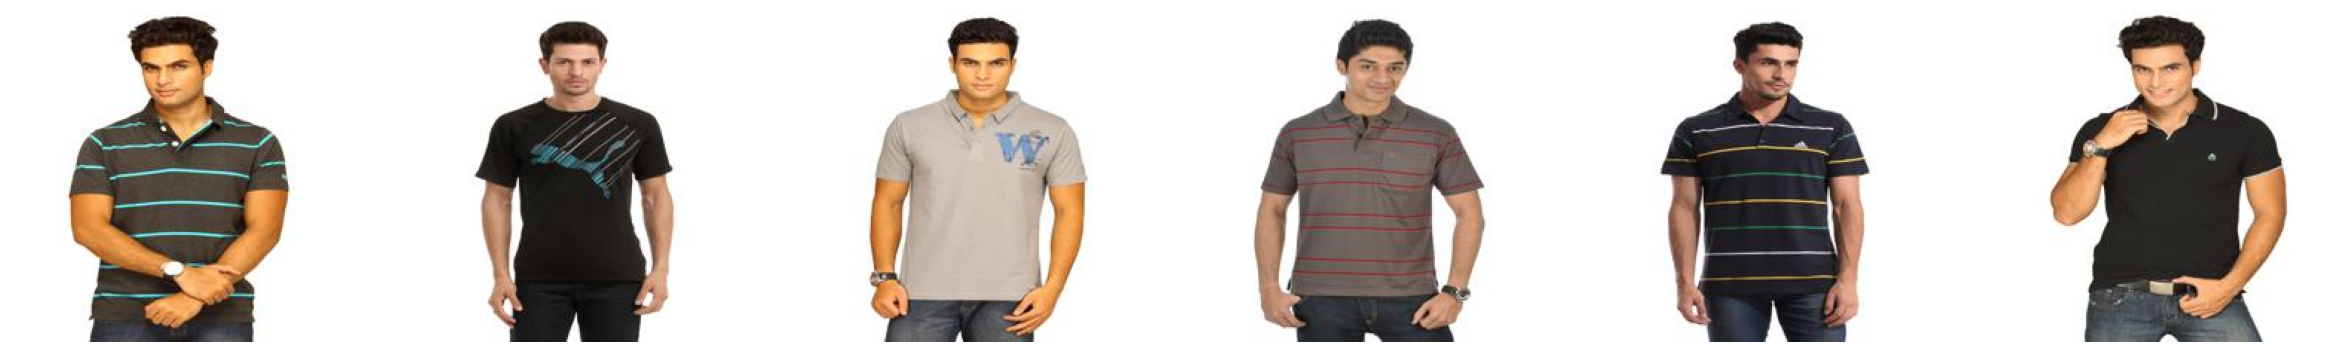

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the number of images to display horizontally
num_images = len(indices[0])

# Set up the figure and axis for displaying images horizontally
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

# Loop through the indices and display images horizontally
for i, file_index in enumerate(indices[0]):
    # Read the image
    img = mpimg.imread(my_files[file_index])

    # Display the image on the corresponding axis
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis

# Show the plot
plt.show()

Let us extract features from one more image

In [ ]:
path = "/content/drive/MyDrive/bigdataproject/resized_20k/Topwear/32253.jpg"
result = extract_important_features(img_path=path, model=model)

distances, indices = neighbors.kneighbors(X=[result])

1/1 [==============================] - 0s 32ms/step


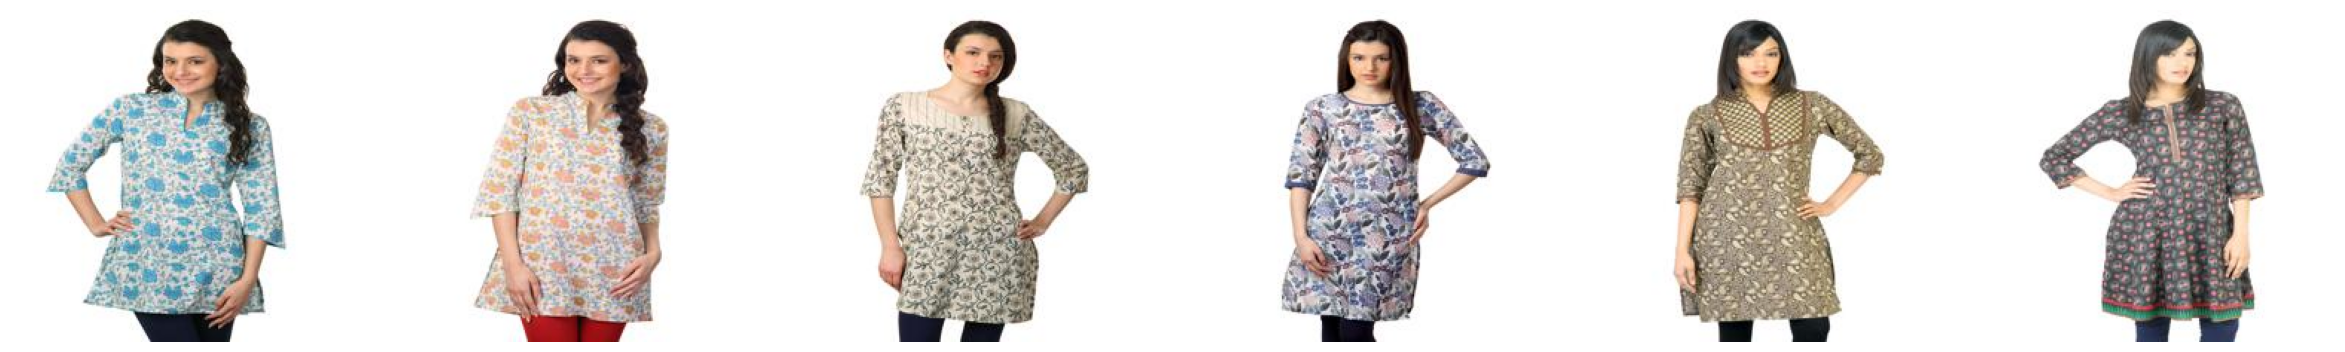

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the number of images to display horizontally
num_images = len(indices[0])

# Set up the figure and axis for displaying images horizontally
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

# Loop through the indices and display images horizontally
for i, file_index in enumerate(indices[0]):
    # Read the image
    img = mpimg.imread(my_files[file_index])

    # Display the image on the corresponding axis
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis

# Show the plot
plt.show()

**How an image Recommendation works?**

Below code implements an image recommendation system using feature extraction and similarity search techniques. It utilizes a pre-trained model to extract important features from input images and employs the Nearest Neighbors algorithm to find visually similar images in a dataset based on these features. The recommendation process involves comparing the feature representations of the input image with those of images in the dataset and selecting the nearest neighbors as recommendations. Ultimately, the system allows users to discover visually similar images to a given input image, facilitating exploration and discovery of related content.



In [ ]:
def recommender(path):
    result = extract_important_features(img_path=path, model=model)
    distances, indices = neighbors.kneighbors(X=[result])

    # Define the number of images to display horizontally
    num_images = len(indices[0])

    # Set up the figure and axis for displaying images horizontally
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    # Loop through the indices and display images horizontally
    for i, file_index in enumerate(indices[0]):
        # Read the image
        img = mpimg.imread(my_files[file_index])

        # Display the image on the corresponding axis
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis

    # Show the plot
    plt.show()

1/1 [==============================] - 0s 37ms/step


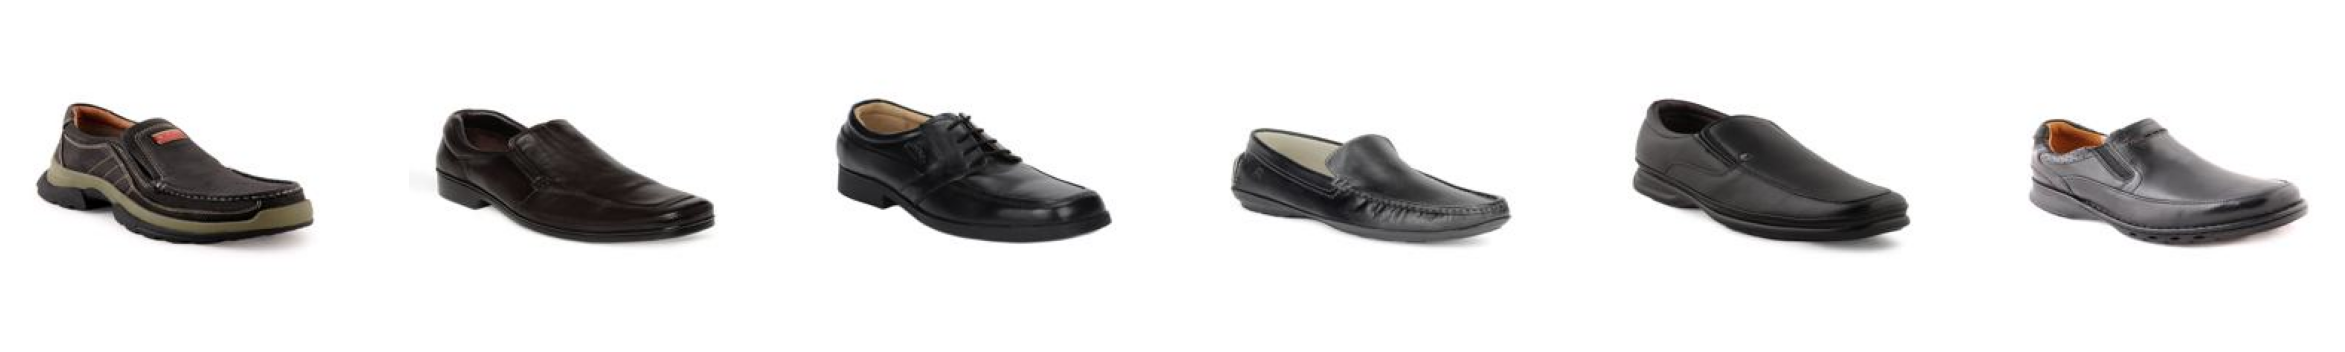

In [ ]:
recommender(path="/content/drive/MyDrive/bigdataproject/resized_20k/Shoes/10268.jpg")

**Extends ResNet model with custom fully connected layers for fine-tuning in a classification task**

Below code creates and compiles a transfer learning model by taking a pre-trained ResNet model as the base, adding custom fully connected layers for the specific classification task, and setting the optimizer to Adam, the loss function to categorical cross-entropy, and the evaluation metric to accuracy. This setup allows us to fine-tune the model for our specific dataset, improving performance on the target classification problem.

In [ ]:
# Add custom fully connected layers
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [ ]:
# Create the transfer learning model
transfer_model = Model(inputs=resnet_model.input, outputs=predictions)

In [ ]:
# Compile the model
transfer_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Below code trains the transfer learning model on the training dataset (x_train and y_train) with a batch size of 32 for 25 epochs, and evaluates its performance on the validation dataset (x_test and y_test). The history object stores the training process details, such as loss and accuracy for each epoch, which can be used for further analysis and visualization.

In [ ]:
# Train the model on each dataset size
history = transfer_model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
399/399 [==============================] - 24s 60ms/step - loss: 0.3431 - accuracy: 0.8821 - val_loss: 0.3469 - val_accuracy: 0.8828
Epoch 2/25
399/399 [==============================] - 22s 54ms/step - loss: 0.3370 - accuracy: 0.8846 - val_loss: 0.3967 - val_accuracy: 0.8633
Epoch 3/25
399/399 [==============================] - 21s 54ms/step - loss: 0.3359 - accuracy: 0.8828 - val_loss: 0.3656 - val_accuracy: 0.8771
Epoch 4/25
399/399 [==============================] - 21s 54ms/step - loss: 0.3150 - accuracy: 0.8937 - val_loss: 0.2967 - val_accuracy: 0.9031
Epoch 5/25
399/399 [==============================] - 21s 54ms/step - loss: 0.3094 - accuracy: 0.8931 - val_loss: 0.2970 - val_accuracy: 0.9028
Epoch 6/25
399/399 [==============================] - 22s 54ms/step - loss: 0.2965 - accuracy: 0.8984 - val_loss: 0.3682 - val_accuracy: 0.8828
Epoch 7/25
399/399 [==============================] - 22s 54ms/step - loss: 0.3124 - accuracy: 0.8918 - val_loss: 0.3021 - val_accuracy:

**Visualizing a Transfer Learning Model with Custom Layers**

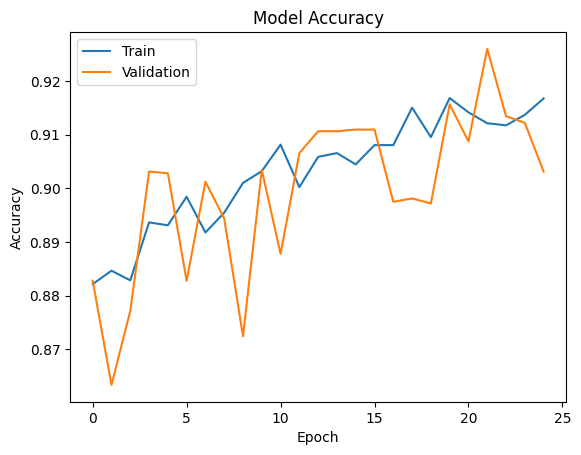

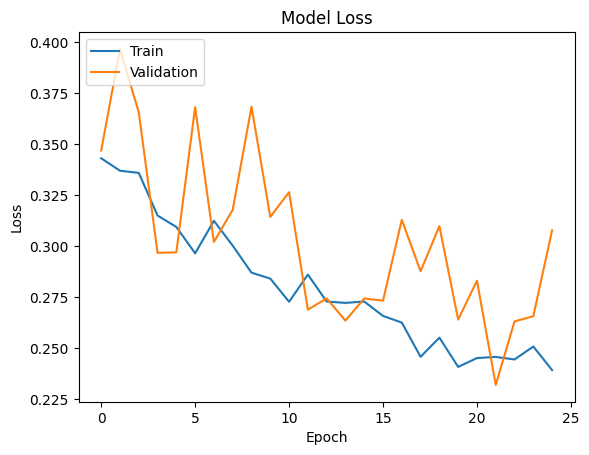

In [ ]:
import matplotlib.pyplot as plt

#Plots the accuracy of the model on the training and validation sets over each epoch.
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

#Plots the accuracy of the model on the training and validation sets over each epoch.
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot accuracy and loss curves
plot_accuracy(history)
plot_loss(history)

**Observations from Model Accuracy**

The model's performance improves over time, with accuracy increasing and
loss decreasing.

There are some fluctuations in both accuracy and loss, especially for the validation set. This is common and can be due to the complexity of the data or the learning process.

The gap between training and validation metrics is relatively small, suggesting that the model is not overfitting (learning the training data too well at the expense of generalization).

The use of transfer learning and custom layers has likely contributed to the model's good performance, as it can leverage pre-learned features while adapting to the specific task.



**Evaluating Model Performance with a Confusion Matrix**

100/100 [==============================] - 5s 40ms/step


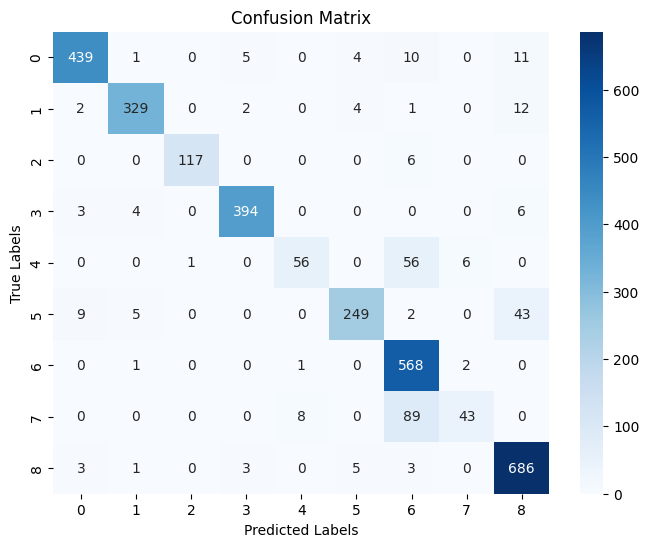

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
y_pred = transfer_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Observations from Confusion Matrix**

The model performs exceptionally well on TopWear, Shoes, and Watches.
There's confusion between similar categories (e.g Flip Flops and Sandals).

Some misclassifications (e.g Bags as TopWear) might indicate visual similarities or common co-occurrences in images.

Strong Diagonal: Most categories have high values on the diagonal, indicating good overall performance.

Best Performance: Category 8 (TopWear) has the highest correct predictions (686), followed by category 6 (Shoes) with 568.


**Plotting Precision-Recall Curves**

100/100 [==============================] - 4s 40ms/step


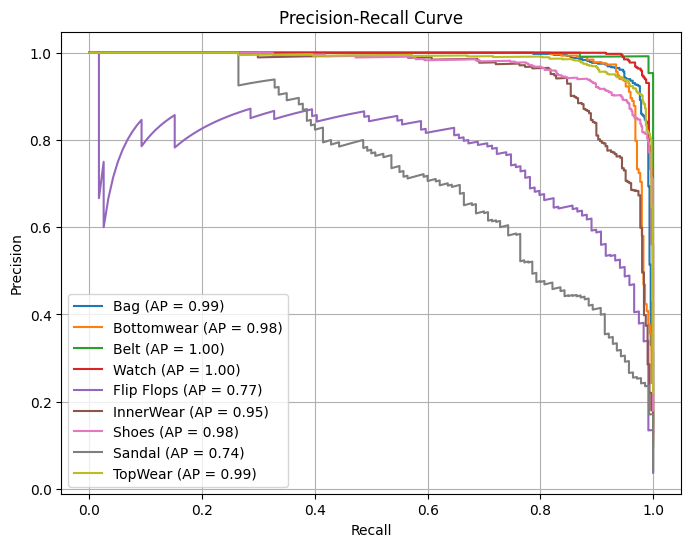

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Get the predicted probabilities for each class
y_prob = transfer_model.predict(x_test)

# Compute the precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(9): # Update the range according to the number of classes
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_prob[:, i])

# Plot the precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(9): # Update the range according to the number of classes
    class_name = category_names[i]
    plt.plot(recall[i], precision[i], label='{} (AP = {:0.2f})'.format(class_name, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


**Observations from Presion-Recall Curve**

**High Performance:** 7 out of 9 categories have AP scores ≥ 0.95, indicating robust classification.

**Perfect Classification:** Belt and Watch categories have 100% AP.

**Challenging Items:** Flip Flops (AP = 0.77) and Sandals (AP = 0.74) are harder to classify.

**Precision-Recall Balance:** High precision maintained across recall ranges for top categories.

**Model Refinement:** Focus needed on improving Flip Flops and Sandals classification.

**Practical Use:** High precision valuable for applications like inventory management.

**Data Insights:** Confusion matrix reveals misclassifications, guiding data collection strategies.

**Training Success:** Accuracy and loss curves show effective learning without overfitting.

**The practical use of the model in a fashion category classification task.**

In [ ]:
from keras.preprocessing import image

def classify_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 176))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted probabilities from the model
    predictions = model.predict(img_array)

    # Convert the probabilities to class labels
    predicted_class_index = np.argmax(predictions)
    predicted_class = category_names[predicted_class_index]

    return predicted_class

# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/bigdataproject/resized_20k/topwear_testimage.png"

# Call the function to classify the image
result = classify_image(image_path, transfer_model)

print(result)


1/1 [==============================] - 0s 39ms/step
TopWear


The model successfully classified the image as "TopWear". Given that the image filename contains "topwear", it suggests that the model's prediction is correct

In [ ]:
# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/bigdataproject/resized_20k/topwear_with_watch.png"

# Call the function to classify the image
predicted_class = classify_image(image_path, transfer_model)

print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 35ms/step
Predicted class: TopWear
